<a href="https://colab.research.google.com/github/AnkitaChakraborty1/Capstone_Adversarial_Robustness/blob/main/Tests_on_BERT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please remember to run  **pip3 install textattack[tensorflow]**  in your notebook enviroment before the following codes:

# Attacking BERT models using CAptum

Captum is a PyTorch library to explain neural networks


In [1]:
!pip3 install textattack[tensorflow] transformers folium==0.2.1

     |████████████████████████████████| 373 kB 5.1 MB/s 
     |████████████████████████████████| 4.0 MB 47.9 MB/s 
     |████████████████████████████████| 69 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 17.5 MB/s 
     |████████████████████████████████| 77 kB 3.9 MB/s 
     |████████████████████████████████| 6.6 MB 31.9 MB/s 
     |████████████████████████████████| 895 kB 35.4 MB/s 
     |████████████████████████████████| 769 kB 43.7 MB/s 
     |████████████████████████████████| 325 kB 63.4 MB/s 
     |████████████████████████████████| 60 kB 5.5 MB/s 
     |████████████████████████████████| 401 kB 49.5 MB/s 
     |████████████████████████████████| 69 kB 6.2 MB/s 
     |████████████████████████████████| 101 kB 9.3 MB/s 
     |████████████████████████████████| 462 kB 58.7 MB/s 
     |████████████████████████████████| 454.3 MB 17 kB/s 
     |████████████████████████████████| 4.9 MB 40.6 MB/s 
     |████████████████████████████████| 125 kB 54.5 MB/s 
     |██████████████████

In [1]:
pip install --upgrade numpy

     |████████████████████████████████| 15.7 MB 5.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
from textattack.datasets import HuggingFaceDataset
from textattack.models.wrappers import HuggingFaceModelWrapper
from textattack.models.wrappers import ModelWrapper
from transformers import AutoModelForSequenceClassification, AutoTokenizer

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:11<00:00, 43.2MB/s]
textattack: Unzipping file /root/.cache/textattack/tmpdfv_z2ry.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.


In [2]:
#Optional: Install dependency CAptum
!pip3 install captum

     |████████████████████████████████| 1.4 MB 5.1 MB/s 


In [3]:
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerDeepLiftShap, InternalInfluence, LayerGradientXActivation
from captum.attr import visualization as viz

In [4]:
import torch
from copy import deepcopy
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else: 
    device = torch.device("cpu")
    
print(device)

cuda:0


In [5]:
dataset = HuggingFaceDataset("ag_news", None, "train")
original_model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-ag-news")
original_tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-ag-news")
model = HuggingFaceModelWrapper(original_model,original_tokenizer)

Using custom data configuration default


textattack: Loading datasets dataset ag_news, split train.


Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a. Subsequent calls will reuse this data.


In [6]:
def get_text(tokenizer,input_ids,token_type_ids,attention_mask):
    list_of_text = []
    number = input_ids.size()[0]
    for i in range(number):
        ii = input_ids[i,].cpu().numpy()
        tt = token_type_ids[i,]
        am = attention_mask[i,]
        txt = tokenizer.decode(ii, skip_special_tokens=True)
        list_of_text.append(txt)
    return list_of_text
    
sel =2
batch_encoded = model.tokenizer([dataset[i][0]['text'] for i in range(sel)], padding=True, return_tensors="pt")
batch_encoded.to(device)
labels = [dataset[i][1] for i in range(sel)]

clone = deepcopy(model)
clone.model.to(device)

def calculate(input_ids,token_type_ids,attention_mask):
    #convert back to list of text
    return clone.model(input_ids,token_type_ids,attention_mask)[0]

lig = LayerIntegratedGradients(calculate, clone.model.bert.embeddings)

bsl = torch.zeros(batch_encoded['input_ids'].size()).type(torch.LongTensor).to(device)
labels = torch.tensor(labels).to(device)

attributions,delta = lig.attribute(inputs=batch_encoded['input_ids'],
                              baselines=bsl,
                              additional_forward_args=(batch_encoded['token_type_ids'], batch_encoded['attention_mask']),
                              n_steps = 10,
                              target = labels,
                              return_convergence_delta=True
                              )
atts = attributions.sum(dim=-1).squeeze(0)
atts = atts / torch.norm(atts)

In [7]:
atts = attributions.sum(dim=-1).squeeze(0)
atts = atts / torch.norm(atts)

In [ ]:
from textattack.attack_recipes import A2TYoo2021,BAEGarg2019,BERTAttackLi2020,CheckList2020,CLARE2020,DeepWordBugGao2018,FasterGeneticAlgorithmJia2019
from textattack.attack_recipes import GeneticAlgorithmAlzantot2018,HotFlipEbrahimi2017,InputReductionFeng2018,Kuleshov2017,MorpheusTan2020
from textattack.attack_recipes import Seq2SickCheng2018BlackBox,TextBuggerLi2018,TextFoolerJin2019,IGAWang2019,Pruthi2019,PWWSRen2019,PSOZang2020
from textattack import Attacker

In [ ]:
from textattack.attack_recipes import PWWSRen2019
attack = PWWSRen2019.build(model)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [ ]:
from textattack import Attacker

attacker = Attacker(attack, dataset)
attacker.attack_dataset()


  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 79 kB 5.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=7dfb3a99e813ec6331acbe6ac054902b4134963ec3d146563646a8e5abcd963e
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers


In [ ]:
attack = A2TYoo2021.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  gradient
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  20
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  False
        (compare_against_original):  True
      )
    (1): BERT(
        (metric):  cosine
        (threshold):  0.9
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.8
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
        (columns_to_ignore):  {'

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:01<00:09,  1.10s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:02<00:09,  1.14s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:03<00:07,  1.13s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:  40%|████      | 4/10 [00:05<00:07,  1.32s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (50%)]]

[[Iraq]] Halts [[Oil]] [[Exports]] from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Baghdad]] Halts [[Petroleum]] [[Exporter]] from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Bagdad]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 1 / 4 / 0 / 5:  50%|█████     | 5/10 [00:06<00:06,  1.23s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 1 / 5 / 0 / 6:  60%|██████    | 6/10 [00:07<00:05,  1.25s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 1 / 6 / 0 / 7:  70%|███████   | 7/10 [00:08<00:03,  1.18s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 1 / 7 / 0 / 8:  80%|████████  | 8/10 [00:09<00:02,  1.15s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 1 / 8 / 0 / 9:  90%|█████████ | 9/10 [00:12<00:01,  1.43s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 1 / 9 / 0 / 10: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 1      |
| Number of failed attacks:     | 9      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 90.0%  |
| Attack success rate:          | 10.0%  |
| Average perturbed word %:     | 10.53% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 21.2   |
+-------------------------------+--------+


In [ ]:
attack = BERTAttackLi2020.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:43<06:35, 43.92s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:56<03:46, 28.36s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Carlyle]] Looks Toward [[Commercial]] [[Aerospace]] (Reuters) Reuters - [[Private]] investment [[firm]] [[Carlyle]] Group,\which has a [[reputation]] for [[making]] well-timed and [[occasionally]]\controversial plays in the defense [[industry]], has quietly [[placed]]\its [[bets]] on another part of the market.

.[[world]] Looks Toward [[international]] [[relations]] (Reuters) Reuters - [[stake]] investment [[venture]] [[carlyed]] Group,\which has a [[master]] for [[port]] well-timed and [[odd]]\controversial plays in the defense [[department]], has quietly [[defaulted]]\its [[bonds]] on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:59<02:17, 19.69s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [01:01<01:32, 15.41s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [01:03<01:03, 12.64s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [01:13<00:48, 12.19s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (53%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - Stocks [[ended]] slightly higher on Friday\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[i]] End Up, But Near Year [[low]]" (Reuters) [[wired]] - Stocks [[crashed]] slightly higher on Friday\but stayed near [[lowas]] for the year as [[austin]] prices surged past  #36;[[box]]\a barrel, [[offsetabove]] a positive outlook from computer maker\Dell Inc. ([[linux]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [01:18<00:33, 11.16s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (61%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - [[Assets]] of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[12th]] Week (AP) AP - [[treasury]] of the nation's [[online]] money market [[bond]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[crore]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [01:21<00:20, 10.18s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[was]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [01:23<00:09,  9.29s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [02:10<00:00, 13.07s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 10.36% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 204.0  |
+------------------------

In [ ]:
attack = BAEGarg2019.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.936338023
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:26<04:00, 26.72s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (71%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[men]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:31<02:07, 15.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  30%|███       | 3/10 [00:37<01:27, 12.50s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  40%|████      | 4/10 [00:40<01:00, 10.05s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[export]]\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[releases]]\[[coal]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.43s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:  60%|██████    | 6/10 [00:56<00:37,  9.41s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:  70%|███████   | 7/10 [01:05<00:27,  9.31s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 2 / 6 / 0 / 8:  80%|████████  | 8/10 [01:14<00:18,  9.27s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 3 / 6 / 0 / 9:  90%|█████████ | 9/10 [01:16<00:08,  8.52s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sports (94%)]]

Safety Net ([[Forbes]].com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[espn]].com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 4 / 6 / 0 / 10: 100%|██████████| 10/10 [01:17<00:00,  7.75s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (97%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - [[activists]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 4      |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 60.0%  |
| Attack success rate:          | 40.0%  |
| Average perturbed word %:     | 3.99%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 134.4  |
+-------------------------------+----

In [ ]:
attack = DeepWordBugGao2018.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  30
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.31it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:03<00:12,  1.58s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:05<00:13,  1.93s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:10,  1.69s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.60s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.48s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------

In [ ]:
!pip install torchfile

  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5709 sha256=0de4da0fdf4f6305380b25f01d0f9c21c71242f08902aacc4bbfa65a5d8e0cfa
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built torchfile


In [ ]:
attack = FasterGeneticAlgorithmJia2019.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): AlzantotGeneticAlgorithm(
    (pop_size):  60
    (max_iters):  20
    (temp):  0.3
    (give_up_if_no_improvement):  False
    (post_crossover_check):  False
    (max_crossover_retries):  20
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  8
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (1): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (max_mse_dist):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (2): LearningToWriteLanguageModel(
        (max_log_prob_diff):  5.0
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



  0%|          | 0/10 [04:10<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:03<09:33, 63.74s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (65%)]]

Wall St. [[Bears]] Claw Back [[Into]] the Black (Reuters) Reuters - Short-sellers, [[Wall]] Street's [[dwindling]]\[[band]] of ultra-cynics, are seeing green again.

Wall St. [[Xiong]] Claw Back [[Towards]] the Black (Reuters) Reuters - Short-sellers, [[Mur]] Street's [[falling]]\[[banda]] of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [05:24<21:38, 162.26s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  30%|███       | 3/10 [09:35<22:23, 191.95s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  40%|████      | 4/10 [09:57<14:56, 149.37s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (55%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have [[halted]] [[oil]] export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq [[Stopped]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have [[suspended]] [[petrol]] export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:  50%|█████     | 5/10 [12:24<12:24, 148.82s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (67%)]]

[[Oil]] prices [[soar]] to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world [[oil]] prices, [[toppling]] records and straining wallets, present a new [[economic]] menace barely three months before the US presidential [[elections]].

[[Petrol]] prices [[soars]] to all-time record, posing new menace to US [[economics]] (AFP) AFP - Tearaway world [[petrol]] prices, [[overturning]] records and straining wallets, present a new [[economics]] menace barely three months before the US presidential [[voting]].




[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:  60%|██████    | 6/10 [17:21<11:34, 173.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 3 / 4 / 0 / 7:  70%|███████   | 7/10 [21:22<09:09, 183.22s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 3 / 5 / 0 / 8:  80%|████████  | 8/10 [25:54<06:28, 194.33s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 3 / 6 / 0 / 9:  90%|█████████ | 9/10 [32:35<03:37, 217.33s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 4 / 6 / 0 / 10: 100%|██████████| 10/10 [34:08<00:00, 204.84s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (79%)]]

Wall [[St]]. [[Bears]] [[Claw]] Back [[Into]] the [[Black]]  NEW YORK (Reuters) - Short-sellers, Wall Street's [[dwindling]]  [[band]] of ultra-cynics, are [[seeing]] green again.

Wall [[Street]]. [[Xiong]] [[Scrawl]] Back [[Towards]] the [[Negro]]  NEW YORK (Reuters) - Short-sellers, Wall Street's [[declining]]  [[banda]] of ultra-cynics, are [[staring]] green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 4      |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 60.0%  |
| Attack success rate:          | 40.0%  |
| Average perturbed word %:     | 21.88% |
| Average num. words per input: | 38.5   |
| Avg num

In [ ]:
attack = GeneticAlgorithmAlzantot2018.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

KeyboardInterrupt: ignored

In [ ]:
attack = HotFlipEbrahimi2017.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

ValueError: ignored

In [ ]:
attack = InputReductionFeng2018.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:11,  1.28s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (96%)]]

[[Wall]] St. [[Bears]] Claw Back [[Into]] the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, [[are]] seeing green [[again]].

St. Claw Back the Black () - Short-sellers, Wall\band of ultra-cynics, seeing green.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:03<00:13,  1.70s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (59%)]]

[[Carlyle]] Looks [[Toward]] [[Commercial]] Aerospace ([[Reuters]]) [[Reuters]] - [[Private]] [[investment]] firm [[Carlyle]] Group,\[[which]] [[has]] a reputation for [[making]] well-timed and occasionally\[[controversial]] plays [[in]] [[the]] [[defense]] [[industry]], [[has]] quietly [[placed]]\[[its]] [[bets]] [[on]] another part [[of]] [[the]] market.

Looks Aerospace () - firm Group,\ a reputation for well-timed and occasionally\ plays, quietly\ another part market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:05<00:12,  1.84s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook ([[Reuters]]) [[Reuters]] - Soaring [[crude]] [[prices]] plus [[worries]]\about [[the]] economy [[and]] [[the]] outlook [[for]] [[earnings]] are [[expected]] [[to]]\hang [[over]] [[the]] stock [[market]] [[next]] [[week]] during [[the]] [[depth]] of [[the]]\summer [[doldrums]].

and Stocks' Outlook () - Soaring plus\about economy outlook are\hang stock during of\summer.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.91s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (100%)]]

[[Iraq]] Halts [[Oil]] Exports [[from]] [[Main]] Southern [[Pipeline]] ([[Reuters]]) [[Reuters]] - Authorities [[have]] [[halted]] [[oil]] export\flows from [[the]] [[main]] [[pipeline]] [[in]] southern [[Iraq]] after\[[intelligence]] showed a rebel militia [[could]] [[strike]]\[[infrastructure]], [[an]] oil [[official]] [[said]] on Saturday.

Halts Exports Southern () - Authorities export\flows from southern after\ showed a rebel militia\, oil on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:09<00:09,  1.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

[[Oil]] prices [[soar]] [[to]] all-time record, [[posing]] [[new]] [[menace]] [[to]] [[US]] [[economy]] ([[AFP]]) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records [[and]] straining wallets, [[present]] a [[new]] [[economic]] [[menace]] barely three months [[before]] the [[US]] presidential [[elections]].

prices all-time record, () - world oil prices, records straining wallets, a barely three months the presidential.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:12<00:08,  2.00s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Stocks]] [[End]] [[Up]], [[But]] [[Near]] Year [[Lows]] (Reuters) [[Reuters]] - Stocks [[ended]] slightly [[higher]] on Friday\[[but]] [[stayed]] [[near]] lows for [[the]] year [[as]] [[oil]] [[prices]] [[surged]] [[past]]  #[[36]];[[46]]\[[a]] [[barrel]], [[offsetting]] [[a]] positive [[outlook]] [[from]] computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

, Year (Reuters) - Stocks slightly on Friday\ lows for year  #;\, positive computer\Dell. (.O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:14<00:06,  2.03s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Money]] [[Funds]] [[Fell]] in [[Latest]] Week ([[AP]]) [[AP]] - Assets of [[the]] [[nation's]] [[retail]] [[money]] [[market]] mutual funds [[fell]] [[by]]  #[[36]];[[1]].17 [[billion]] [[in]] the [[latest]] [[week]] [[to]]  #36;[[849]].98 [[trillion]], [[the]] [[Investment]] Company Institute said [[Thursday]].

in Week () - Assets of mutual funds  #;.17 the  #36;.98, Company Institute said.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.06s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Fed]] [[minutes]] show [[dissent]] [[over]] [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - [[Retail]] sales bounced back a bit in [[July]], and [[new]] [[claims]] [[for]] [[jobless]] [[benefits]] [[fell]] [[last]] [[week]], [[the]] [[government]] said [[Thursday]], [[indicating]] [[the]] economy [[is]] [[improving]] from a [[midsummer]] [[slump]].

show (USATODAY.). - sales bounced back a bit in, and, said, economy from a.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:20<00:02,  2.28s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Safety]] Net ([[Forbes]].[[com]]) Forbes.[[com]] - [[After]] [[earning]] [[a]] PH.[[D]]. [[in]] [[Sociology]], [[Danny]] Bazil [[Riley]] [[started]] to work [[as]] the general [[manager]] at [[a]] commercial real [[estate]] firm [[at]] an [[annual]] [[base]] [[salary]] [[of]]  #36;[[70]],[[000]]. Soon after, [[a]] financial planner [[stopped]] [[by]] [[his]] [[desk]] [[to]] [[drop]] off [[brochures]] about [[insurance]] [[benefits]] [[available]] [[through]] [[his]] [[employer]]. [[But]], at [[32]], "[[buying]] [[insurance]] was [[the]] furthest [[thing]] [[from]] my mind," [[says]] Riley.

Net (.) Forbes. - PH.., Bazil to work the general at commercial real firm an  #36;,. Soon after, financial planner off about., at, " was furthest my mind," Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. [[Bears]] Claw [[Back]] [[Into]] the [[Black]]  [[NEW]] [[YORK]] ([[Reuters]]) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] [[seeing]] green [[again]].

St. Claw the  () - Short-sellers, dwindling  band of, green.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 38.47% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 64.4   |
+-------------------------------+--------+


In [ ]:
attack = Kuleshov2017.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/textattack/constraints/semantics/sentence_encoders/thought_vector.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  embeddings = torch.tensor(embeddings)


Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.5
        (compare_against_original):  True
      )
    (1): ThoughtVector(
        (word_embedding):  WordEmbedding
        (metric):  max_euclidean
        (threshold):  -0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): GPT2(
        (max_log_prob_diff):  2.0
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:07<01:05,  7.27s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (80%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing [[green]] again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing [[ecology]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [01:20<05:20, 40.05s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (62%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) Reuters - [[Private]] [[investment]] [[firm]] Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly placed\its [[bets]] on another part of the market.

Carlyle Looks Toward Commercial Aerospace ([[Jazeera]]) Reuters - [[Clandestine]] [[invert]] [[stabilised]] Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the [[defence]] industry, has quietly placed\its [[blackjack]] on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [02:34<05:59, 51.38s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (58%)]]

[[Oil]] and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring [[crude]] prices [[plus]] worries\about the economy and the outlook for earnings are expected to\hang over the [[stock]] market [[next]] week during the depth of the\[[summer]] doldrums.

[[Hydrocarbon]] and Economy Cloud Stocks' [[Perspective]] (Reuters) Reuters - Soaring [[ore]] prices [[langer]] worries\about the economy and the outlook for earnings are expected to\hang over the [[stockpile]] market [[after]] week during the depth of the\[[sommer]] doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [02:48<04:12, 42.09s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (61%)]]

Iraq Halts Oil Exports from Main Southern Pipeline ([[Reuters]]) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline ([[Jazeera]]) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [03:26<03:26, 41.37s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (54%)]]

[[Oil]] prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

[[Lubrication]] prices soar to all-time record, posing new menace to [[NOUS]] [[economically]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [05:11<03:27, 51.84s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (55%)]]

[[Stocks]] End Up, But Near Year Lows (Reuters) Reuters - [[Stocks]] ended slightly higher on Friday\but stayed near lows for the [[year]] as [[oil]] prices surged past  #36;46\a [[barrel]], offsetting a positive outlook from [[computer]] maker\[[Dell]] Inc. (DELL.O)

[[Shares]] End Up, But Near Year Lows (Reuters) Reuters - [[Shares]] ended slightly higher on Friday\but stayed near lows for the [[roku]] as [[fuel]] prices surged past  #36;46\a [[cannonball]], offsetting a positive outlook from [[computing]] maker\[[Ibm]] Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [05:42<02:26, 48.95s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (78%)]]

Money Funds Fell in Latest [[Week]] (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.

Money Funds Fell in Latest [[Mois]] (AP) AP - Assets of the nation's [[shops]] money market [[communal]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [07:02<01:45, 52.76s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (60%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] [[sales]] bounced back a bit in July, and new claims for [[jobless]] benefits [[fell]] last week, the government said Thursday, indicating the [[economy]] is improving from a midsummer slump.

[[Spurred]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Vendors]] [[foul]] bounced back a bit in July, and new claims for [[unemployment]] benefits [[plummeted]] last week, the government said Thursday, indicating the [[frugal]] is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [07:25<00:49, 49.55s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (95%)]]

Safety Net ([[Forbes]].com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Gartner]].com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [07:42<00:00, 46.21s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NOVEL]] YORK (Reuters) - Short-sellers, [[Mural]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 10.0%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 839.8  |
+--------------------

In [ ]:
attack = MorpheusTan2020.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.text.minimize_bleu.MinimizeBleu'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedySearch
  (goal_function):  MinimizeBleu(
    (maximizable):  False
    (target_bleu):  0.0
  )
  (transformation):  WordSwapInflections
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



TypeError: ignored

In [ ]:
attack = Seq2SickCheng2018BlackBox.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.text.non_overlapping_output.NonOverlappingOutput'>.

  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  NonOverlappingOutput
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  30
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



TypeError: ignored

In [ ]:
attack = TextBuggerLi2018.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (2): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (3): WordSwapHomoglyphSwap
    (4): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



  0%|          | 0/10 [00:48<?, ?it/s]


 10%|█         | 1/10 [00:24<03:43, 24.83s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:24<03:43, 24.83s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (79%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\[[band]] of [[ultra-cynics]], are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellerѕ]], Wall Street's dwindling\[[ribbon]] of [[ultra-ϲynics]], are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:34<02:17, 17.18s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:34<02:17, 17.18s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:42<01:38, 14.06s/it]

[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  30%|███       | 3/10 [00:42<01:38, 14.06s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.






[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  40%|████      | 4/10 [00:44<01:06, 11.13s/it]

[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  40%|████      | 4/10 [00:44<01:06, 11.13s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (52%)]]

[[Iraq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Iarq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flоws]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.






[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  50%|█████     | 5/10 [00:47<00:47,  9.43s/it]

[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.43s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (63%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[NOUS]] [[ecoոomy]] (AFP) AFP - Tearaway world oil [[priϲes]], toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.






[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:  60%|██████    | 6/10 [00:50<00:33,  8.49s/it]

[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:50<00:33,  8.49s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (51%)]]

[[Stocks]] [[End]] Up, But Near Year Lows (Reuters) Reuters - [[Stocks]] [[ended]] slightly higher on Friday\but stayed near lows for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] [[Eոd]] Up, But Near Year Lows (Reuters) Reuters - [[Stock]] [[finalized]] slightly higher on Friday\but stayed near lows for the year as [[oiⅼ]] prices surged past  #36;[[Ꮞ6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  70%|███████   | 7/10 [00:54<00:23,  7.85s/it]

[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:54<00:23,  7.85s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company [[Institute]] said Thursday.

Money Funds Fell in [[Latеst]] [[Zhou]] (AP) AP - Assets of the nation's [[shopkeepers]] money market [[bilateral]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company [[Institutе]] said Thursday.






[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  80%|████████  | 8/10 [00:59<00:14,  7.48s/it]

[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:59<00:14,  7.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.[[com]] - [[Retail]] [[sales]] [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is [[improving]] from a midsummer slump.

[[Fueled]] minutes show dissent over inflation (USATODAY.com) USATODAY.[[coｍ]] - [[Retaіl]] [[selling]] [[bouոced]] back a bit in [[Juy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is [[improves]] from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  90%|█████████ | 9/10 [01:05<00:07,  7.31s/it]

[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [01:05<00:07,  7.31s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (82%)]]

Safety [[Net]] ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny [[Bazil]] [[Riley]] started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial [[planner]] stopped by his desk to drop off brochures about insurance [[benefits]] available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[Wisp]] ([[Fоrbes]].com) [[Sullivan]].com - After earning a PH.D. in Sociology, Danny [[Baziⅼ]] [[Riⅼey]] started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial [[planners]] stopped by his desk to drop off brochures about insurance [[benefts]] available through his employer. But, at 32, "buying insurance was the furthes



[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9: 100%|██████████| 10/10 [01:07<00:00,  6.78s/it]

[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [01:07<00:00,  6.78s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (87%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NOVEL]] [[YRK]] (Reuters) - [[Short-sellerѕ]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.02% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 122.4  |
+---------------

In [ ]:
attack = TextFoolerJin2019.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:08<01:17,  8.66s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears [[Claw]] Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. Bears [[Scrawl]] Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's [[fallen]]\[[gaza]] of ultra-cynics, are [[viewing]] [[ecological]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:22<01:29, 11.15s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sports (60%)]]

[[Carlyle]] [[Looks]] Toward [[Commercial]] [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] firm Carlyle [[Group]],\which [[has]] a [[reputation]] for [[making]] well-timed and [[occasionally]]\controversial plays in the defense [[industry]], has [[quietly]] [[placed]]\its bets on another part of the market.

[[Carlisle]] [[Expected]] Toward [[Sold]] [[Airspace]] (Reuters) Reuters - [[Privately]] [[reversing]] firm Carlyle [[Panel]],\which [[haya]] a [[renowned]] for [[produce]] well-timed and [[generally]]\controversial plays in the defense [[sectors]], has [[peacefully]] [[laid]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:42<01:38, 14.11s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:45<01:08, 11.34s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (59%)]]

[[Iraq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Mosul]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[rivers]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.88s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (54%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[NOUS]] [[save]] (AFP) AFP - Tearaway world oil [[award]], toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:00<00:40, 10.15s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] [[End]] Up, But Near [[Year]] Lows ([[Reuters]]) Reuters - [[Stocks]] [[ended]] slightly [[higher]] on [[Friday]]\but stayed near lows for the year as [[oil]] prices [[surged]] past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Reservations]] [[Concludes]] Up, But Near [[Enjoyment]] Lows ([[Newsday]]) Reuters - [[Inventory]] [[suspend]] slightly [[strictest]] on [[Today]]\but stayed near lows for the year as [[fuels]] prices [[soaring]] past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [01:06<00:28,  9.57s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (58%)]]

[[Money]] Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said [[Thursday]].

[[Treasuries]] Funds Fell in [[New]] [[Weekly]] (AP) AP - [[Wares]] of the nation's [[shopper]] money market [[bilateral]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[billion]], the Investment Company Institute said [[Ayer]].




[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [01:15<00:18,  9.42s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

[[Fed]] minutes show [[dissent]] over inflation (USATODAY.com) USATODAY.com - [[Retail]] [[sales]] [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is [[improving]] from a midsummer slump.

[[Spurred]] minutes show [[disharmony]] over inflation (USATODAY.com) USATODAY.com - [[Vendor]] [[grubby]] [[rosas]] back a bit in [[Avril]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is [[amplify]] from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [01:25<00:09,  9.46s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (94%)]]

[[Safety]] [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil [[Riley]] started to work as the [[general]] manager at a [[commercial]] real estate firm at an annual base salary of  #36;70,000. Soon after, a [[financial]] [[planner]] stopped by his desk to [[drop]] off brochures about [[insurance]] [[benefits]] available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

[[Security]] [[Networking]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil [[Conner]] started to work as the [[unmitigated]] manager at a [[ware]] real estate firm at an annual base salary of  #36;70,000. Soon after, a [[funded]] [[conspirators]] stopped by his desk to [[immerse]] off brochures about [[warranty]] [[advantages]] available through his employer. But, at 32

[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [01:27<00:00,  8.76s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (54%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[Pincers]] Back Into the Black  [[NOVEL]] [[MANHATTAN]] (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 18.24% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 225.9  |
+------

In [ ]:
attack = IGAWang2019.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): ImprovedGeneticAlgorithm(
    (pop_size):  60
    (max_iters):  20
    (temp):  0.3
    (give_up_if_no_improvement):  False
    (post_crossover_check):  False
    (max_crossover_retries):  20
    (max_replace_times_per_index):  5
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (1): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (max_mse_dist):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  False
      )
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:23<03:27, 23.04s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (70%)]]

Wall St. [[Bears]] Claw Back Into the Black (Reuters) Reuters - Short-sellers, [[Wall]] Street's dwindling\[[band]] of ultra-cynics, are [[seeing]] green again.

Wall St. [[Xiong]] Claw Back Into the Black (Reuters) Reuters - Short-sellers, [[Wail]] Street's dwindling\[[banda]] of ultra-cynics, are [[staring]] green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [06:35<26:20, 197.54s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  30%|███       | 3/10 [13:10<30:44, 263.47s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  40%|████      | 4/10 [13:48<20:43, 207.23s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (50%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted [[oil]] export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted [[petrol]] export\flows from the main pipeline in southern [[Baghdad]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:  50%|█████     | 5/10 [15:02<15:02, 180.57s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (86%)]]

[[Oil]] prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world [[oil]] [[prices]], toppling records and straining wallets, present a [[new]] economic [[menace]] barely three [[months]] before the US presidential elections.

[[Petrol]] prices soar to all-time record, posing new menace to US [[economics]] (AFP) AFP - Tearaway world [[petrol]] [[price]], toppling records and straining wallets, present a [[novel]] economic [[dangers]] barely three [[monthly]] before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:  60%|██████    | 6/10 [23:12<15:28, 232.02s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [29:12<12:31, 250.37s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Money [[Funds]] Fell in Latest [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 [[billion]] in the latest week to  #36;849.98 trillion, the Investment [[Company]] [[Institute]] said Thursday.

Money [[Sums]] Fell in Latest [[Weekly]] (AP) AP - [[Asset]] of the nation's [[shopkeepers]] money market [[bilateral]] funds fell by  #36;1.17 [[mln]] in the latest week to  #36;849.98 trillion, the Investment [[Undertakings]] [[Institutes]] said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [37:16<09:19, 279.58s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 4 / 5 / 0 / 9:  90%|█████████ | 9/10 [48:22<05:22, 322.53s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 5 / 5 / 0 / 10: 100%|██████████| 10/10 [48:38<00:00, 291.85s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (95%)]]

Wall St. Bears Claw Back [[Into]] the Black  [[NEW]] [[YORK]] (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back [[Towards]] the Black  [[NOVEL]] [[YORKE]] (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 5      |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 50.0%  |
| Attack success rate:          | 50.0%  |
| Average perturbed word %:     | 15.69% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 6889.7 |
+----------

In [ ]:
attack = Pruthi2019.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  False
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  False
      )
    (2): WordSwapRandomCharacterInsertion(
        (random_one):  False
      )
    (3): WordSwapQWERTY
    )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_num_words):  1
        (compare_against_original):  True
      )
    (1): MinWordLength
    (2): StopwordModification
    (3): RepeatModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:17<02:39, 17.70s/it]

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:17<02:39, 17.71s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:56<03:44, 28.05s/it]

[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:56<03:44, 28.06s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [01:20<03:08, 26.99s/it]

[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [01:20<03:08, 26.99s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.






[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [01:55<02:53, 28.85s/it]

[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [01:55<02:53, 28.85s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.






[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [02:24<02:24, 28.89s/it]

[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [02:24<02:24, 28.90s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.






[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [02:51<01:54, 28.60s/it]

[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [02:51<01:54, 28.60s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [03:15<01:23, 27.98s/it]

[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [03:15<01:23, 27.98s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [03:47<00:56, 28.42s/it]

[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [03:47<00:56, 28.42s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [04:31<00:30, 30.21s/it]

[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [04:31<00:30, 30.21s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [04:49<00:00, 28.91s/it]

[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [04:49<00:00, 28.91s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 792.2  |
+-------------------------------+--------+



/usr/local/lib/python3.7/dist-packages/textattack/metrics/attack_metrics/words_perturbed.py:83: RuntimeWarning: Mean of empty slice.
  average_perc_words_perturbed = self.perturbed_word_percentages.mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
attack = PSOZang2020.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Downloading https://textattack.s3.amazonaws.com/transformations/hownet/word_candidates_sense.pkl.


  0%|          | 0.00/8.39M [00:00<?, ?B/s]

  0%|          | 9.22k/8.39M [00:00<02:40, 52.1kB/s]

  1%|          | 60.4k/8.39M [00:00<02:00, 69.0kB/s]

  1%|          | 95.2k/8.39M [00:00<01:37, 85.5kB/s]

  3%|▎         | 217k/8.39M [00:00<01:10, 116kB/s]  

  5%|▌         | 443k/8.39M [00:00<00:49, 159kB/s]

 11%|█         | 913k/8.39M [00:01<00:33, 222kB/s]

 19%|█▉        | 1.57M/8.39M [00:01<00:22, 308kB/s]

 30%|██▉       | 2.49M/8.39M [00:01<00:13, 429kB/s]

 59%|█████▉    | 4.99M/8.39M [00:01<00:05, 605kB/s]

100%|██████████| 8.39M/8.39M [00:01<00:00, 4.58MB/s]
textattack: Copying /root/.cache/textattack/tmpe5haud18.zip to /root/.cache/textattack/transformations/hownet/word_candidates_sense.pkl.
textattack: Successfully saved transformations/hownet/word_candidates_sense.pkl to cache.
  0%|          | 0/10 [1:14:54<?, ?it/s]
textattack: Unknown if model of class <clas

Attack(
  (search_method): ParticleSwarmOptimization(
    (pop_size):  60
    (max_iters):  20
    (post_turn_check):  True
    (max_turn_retries):  20
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapHowNet(
    (max_candidates):  -1
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
    (2): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
        (columns_to_ignore):  {'premise'}
      )
  (is_black_box):  True
) 



AssertionError: ignored

In [8]:
from textattack import AttackArgs, Attacker
from textattack.datasets import HuggingFaceDataset
from textattack.models.wrappers import ModelWrapper
from textattack import Attack
from textattack.constraints.pre_transformation import (
        InputColumnModification,
        MaxModificationRate,
        RepeatModification,
        StopwordModification,
        MaxWordIndexModification
                )
from textattack.constraints.semantics import WordEmbeddingDistance
from textattack.goal_functions import UntargetedClassification,InputReduction
from textattack.search_methods import GreedyWordSwapWIR,AlzantotGeneticAlgorithm
from textattack.transformations import WordSwapQWERTY
from textattack.transformations import (
    CompositeTransformation,
    WordSwapNeighboringCharacterSwap,
    WordSwapQWERTY,
    WordSwapWordNet,
    WordSwapRandomCharacterDeletion,
    WordSwapRandomCharacterInsertion,
    WordSwapRandomCharacterSubstitution,
    WordSwapHomoglyphSwap,
    WordSwapEmbedding,
    WordDeletion,
)
from textattack.constraints.overlap import LevenshteinEditDistance
#from textattack.attack_recipe import AttackRecipe
from textattack import Attack
from textattack.constraints.overlap import MaxWordsPerturbed
from textattack.constraints.pre_transformation import (
    RepeatModification,
    StopwordModification,
)
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
from textattack.goal_functions import UntargetedClassification
from textattack.search_methods import GreedyWordSwapWIR
from textattack.transformations import WordSwapMaskedLM
from abc import ABC, abstractmethod
import numpy as np

DeepWordBugGao2018  - Iterating over the alue of Levenshtein Edit Distance in the range 20-39

In [ ]:
class Recipe1(Attack,ABC):
    @staticmethod
    def build(model_wrapper,edit_distance):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    # (1) Swap: Swap two adjacent letters in the word.
                    WordSwapNeighboringCharacterSwap(),
                    # (2) Substitution: Substitute a letter in the word with a random letter.
                    WordSwapRandomCharacterSubstitution(),
                    # (3) Deletion: Delete a random letter from the word.
                    WordSwapRandomCharacterDeletion(),
                    # (4) Insertion: Insert a random letter in the word.
                    WordSwapRandomCharacterInsertion(),
                ])

        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(edit_distance))
        goal_function = UntargetedClassification(model_wrapper)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR()
        return Attack(goal_function, constraints, transformation, search_method)


In [ ]:
for ed in range(10,40):
    print("Starting attack for Levenshtein Edit Distance-----------------",ed)
    attack = Recipe1.build(model,ed)
    attacker = Attacker(attack, dataset)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]

Starting attack for Levenshtein Edit Distance----------------- 10
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  10
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.40s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.40s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:04<00:18,  2.26s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:04<00:18,  2.26s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:07<00:17,  2.55s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:07<00:17,  2.55s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:09<00:14,  2.38s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.38s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:11<00:11,  2.32s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.33s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.46s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.46s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:17<00:07,  2.57s/it]

[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:17<00:07,  2.57s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  80%|████████  | 8/10 [00:19<00:04,  2.50s/it]

[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:19<00:04,  2.50s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (60%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[Fejd]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[RetaSl]] sales [[Ebounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  90%|█████████ | 9/10 [00:23<00:02,  2.57s/it]

[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:23<00:02,  2.57s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Fopbes]].com) [[FTrbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9: 100%|██████████| 10/10 [00:24<00:00,  2.47s/it]

[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:24<00:00,  2.47s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (98%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NUW]] [[YkORK]] (Reuters) - [[Short-selers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.42% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 66.5   |
+--------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 11
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  11
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.42s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.43s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:04<00:19,  2.47s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:04<00:19,  2.47s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:08<00:18,  2.71s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.71s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:10<00:15,  2.51s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.51s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.43s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.43s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (60%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[Fejd]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[RetaSl]] sales [[Ebounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  90%|█████████ | 9/10 [00:23<00:02,  2.66s/it]

[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:23<00:02,  2.66s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Fopbes]].com) [[FTrbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]

[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (98%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NUW]] [[YkORK]] (Reuters) - [[Short-selers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.42% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 69.1   |
+--------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 12
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  12
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.34s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.34s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:04<00:18,  2.37s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:04<00:19,  2.38s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:07<00:18,  2.61s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:07<00:18,  2.61s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:09<00:14,  2.41s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.41s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:11<00:11,  2.33s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.34s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.45s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.45s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:18<00:07,  2.58s/it]

[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:18<00:07,  2.58s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  80%|████████  | 8/10 [00:19<00:04,  2.49s/it]

[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:19<00:04,  2.49s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (60%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[Fejd]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[RetaSl]] sales [[Ebounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  90%|█████████ | 9/10 [00:22<00:02,  2.53s/it]

[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:22<00:02,  2.53s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Fopbes]].com) [[FTrbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]

[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (98%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NUW]] [[YkORK]] (Reuters) - [[Short-selers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.42% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 68.3   |
+--------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 13
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  13
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:11,  1.33s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.34s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:04<00:19,  2.43s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:04<00:19,  2.43s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:07<00:18,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:07<00:18,  2.64s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:09<00:14,  2.44s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.44s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:11<00:11,  2.36s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.36s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.47s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.47s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:18<00:08,  2.67s/it]

[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:18<00:08,  2.67s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  80%|████████  | 8/10 [00:20<00:05,  2.57s/it]

[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:20<00:05,  2.57s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (60%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[Fejd]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[RetaSl]] sales [[Ebounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  90%|█████████ | 9/10 [00:23<00:02,  2.61s/it]

[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:23<00:02,  2.62s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Fopbes]].com) [[FTrbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it]

[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (98%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NUW]] [[YkORK]] (Reuters) - [[Short-selers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.42% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 69.8   |
+--------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 14
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  14
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:04<00:19,  2.47s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:04<00:19,  2.48s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:08<00:18,  2.68s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:18,  2.69s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:09<00:14,  2.48s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.48s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:11<00:11,  2.40s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.40s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.73s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.63s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (60%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[Fejd]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[RetaSl]] sales [[Ebounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  90%|█████████ | 9/10 [00:23<00:02,  2.67s/it]

[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:23<00:02,  2.67s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Fopbes]].com) [[FTrbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]

[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (98%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NUW]] [[YkORK]] (Reuters) - [[Short-selers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.42% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 70.4   |
+--------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 15
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  15
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.36s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:20,  2.54s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:05<00:20,  2.54s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:08<00:19,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.74s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:10<00:15,  2.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.52s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.42s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.42s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:15<00:10,  2.53s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.53s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.75s/it]

[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.75s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money [[market]] [[mutual]] funds [[fell]] by  #36;1.[[17]] billion in the latest week to  #36;[[849]].[[98]] [[trillion]], the Investment Company [[Institute]] [[said]] Thursday.

Money Funds Fell in [[LatAst]] [[Wek]] (AP) AP - [[Rssets]] of the nation's [[retaiC]] money [[maket]] [[mutuatl]] funds [[Fell]] by  #36;1.[[j17]] billion in the latest week to  #36;[[894]].[[D98]] [[trillon]], the Investment Company [[Istitute]] [[sadi]] Thursday.






[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.70s/it]

[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.70s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (61%)]]

[[Fed]] [[minutes]] [[show]] dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[ked]] [[miAnutes]] [[seow]] dissent over inflation (USATODAY.com) USATODAY.com - [[Reail]] sales [[boCunced]] back a bit in [[Jluy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[XForbes]].com) [[FVorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.61s/it]

[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.61s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[ClSw]] Back Into the Black  [[NEjW]] [[YORVK]] (Reuters) - [[Short-ellers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 16.18% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 72.0   |


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 16
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  16
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:20,  2.59s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:05<00:20,  2.59s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:08<00:19,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.77s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:10<00:15,  2.53s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.53s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.44s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.44s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.54s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money [[market]] [[mutual]] funds [[fell]] by  #36;1.[[17]] billion in the latest week to  #36;[[849]].[[98]] [[trillion]], the Investment Company [[Institute]] [[said]] Thursday.

Money Funds Fell in [[LatAst]] [[Wek]] (AP) AP - [[Rssets]] of the nation's [[retaiC]] money [[maket]] [[mutuatl]] funds [[Fell]] by  #36;1.[[j17]] billion in the latest week to  #36;[[894]].[[D98]] [[trillon]], the Investment Company [[Istitute]] [[sadi]] Thursday.






[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.71s/it]

[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.71s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (61%)]]

[[Fed]] [[minutes]] [[show]] dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[ked]] [[miAnutes]] [[seow]] dissent over inflation (USATODAY.com) USATODAY.com - [[Reail]] sales [[boCunced]] back a bit in [[Jluy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[XForbes]].com) [[FVorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.61s/it]

[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.61s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[ClSw]] Back Into the Black  [[NEjW]] [[YORVK]] (Reuters) - [[Short-ellers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 16.18% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 72.4   |


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 17
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  17
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:20,  2.61s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:05<00:20,  2.61s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:08<00:19,  2.77s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.77s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:10<00:15,  2.54s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.55s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.45s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.45s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:15<00:10,  2.55s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.55s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.76s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money [[market]] [[mutual]] funds [[fell]] by  #36;1.[[17]] billion in the latest week to  #36;[[849]].[[98]] [[trillion]], the Investment Company [[Institute]] [[said]] Thursday.

Money Funds Fell in [[LatAst]] [[Wek]] (AP) AP - [[Rssets]] of the nation's [[retaiC]] money [[maket]] [[mutuatl]] funds [[Fell]] by  #36;1.[[j17]] billion in the latest week to  #36;[[894]].[[D98]] [[trillon]], the Investment Company [[Istitute]] [[sadi]] Thursday.






[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.71s/it]

[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.71s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (61%)]]

[[Fed]] [[minutes]] [[show]] dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[ked]] [[miAnutes]] [[seow]] dissent over inflation (USATODAY.com) USATODAY.com - [[Reail]] sales [[boCunced]] back a bit in [[Jluy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.74s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[XForbes]].com) [[FVorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.62s/it]

[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.62s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[ClSw]] Back Into the Black  [[NEjW]] [[YORVK]] (Reuters) - [[Short-ellers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 16.18% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 72.5   |


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 18
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  18
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:21,  2.67s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:05<00:21,  2.67s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:08<00:19,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.81s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:10<00:15,  2.57s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.57s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.47s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.47s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:15<00:10,  2.57s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.57s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.78s/it]

[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.78s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money [[market]] [[mutual]] funds [[fell]] by  #36;1.[[17]] billion in the latest week to  #36;[[849]].[[98]] [[trillion]], the Investment Company [[Institute]] [[said]] Thursday.

Money Funds Fell in [[LatAst]] [[Wek]] (AP) AP - [[Rssets]] of the nation's [[retaiC]] money [[maket]] [[mutuatl]] funds [[Fell]] by  #36;1.[[j17]] billion in the latest week to  #36;[[894]].[[D98]] [[trillon]], the Investment Company [[Istitute]] [[sadi]] Thursday.






[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.72s/it]

[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.72s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (61%)]]

[[Fed]] [[minutes]] [[show]] dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[ked]] [[miAnutes]] [[seow]] dissent over inflation (USATODAY.com) USATODAY.com - [[Reail]] sales [[boCunced]] back a bit in [[Jluy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.75s/it]

[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.75s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[XForbes]].com) [[FVorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[ClSw]] Back Into the Black  [[NEjW]] [[YORVK]] (Reuters) - [[Short-ellers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 16.18% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 72.8   |


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 19
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  19
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.36s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.37s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:21,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:05<00:21,  2.75s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:08<00:20,  2.86s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:20,  2.87s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:10<00:15,  2.61s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.61s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.50s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.50s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:15<00:10,  2.59s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.59s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.80s/it]

[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.80s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money [[market]] [[mutual]] funds [[fell]] by  #36;1.[[17]] billion in the latest week to  #36;[[849]].[[98]] [[trillion]], the Investment Company [[Institute]] [[said]] Thursday.

Money Funds Fell in [[LatAst]] [[Wek]] (AP) AP - [[Rssets]] of the nation's [[retaiC]] money [[maket]] [[mutuatl]] funds [[Fell]] by  #36;1.[[j17]] billion in the latest week to  #36;[[894]].[[D98]] [[trillon]], the Investment Company [[Istitute]] [[sadi]] Thursday.






[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (61%)]]

[[Fed]] [[minutes]] [[show]] dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[ked]] [[miAnutes]] [[seow]] dissent over inflation (USATODAY.com) USATODAY.com - [[Reail]] sales [[boCunced]] back a bit in [[Jluy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.77s/it]

[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.77s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[XForbes]].com) [[FVorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[ClSw]] Back Into the Black  [[NEjW]] [[YORVK]] (Reuters) - [[Short-ellers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 16.18% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 20
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  20
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.80s/it]

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.81s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:08<00:20,  2.91s/it]

[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:20,  2.91s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:10<00:15,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.64s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.53s/it]

[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.53s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].






[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:15<00:10,  2.62s/it]

[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money [[market]] [[mutual]] funds [[fell]] by  #36;1.[[17]] billion in the latest week to  #36;[[849]].[[98]] [[trillion]], the Investment Company [[Institute]] [[said]] Thursday.

Money Funds Fell in [[LatAst]] [[Wek]] (AP) AP - [[Rssets]] of the nation's [[retaiC]] money [[maket]] [[mutuatl]] funds [[Fell]] by  #36;1.[[j17]] billion in the latest week to  #36;[[894]].[[D98]] [[trillon]], the Investment Company [[Istitute]] [[sadi]] Thursday.






[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  80%|████████  | 8/10 [00:22<00:05,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:22<00:05,  2.76s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (61%)]]

[[Fed]] [[minutes]] [[show]] dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[ked]] [[miAnutes]] [[seow]] dissent over inflation (USATODAY.com) USATODAY.com - [[Reail]] sales [[boCunced]] back a bit in [[Jluy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  90%|█████████ | 9/10 [00:25<00:02,  2.78s/it]

[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:25<00:02,  2.78s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[XForbes]].com) [[FVorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.66s/it]

[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.66s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[ClSw]] Back Into the Black  [[NEjW]] [[YORVK]] (Reuters) - [[Short-ellers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 16.18% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.6   |


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 21
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.87s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.87s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 22
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  22
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.36s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.37s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.12s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.96s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.77s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 23
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  23
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.73s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 24
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  24
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 25
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  25
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 26
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  26
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.37s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.37s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.90s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.54s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.12s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 27
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  27
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.34s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 28
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  28
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.34s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.87s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 29
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  29
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 30
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  30
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.36s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 31
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  31
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 32
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  32
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.34s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.87s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.87s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 33
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  33
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 34
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  34
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.36s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.37s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 35
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  35
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.34s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 36
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  36
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.35s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 37
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  37
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.34s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.10s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 38
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  38
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.34s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 39
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  39
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:12,  1.36s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.36s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:05<00:23,  2.88s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:05<00:23,  2.89s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:17<00:11,  2.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:21<00:05,  2.74s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.






[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.2   |
+-------

Adding new constraints to DeepWordbugGao
1. MaxWordsPerturbed
2. Universal Sentence Encoder
3. Both 1 and 2

In [ ]:
class DeepWordMaxWords(Attack,ABC):
    @staticmethod
    def build(model_wrapper,max_percent):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    # (1) Swap: Swap two adjacent letters in the word.
                    WordSwapNeighboringCharacterSwap(),
                    # (2) Substitution: Substitute a letter in the word with a random letter.
                    WordSwapRandomCharacterSubstitution(),
                    # (3) Deletion: Delete a random letter from the word.
                    WordSwapRandomCharacterDeletion(),
                    # (4) Insertion: Insert a random letter in the word.
                    WordSwapRandomCharacterInsertion(),
                ])

        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(21))
        constraints.append(MaxWordsPerturbed(max_percent=max_percent))
        goal_function = UntargetedClassification(model_wrapper)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR()
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = DeepWordMaxWords.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.29it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:03<00:12,  1.59s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:05<00:13,  1.94s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:10,  1.69s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.60s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.48s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------

In [ ]:
for max_percent in np.arange(0.1, 0.6, 0.05).tolist():
    print("Starting attack with maximum percentage of words allowed to be altered as-----------------",max_percent)
    attack = DeepWordMaxWords.build(model,max_percent)
    attacker = Attacker(attack, dataset)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Starting attack with maximum percentage of words allowed to be altered as----------------- 0.1
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.1
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.29it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:02<00:08,  1.10s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  30%|███       | 3/10 [00:03<00:08,  1.20s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  40%|████      | 4/10 [00:04<00:06,  1.15s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flos]] from the main pipeline in southern [[IrNaq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[vil]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:  50%|█████     | 5/10 [00:05<00:05,  1.13s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:  60%|██████    | 6/10 [00:06<00:04,  1.16s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:  70%|███████   | 7/10 [00:08<00:03,  1.15s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 2 / 6 / 0 / 8:  80%|████████  | 8/10 [00:09<00:02,  1.15s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 3 / 6 / 0 / 9:  90%|█████████ | 9/10 [00:10<00:01,  1.19s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (83%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[oFrbes]].com) [[Forbem]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 3 / 7 / 0 / 10: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 3      |
| Number of failed attacks:     | 7      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 70.0%  |
| Attack success rate:          | 30.0%  |
| Average perturbed word %:     | 8.32%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 57.6   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.15000000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.15000000000000002
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.34it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:02<00:09,  1.17s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.35s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:05<00:07,  1.26s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:06<00:06,  1.22s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:07<00:05,  1.29s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [00:09<00:03,  1.30s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [00:10<00:02,  1.28s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (67%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[Fded]] [[mniutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Rtail]] sales [[bouncde]] back a bit in [[Juy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [00:11<00:01,  1.31s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (94%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Forbse]].com) [[Fcorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 11.19% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 63.8   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.20000000000000004
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.20000000000000004
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.34it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:02<00:09,  1.25s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.40s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:05<00:07,  1.30s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:06<00:06,  1.26s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:07<00:05,  1.33s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:09<00:04,  1.36s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:10<00:02,  1.32s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (60%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[Fejd]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[RetaSl]] sales [[Ebounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:12<00:01,  1.34s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Fopbes]].com) [[FTrbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:12<00:00,  1.29s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (98%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NUW]] [[YkORK]] (Reuters) - [[Short-selers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.42% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 65.9   |
+--------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.25000000000000006
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.25000000000000006
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.34it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.37s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.48s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.35s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:06<00:06,  1.30s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:08<00:05,  1.37s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:09<00:04,  1.42s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:10<00:02,  1.37s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (60%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[Fejd]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[RetaSl]] sales [[Ebounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:12<00:01,  1.38s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Fopbes]].com) [[FTrbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:13<00:00,  1.33s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (98%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NUW]] [[YkORK]] (Reuters) - [[Short-selers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.42% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 67.9   |
+--------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.30000000000000004
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.30000000000000004
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.33it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:02<00:11,  1.46s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.54s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.40s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:06<00:06,  1.34s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:08<00:05,  1.40s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money [[market]] [[mutual]] funds fell by  #36;1.[[17]] billion in the latest week to  #36;[[849]].[[98]] [[trillion]], the Investment Company [[Institute]] [[said]] Thursday.

Money Funds Fell in [[LatAst]] [[Wek]] (AP) AP - [[Rssets]] of the nation's [[retaiC]] money [[maket]] [[mutuatl]] funds fell by  #36;1.[[j17]] billion in the latest week to  #36;[[894]].[[D98]] [[trillon]], the Investment Company [[Istitute]] [[sadi]] Thursday.




[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.49s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (61%)]]

[[Fed]] [[minutes]] [[show]] dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[ked]] [[miAnutes]] [[seow]] dissent over inflation (USATODAY.com) USATODAY.com - [[Reail]] sales [[boCunced]] back a bit in [[Jluy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.49s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[XForbes]].com) [[FVorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[ClSw]] Back Into the Black  [[NEjW]] [[YORVK]] (Reuters) - [[Short-ellers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 15.89% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 72.5   |


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.3500000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.3500000000000001
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.34it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:03<00:12,  1.53s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:04<00:11,  1.59s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (72%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crdue]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flws]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:06<00:06,  1.37s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:08<00:05,  1.42s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Frdiay]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money [[market]] [[mutual]] funds fell by  #36;1.[[17]] billion in the latest week to  #36;[[849]].[[98]] [[trillion]], the Investment Company [[Institute]] [[said]] Thursday.

Money Funds Fell in [[LatAst]] [[Wek]] (AP) AP - [[Rssets]] of the nation's [[retaiC]] money [[maket]] [[mutuatl]] funds fell by  #36;1.[[j17]] billion in the latest week to  #36;[[894]].[[D98]] [[trillon]], the Investment Company [[Istitute]] [[sadi]] Thursday.




[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.50s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (61%)]]

[[Fed]] [[minutes]] [[show]] dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[ked]] [[miAnutes]] [[seow]] dissent over inflation (USATODAY.com) USATODAY.com - [[Reail]] sales [[boCunced]] back a bit in [[Jluy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[XForbes]].com) [[FVorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[ClSw]] Back Into the Black  [[NEjW]] [[YORVK]] (Reuters) - [[Short-ellers]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 15.89% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.3   |


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.40000000000000013
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.40000000000000013
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.34it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:03<00:12,  1.60s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:05<00:13,  1.97s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:10,  1.72s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.61s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.50s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.50s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.45000000000000007
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.45000000000000007
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.34it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:03<00:12,  1.60s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:05<00:13,  1.97s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:10,  1.72s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.61s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.50s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.50s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.5000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.5000000000000001
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.34it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:03<00:12,  1.60s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:05<00:13,  1.96s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:10,  1.72s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.61s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.50s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.50s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.5500000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.5500000000000002
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:06,  1.34it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:03<00:12,  1.60s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:05<00:13,  1.96s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (66%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EconomDy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:10,  1.72s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (63%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[fjlows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.61s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[rFiday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.50s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.50s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Fobres]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[Walo]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------

In [13]:
class DeepWordUSE(Attack,ABC):
    @staticmethod
    def build(model_wrapper,use):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    # (1) Swap: Swap two adjacent letters in the word.
                    WordSwapNeighboringCharacterSwap(),
                    # (2) Substitution: Substitute a letter in the word with a random letter.
                    WordSwapRandomCharacterSubstitution(),
                    # (3) Deletion: Delete a random letter from the word.
                    WordSwapRandomCharacterDeletion(),
                    # (4) Insertion: Insert a random letter in the word.
                    WordSwapRandomCharacterInsertion(),
                ])

        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(21))
        use_constraint = UniversalSentenceEncoder(
            threshold=use,
            metric="cosine",
            compare_against_original=True,
            window_size=None,
        )
        constraints.append(use_constraint)
        goal_function = UntargetedClassification(model_wrapper)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR()
        return Attack(goal_function, constraints, transformation, search_method)

In [15]:
for use in np.arange(0, 2.1, 0.1).tolist():
    print("Starting attack with threshold value for Universal Sentence Encoder as-----------------",use)
    attack = DeepWordUSE.build(model,use)
    attacker = Attacker(attack, dataset)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]

Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.0
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.0
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_bo


 10%|█         | 1/10 [00:04<00:43,  4.85s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.86s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:07<00:29,  3.74s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.74s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.45s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.45s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].





[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:11<00:17,  2.84s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:17,  2.84s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.52s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.52s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].





[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.40s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.40s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)





[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.22s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.1
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.1
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:43,  4.80s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.80s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:07<00:29,  3.71s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.72s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.44s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.44s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].





[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:11<00:17,  2.83s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:17,  2.84s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.52s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.52s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].





[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.40s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.40s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)





[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.2
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:43,  4.86s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.87s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:07<00:29,  3.74s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.75s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.46s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.46s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].





[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:11<00:17,  2.85s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:17,  2.85s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.53s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.53s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].





[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.40s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.41s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)





[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:15<00:06,  2.22s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.22s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.10s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.04s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.30000000000000004
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.30000000000000004
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): St


 10%|█         | 1/10 [00:06<00:57,  6.40s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:06<00:57,  6.41s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:09<00:36,  4.51s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:09<00:36,  4.51s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:11<00:27,  3.97s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:11<00:27,  3.97s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].





[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:12<00:19,  3.23s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:19,  3.23s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.83s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].





[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:15<00:10,  2.66s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.66s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)





[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:17<00:07,  2.44s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:17<00:07,  2.44s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:18<00:04,  2.29s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:18<00:04,  2.29s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:19<00:02,  2.20s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:19<00:02,  2.21s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.4
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:42,  4.73s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:42,  4.73s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:07<00:29,  3.67s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.68s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:23,  3.41s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:23,  3.41s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].





[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:11<00:16,  2.81s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:16,  2.81s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.49s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.50s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].





[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.38s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.38s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)





[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:15<00:06,  2.19s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.20s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:16<00:04,  2.07s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.07s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:18<00:02,  2.02s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.02s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:19<00:00,  1.90s/it]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.90s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.5
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.5
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:43,  4.79s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.80s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:07<00:29,  3.71s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.71s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.44s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.44s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].





[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:11<00:16,  2.83s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:16,  2.83s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.51s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.51s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].





[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.39s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.40s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)





[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.6000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.6000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop


 10%|█         | 1/10 [00:04<00:43,  4.81s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.82s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:07<00:29,  3.72s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.72s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.44s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.45s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].





[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:11<00:17,  2.84s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:17,  2.84s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.52s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.52s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].





[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.40s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.40s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)





[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.7000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.7000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop


 10%|█         | 1/10 [00:04<00:43,  4.83s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.84s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:07<00:29,  3.73s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.73s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (74%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\[[controversial]] plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the market.

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\[[controversia]] plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the market.





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.44s/it]
[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.44s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:11<00:16,  2.83s/it]
[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:11<00:16,  2.83s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (66%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flFows]] from the main pipeline in southern [[Iarq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[ojil]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.48s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.48s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (62%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[NUS]] [[ecowomy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentia]] [[elecTtions]].





[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:16<00:10,  2.69s/it]
[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:16<00:10,  2.69s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  70%|███████   | 7/10 [00:17<00:07,  2.46s/it]
[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:17<00:07,  2.46s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Lajtest]] Week (AP) AP - Assets of the nation's [[rtail]] money market [[muutal]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[prillion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  80%|████████  | 8/10 [00:18<00:04,  2.31s/it]
[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:18<00:04,  2.31s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (70%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[eFd]] [[miutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Rtail]] sales [[bouZced]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  90%|█████████ | 9/10 [00:20<00:02,  2.22s/it]
[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:20<00:02,  2.22s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (85%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[FGorbes]].com) [[yorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]
[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears [[Claw]] Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[ClVaw]] Back Into the Black  NEW [[YOeK]] (Reuters) - [[Short-sallers]], [[WAall]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 14.92% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 80.8   |
+-----


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.8
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:06<00:58,  6.48s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:06<00:58,  6.48s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:08<00:34,  4.33s/it]
[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:08<00:34,  4.33s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.49s/it]
[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.49s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (54%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crde]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.





[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:11<00:17,  2.87s/it]
[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:11<00:17,  2.88s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flowKs]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.53s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.53s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].





[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.42s/it]
[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.42s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  70%|███████   | 7/10 [00:16<00:07,  2.40s/it]
[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:16<00:07,  2.40s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (57%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) [[AP]] - [[Assets]] of the nation's [[retail]] money [[market]] [[mutual]] funds fell by  #36;1.[[17]] billion in the latest week to  #[[36]];[[849]].[[98]] [[trillion]], the Investment Company Institute [[said]] Thursday.

Money Funds Fell in [[Latast]] [[Wek]] (AP) [[AXP]] - [[AsZets]] of the nation's [[reatil]] money [[markTt]] [[mutugal]] funds fell by  #36;1.[[1p]] billion in the latest week to  #[[63]];[[Z49]].[[E98]] [[trillon]], the Investment Company Institute [[siad]] Thursday.





[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  80%|████████  | 8/10 [00:18<00:04,  2.25s/it]
[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:18<00:04,  2.25s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[eFd]] [[minutse]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retaiu]] sales [[bunced]] back a bit in [[Juyl]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  90%|█████████ | 9/10 [00:19<00:02,  2.17s/it]
[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:19<00:02,  2.18s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (98%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[ForbeNs]].com) [[Zorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]
[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (98%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NsW]] [[YROK]] (Reuters) - [[Shorts-ellers]], [[Wal]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 14.94% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 69.2   |
+---------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.9
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.9
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:43,  4.81s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.82s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:06<00:27,  3.42s/it]
[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:06<00:27,  3.42s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:08<00:20,  2.88s/it]
[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:20,  2.88s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (54%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crde]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.





[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:09<00:14,  2.41s/it]
[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.41s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flowKs]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:10<00:10,  2.17s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:10<00:10,  2.17s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (56%)]]

Oil prices [[soar]] to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three [[months]] before the US [[presidential]] [[elections]].

Oil prices [[saor]] to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three [[monuhs]] before the US [[presidentil]] [[electoins]].





[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:12<00:08,  2.11s/it]
[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:12<00:08,  2.11s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  70%|███████   | 7/10 [00:14<00:06,  2.05s/it]
[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:14<00:06,  2.05s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the [[nation's]] [[retail]] money market [[mutual]] funds fell by  #[[36]];1.17 billion in the latest week to  #[[36]];[[849]].[[98]] [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[LatBst]] Week (AP) AP - Assets of the [[nations']] [[rtail]] money market [[muutal]] funds fell by  #[[Z6]];1.17 billion in the latest week to  #[[3f]];[[89]].[[89]] [[trSllion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  80%|████████  | 8/10 [00:15<00:03,  1.95s/it]
[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:15<00:03,  1.95s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (66%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[eFd]] [[mniutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retali]] sales [[bounsed]] back a bit in [[Juyl]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  90%|█████████ | 9/10 [00:17<00:01,  1.90s/it]
[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:17<00:01,  1.91s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (46%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Foxrbes]].com) [[FRorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]
[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Wall St. Bears [[Claw]] [[Back]] Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], Wall [[Street's]] dwindling  band of [[ultra-cynics]], are seeing green again.

Wall St. Bears [[lCaw]] [[Bcak]] Into the Black  [[NEKW]] [[YOiK]] (Reuters) - [[Short-sellrs]], Wall [[Stree'ts]] dwindling  band of [[ulra-cynics]], are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 15.68% |
| Average num. words per input: | 38.5   |
| Avg num queries:           


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.0
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.0
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:41,  4.57s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.57s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.78s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.78s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:06<00:15,  2.19s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.19s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:07<00:11,  1.90s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.90s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 40.1   |
+-------------------------------+--------+


/usr/local/lib/python3.7/dist-packages/textattack/metrics/attack_metrics/words_perturbed.py:83: RuntimeWarning: Mean of empty slice.
  average_perc_words_perturbed = self.perturbed_word_percentages.mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.1
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.1
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:40,  4.53s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:40,  4.54s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.76s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.76s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:06<00:15,  2.17s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.17s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:07<00:11,  1.88s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.88s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.61s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.61s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.2000000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.2000000000000002
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop


 10%|█         | 1/10 [00:04<00:41,  4.57s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.58s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.78s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.79s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:06<00:15,  2.18s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.18s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:07<00:11,  1.89s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.90s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.3
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.3
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:06<00:57,  6.36s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:06<00:57,  6.37s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:07<00:29,  3.69s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.69s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:08<00:19,  2.78s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.78s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:09<00:14,  2.34s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.34s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:10<00:10,  2.07s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:10<00:10,  2.07s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:11<00:07,  1.91s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:11<00:07,  1.91s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:12<00:05,  1.78s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:12<00:05,  1.78s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.69s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.72s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.4000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.4000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop


 10%|█         | 1/10 [00:04<00:40,  4.48s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:40,  4.49s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:05<00:21,  2.74s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:21,  2.74s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:06<00:15,  2.15s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.15s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:07<00:11,  1.87s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.87s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.69s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.70s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.60s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.60s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:11<00:02,  1.46s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.46s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.5
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.5
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:40,  4.54s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:40,  4.55s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.77s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.77s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:06<00:15,  2.17s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.17s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:07<00:11,  1.88s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.88s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.70s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.60s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.61s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:11<00:02,  1.46s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.46s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.6
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.6
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:41,  4.60s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.60s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.80s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.81s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:06<00:15,  2.19s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.20s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:07<00:11,  1.90s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.90s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.72s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:13<00:01,  1.53s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.53s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.7000000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.7000000000000002
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop


 10%|█         | 1/10 [00:06<00:55,  6.22s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:06<00:56,  6.23s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:07<00:28,  3.61s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:07<00:28,  3.62s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:08<00:19,  2.73s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.73s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:09<00:13,  2.30s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:09<00:13,  2.30s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:10<00:10,  2.04s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:10<00:10,  2.04s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:11<00:07,  1.89s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:11<00:07,  1.89s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:12<00:05,  1.76s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:12<00:05,  1.76s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.67s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.67s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.70s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.70s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.8
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:41,  4.63s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.63s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.81s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.81s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:06<00:15,  2.20s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.20s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:07<00:11,  1.91s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.91s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.73s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:13<00:01,  1.53s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.53s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.9000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.9000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop


 10%|█         | 1/10 [00:04<00:41,  4.58s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.58s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.79s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.79s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:06<00:15,  2.18s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.18s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:07<00:11,  1.89s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.90s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 2.0
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  2.0
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b


 10%|█         | 1/10 [00:04<00:41,  4.64s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.65s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:05<00:22,  2.82s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.83s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:06<00:15,  2.21s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.21s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:07<00:11,  1.91s/it]
[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.91s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.72s/it]
[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.73s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  90%|█████████ | 9/10 [00:13<00:01,  1.53s/it]
[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.53s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]
[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


In [10]:
for use_cos in np.arange(0, 2.1, 0.1).tolist():
    print("Starting attack with threshold value for Universal Sentence Encoder as-----------------",use_cos)
    attack = DeepWordUSE.build(model,use_cos)
    attacker = Attacker(attack, dataset)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.0
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.0
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_bo

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:17<02:39, 17.75s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:20<01:21, 10.18s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:23<00:54,  7.76s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:24<00:36,  6.07s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:25<00:25,  5.10s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:27<00:18,  4.55s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:28<00:12,  4.05s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:29<00:07,  3.70s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:31<00:03,  3.46s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:32<00:00,  3.20s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.1
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.1
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:05<00:46,  5.18s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:31,  3.90s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.55s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:17,  2.92s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.58s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.45s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.25s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.12s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.06s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.2
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:42,  4.69s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.65s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:23,  3.39s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:16,  2.80s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.48s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.36s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.18s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.06s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.00s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.30000000000000004
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.30000000000000004
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): St

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.78s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.70s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:23,  3.42s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:16,  2.82s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.50s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.38s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.20s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.07s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.02s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.90s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.4
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.88s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.75s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.46s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:17,  2.84s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.52s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.40s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.09s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.5
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.5
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.81s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.71s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.44s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:16,  2.83s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.51s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.39s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.20s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.08s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.02s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.90s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.6000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.6000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:06<00:54,  6.06s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:08<00:34,  4.34s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:11<00:27,  3.86s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.14s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:13<00:13,  2.76s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.60s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:16<00:07,  2.38s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.24s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:19<00:02,  2.16s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.7000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.7000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:42,  4.77s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.68s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (74%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\[[controversial]] plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the market.

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\[[controversia]] plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:10<00:23,  3.41s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:11<00:16,  2.81s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (66%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flFows]] from the main pipeline in southern [[Iarq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[ojil]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.45s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (62%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[NUS]] [[ecowomy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentia]] [[elecTtions]].




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:16<00:10,  2.67s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:17<00:07,  2.44s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Lajtest]] Week (AP) AP - Assets of the nation's [[rtail]] money market [[muutal]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[prillion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:18<00:04,  2.29s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (70%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[eFd]] [[miutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Rtail]] sales [[bouZced]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:19<00:02,  2.21s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (85%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[FGorbes]].com) [[yorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears [[Claw]] Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[ClVaw]] Back Into the Black  NEW [[YOeK]] (Reuters) - [[Short-sallers]], [[WAall]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 14.92% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 80.8   |
+-----


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.8
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:42,  4.70s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:06<00:27,  3.44s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:20,  2.89s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (54%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crde]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.42s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flowKs]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:10<00:10,  2.16s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:12<00:08,  2.11s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:14<00:06,  2.13s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (57%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) [[AP]] - [[Assets]] of the nation's [[retail]] money [[market]] [[mutual]] funds fell by  #36;1.[[17]] billion in the latest week to  #[[36]];[[849]].[[98]] [[trillion]], the Investment Company Institute [[said]] Thursday.

Money Funds Fell in [[Latast]] [[Wek]] (AP) [[AXP]] - [[AsZets]] of the nation's [[reatil]] money [[markTt]] [[mutugal]] funds fell by  #36;1.[[1p]] billion in the latest week to  #[[63]];[[Z49]].[[E98]] [[trillon]], the Investment Company Institute [[siad]] Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.01s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[eFd]] [[minutse]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retaiu]] sales [[bunced]] back a bit in [[Juyl]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:17<00:01,  1.96s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (98%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[ForbeNs]].com) [[Zorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (98%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NsW]] [[YROK]] (Reuters) - [[Shorts-ellers]], [[Wal]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 14.94% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 69.2   |
+---------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.9
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.9
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.82s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:06<00:27,  3.42s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:20,  2.88s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (54%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crde]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.41s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flowKs]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:10<00:10,  2.17s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (56%)]]

Oil prices [[soar]] to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three [[months]] before the US [[presidential]] [[elections]].

Oil prices [[saor]] to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three [[monuhs]] before the US [[presidentil]] [[electoins]].




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:12<00:08,  2.11s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:14<00:06,  2.05s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the [[nation's]] [[retail]] money market [[mutual]] funds fell by  #[[36]];1.17 billion in the latest week to  #[[36]];[[849]].[[98]] [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[LatBst]] Week (AP) AP - Assets of the [[nations']] [[rtail]] money market [[muutal]] funds fell by  #[[Z6]];1.17 billion in the latest week to  #[[3f]];[[89]].[[89]] [[trSllion]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:15<00:03,  1.95s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (66%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[eFd]] [[mniutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retali]] sales [[bounsed]] back a bit in [[Juyl]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:17<00:01,  1.90s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (46%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Foxrbes]].com) [[FRorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Wall St. Bears [[Claw]] [[Back]] Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], Wall [[Street's]] dwindling  band of [[ultra-cynics]], are seeing green again.

Wall St. Bears [[lCaw]] [[Bcak]] Into the Black  [[NEKW]] [[YOiK]] (Reuters) - [[Short-sellrs]], Wall [[Stree'ts]] dwindling  band of [[ulra-cynics]], are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 15.68% |
| Average num. words per input: | 38.5   |
| Avg num queries:           


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.0
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.0
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:05<00:52,  5.79s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:27,  3.39s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:07<00:18,  2.58s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:08<00:13,  2.19s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:09<00:09,  1.95s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:10<00:07,  1.81s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:11<00:05,  1.70s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.62s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:14<00:01,  1.65s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 40.0   |
+-------------------------------+--------+


/usr/local/lib/python3.7/dist-packages/textattack/metrics/attack_metrics/words_perturbed.py:83: RuntimeWarning: Mean of empty slice.
  average_perc_words_perturbed = self.perturbed_word_percentages.mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.1
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.1
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.66s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.82s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.20s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.91s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.72s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.2000000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.2000000000000002
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.63s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.81s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.20s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.90s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.72s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.3
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.3
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:42,  4.68s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.83s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.20s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.90s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.72s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.4000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.4000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:05<00:53,  5.94s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:27,  3.47s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:07<00:18,  2.63s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:08<00:13,  2.23s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:09<00:09,  1.98s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:11<00:07,  1.84s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:12<00:05,  1.72s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.64s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.67s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.5
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.5
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:42,  4.69s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.84s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.21s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.91s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.72s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.6
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.6
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.64s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.81s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.19s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.90s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.61s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.7000000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.7000000000000002
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.59s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.79s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.18s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.88s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.70s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.60s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.46s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.8
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:05<00:51,  5.74s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:26,  3.37s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:07<00:17,  2.57s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:08<00:13,  2.18s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:09<00:09,  1.94s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:10<00:07,  1.80s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:11<00:05,  1.69s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.61s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:14<00:01,  1.64s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.9000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.9000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): Stop

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.65s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.82s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.20s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.91s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.72s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 2.0
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  2.0
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_b

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.58s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:05<00:22,  2.79s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:06<00:15,  2.18s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:07<00:11,  1.89s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.70s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.61s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.46s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


In [21]:
class DeepWordMaxWordsUSE(Attack,ABC):
    @staticmethod
    def build(model_wrapper):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    # (1) Swap: Swap two adjacent letters in the word.
                    WordSwapNeighboringCharacterSwap(),
                    # (2) Substitution: Substitute a letter in the word with a random letter.
                    WordSwapRandomCharacterSubstitution(),
                    # (3) Deletion: Delete a random letter from the word.
                    WordSwapRandomCharacterDeletion(),
                    # (4) Insertion: Insert a random letter in the word.
                    WordSwapRandomCharacterInsertion(),
                ])

        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(21))
        constraints.append(MaxWordsPerturbed(max_percent=0.2))
        use_constraint = UniversalSentenceEncoder(
            threshold=0.1,
            metric="cosine",
            compare_against_original=True,
            window_size=None,
        )
        constraints.append(use_constraint)
        goal_function = UntargetedClassification(model_wrapper)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR()
        return Attack(goal_function, constraints, transformation, search_method)

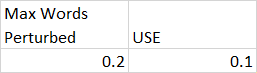

In [22]:
attack = DeepWordMaxWordsUSE.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.1
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:44,  4.92s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:06<00:27,  3.38s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.84s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (54%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crde]] prices plus worries\about the [[ecoinomy]] and the outlook for [[eGarnings]] are expected to\hang over the [[tsock]] market next [[weBek]] during the depth of the\[[suUmer]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.39s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flowKs]] from the main pipeline in southern [[graq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iol]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:10<00:10,  2.13s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (51%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[econony]] (AFP) AFP - Tearaway world oil [[prcies]], toppling records and straining wallets, present a new economic menace barely three months before the US [[presidentil]] [[electoins]].




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:12<00:08,  2.07s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (58%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) [[Reuters]] - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] End Up, But Near Year [[ows]] (Reuters) [[Reuter]] - [[tSocks]] ended slightly higher on [[Fridy]]\but stayed near [[los]] for the year as [[oi]] prices surged past  #36;[[6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [00:14<00:06,  2.01s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [00:15<00:03,  1.89s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (54%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[Fejd]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[RetaSl]] sales [[bEunced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.85s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Fopbes]].com) [[FIorbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NUW]] [[YkORK]] (Reuters) - [[Short-selers]], [[all]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.42% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 65.9   |
+---------

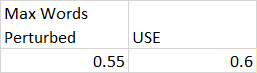

In [20]:
attack = DeepWordMaxWordsUSE.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification


  0%|          | 0/10 [1:43:05<?, ?it/s]

 10%|█         | 1/10 [00:06<01:00,  6.76s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:06<01:00,  6.77s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:09<00:37,  4.67s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:09<00:37,  4.68s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:12<00:28,  4.06s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:12<00:28,  4.06s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].





[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:13<00:19,  3.30s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:13<00:19,  3.30s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:14<00:14,  2.88s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].





[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:16<00:10,  2.70s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:16<00:10,  2.70s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)





[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:17<00:07,  2.47s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:17<00:07,  2.47s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:18<00:04,  2.31s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:18<00:04,  2.31s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:20<00:02,  2.23s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:20<00:02,  2.23s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------

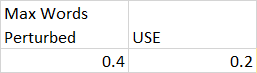

In [17]:
attack = DeepWordMaxWordsUSE.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterSubstitution(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.55
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.6
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification


 10%|█         | 1/10 [00:04<00:43,  4.82s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:04<00:43,  4.82s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) [[Reutres]] - [[Short-selles]], Wall Street's [[dwinling]]\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:07<00:29,  3.71s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:07<00:29,  3.72s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (73%)]]

[[Carlyle]] [[Looks]] [[Toward]] Commercial [[Aerospace]] (Reuters) Reuters - [[Private]] [[investment]] [[firm]] [[Carlyle]] [[Group]],\which has a reputation for [[making]] [[well-timed]] and [[occasionally]]\controversial plays in the defense industry, has quietly placed\its [[bets]] on [[another]] [[part]] of the [[market]].

[[Carlye]] [[Loioks]] [[voward]] Commercial [[Areospace]] (Reuters) Reuters - [[PrivVate]] [[invesmtent]] [[mirm]] [[CarlZle]] [[EGroup]],\which has a reputation for [[makinBg]] [[well-timde]] and [[occasionVlly]]\controversial plays in the defense industry, has quietly placed\its [[ebts]] on [[anohter]] [[purt]] of the [[mparket]].





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:10<00:24,  3.43s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.44s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (62%)]]

Oil and [[Economy]] Cloud [[Stocks']] Outlook ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the [[outlook]] for [[earnings]] are expected to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the depth of the\[[summer]] [[doldrums]].

Oil and [[EcVnomy]] Cloud [[GStocks']] Outlook ([[Reters]]) Reuters - Soaring [[crde]] prices plus worries\about the [[econmoy]] and the [[Hutlook]] for [[earnins]] are expected to\[[fhang]] over the [[stofck]] [[marekt]] [[netx]] [[wUek]] during the depth of the\[[summre]] [[doldrus]].





[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:11<00:16,  2.83s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:11<00:16,  2.83s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[lows]] from the main pipeline in southern [[raq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[il]] official said on Saturday.





[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:12<00:12,  2.51s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.51s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (73%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the US [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[SU]] [[ecFonomy]] (AFP) AFP - Tearaway world oil [[rices]], toppling records and straining wallets, present a new [[ecoanomic]] menace barely three months before the US [[presidentia]] [[evections]].





[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:14<00:09,  2.39s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.39s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (76%)]]

[[Stocks]] End Up, But Near Year [[Lows]] (Reuters) Reuters - [[Stocks]] ended slightly higher on [[Friday]]\but stayed near [[lows]] for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, [[offsetting]] a positive outlook from computer maker\Dell Inc. ([[DELL]].O)

[[Socks]] End Up, But Near Year [[Lotws]] (Reuters) Reuters - [[Stoks]] ended slightly higher on [[PFriday]]\but stayed near [[loCs]] for the year as [[il]] prices surged past  #36;[[4M]]\a barrel, [[offsetUting]] a positive outlook from computer maker\Dell Inc. ([[DELBL]].O)





[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]
[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.21s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (73%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[Latxest]] Week (AP) AP - Assets of the nation's [[rKtail]] money market [[mutuaDl]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company Institute said Thursday.





[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:16<00:04,  2.08s/it]
[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:16<00:04,  2.08s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (68%)]]

[[Fed]] [[minutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[FIed]] [[imnutes]] show dissent over inflation (USATODAY.com) USATODAY.com - [[Retial]] sales [[bouncIed]] back a bit in [[uJly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:18<00:02,  2.02s/it]
[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:18<00:02,  2.03s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (96%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[JForbes]].com) [[Forbds]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (100%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], [[Wall]] Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NEj]] [[KORK]] (Reuters) - [[Short-selleks]], [[aWll]] Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 18.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 73.1   |
+-------

Adding new constraints to InputReductionFeng
1. Levenshtein Edit Distance
2. 1 and MaxWordsPerturbed
3. 1 and Universal Sentence Encoder
4. 1,2 and 3

In [ ]:
class InputReductionLevenshtein(Attack,ABC):
    @staticmethod
    def build(model_wrapper,edit_distance):
        transformation = WordDeletion()

        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(edit_distance))
        #
        # Goal is untargeted classification
        #
        goal_function = InputReduction(model_wrapper, maximizable=True)
        #
        # "For each word in an input sentence, we measure its importance by the
        # change in the confidence of the original prediction when we remove
        # that word from the sentence."
        #
        # "Instead of looking at the words with high importance values—what
        # interpretation methods commonly do—we take a complementary approach
        # and study how the model behaves when the supposedly unimportant words are
        # removed."
        #
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
for ed in range(20,51):
    print("Starting attack for Levenshtein Edit Distance-----------------",ed)
    attack = InputReductionLevenshtein.build(model,ed)
    attacker = Attacker(attack, dataset)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]

Starting attack for Levenshtein Edit Distance----------------- 20
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  20
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.10it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.09it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall [[St]]. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] dwindling\band of ultra-cynics, are seeing green again.

Wall. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall dwindling\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:09,  1.21s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:09,  1.22s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:03<00:09,  1.31s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:03<00:09,  1.31s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.37s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.37s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (83%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main [[pipeline]] in southern [[Iraq]] after\intelligence showed [[a]] rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main in southern after\intelligence showed rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:06<00:06,  1.38s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:06<00:06,  1.38s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to US economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to US economy (AFP) - world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:08<00:05,  1.44s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:08<00:05,  1.44s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #[[36]];46\a barrel, offsetting [[a]] positive outlook from computer maker\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #;46\a barrel, offsetting positive outlook from computer maker\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.46s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.46s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the latest week to  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week (AP) - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the latest week to  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:11<00:02,  1.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com).com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:14<00:01,  1.63s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:14<00:01,  1.63s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work as the general manager at commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 73.59% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.0   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 21
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:07,  1.13it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.12it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall [[St]]. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] dwindling\band of ultra-cynics, are seeing green again.

Wall. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall dwindling\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:09,  1.25s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.25s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has [[a]] reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.37s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.37s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected [[to]]\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.43s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (80%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main [[pipeline]] in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said [[on]] Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main in southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.45s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.45s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to US economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to US economy (AFP) - world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.51s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.51s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\a barrel, offsetting [[a]] positive outlook from computer maker\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\a barrel, offsetting positive outlook from computer maker\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.54s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.54s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.com).com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.D., Danny Bazil Riley started to work the general manager at commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band [[of]] ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 72.89% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.4   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 22
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  22
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.06it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.05it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] dwindling\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall dwindling\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.30s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.30s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays [[in]] the defense industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays the defense industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.42s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.42s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected [[to]]\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.47s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.47s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main in southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.49s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to US economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, toppling records and straining wallets, present [[a]] new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to US economy (AFP) - world oil prices, toppling records and straining wallets, present new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.53s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.53s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the latest week to  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the latest week to  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.56s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.56s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net (Forbes.com) Forbes.com - After earning a PH.D., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band [[of]] ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 71.02% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.3   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 23
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  23
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.10it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.10it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] dwindling\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall dwindling\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.25s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.26s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays [[in]] the defense industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays the defense industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.37s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.37s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected [[to]]\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.42s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.42s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main in southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.43s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.43s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:08<00:05,  1.48s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:08<00:05,  1.48s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.50s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.50s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the latest week to  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the latest week to  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.52s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.52s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.67s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.67s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net (Forbes.com) Forbes.com - After earning a PH.., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of ultra-cynics, [[are]] seeing green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 76.24% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 24
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  24
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:07,  1.14it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:07,  1.13it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] dwindling\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall dwindling\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:09,  1.25s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:09,  1.25s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has [[a]] reputation for making well-timed and occasionally\controversial plays [[in]] the defense industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has reputation for making well-timed and occasionally\controversial plays the defense industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.35s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.35s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.40s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.40s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (92%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] in southern [[Iraq]] after\intelligence showed [[a]] rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main in southern after\intelligence showed rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.42s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.42s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:08<00:05,  1.47s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:08<00:05,  1.47s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.49s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.49s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the latest week to  #[[36]];849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the latest week to  #;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.51s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.51s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:14<00:01,  1.66s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:14<00:01,  1.66s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net (Forbes.com) Forbes.com - After earning a PH.., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of ultra-cynics, [[are]] seeing green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 75.47% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.9   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 25
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  25
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:07,  1.15it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:07,  1.14it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] dwindling\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall dwindling\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:09,  1.24s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:09,  1.24s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has [[a]] reputation for making well-timed and occasionally\controversial plays [[in]] the defense industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has reputation for making well-timed and occasionally\controversial plays the defense industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.35s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.35s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.40s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.40s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said [[on]] Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main in southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.43s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.43s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, toppling records and straining wallets, present [[a]] new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, toppling records and straining wallets, present new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:08<00:05,  1.48s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:08<00:05,  1.48s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\[[a]] barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\ barrel, offsetting positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.50s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.50s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the latest week [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the latest week  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.52s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.52s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.67s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.67s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.D., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of ultra-cynics, [[are]] seeing green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 75.92% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 44.1   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 26
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  26
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.08it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.07it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into [[the]] Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] dwindling\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into Black (Reuters) - Short-sellers, Wall dwindling\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.27s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.27s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has [[a]] reputation for making well-timed and occasionally\controversial plays [[in]] the defense industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has reputation for making well-timed and occasionally\controversial plays the defense industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.37s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.37s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.43s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.43s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main in southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.45s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.45s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the [[US]] presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.50s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.50s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #[[36]];46\a barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #;46\a barrel, offsetting positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.52s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the latest week [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the latest week  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.54s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.54s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].com - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com).com - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.69s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.69s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of ultra-cynics, [[are]] seeing green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 77.01% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 44.2   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 27
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  27
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.11it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.11it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:09,  1.25s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:09,  1.25s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays in the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.38s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.38s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy and the outlook for earnings are expected [[to]]\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy and the outlook for earnings are expected\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main in southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.46s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.46s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, toppling records and straining wallets, present a new economic menace barely three months before [[the]] US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, toppling records and straining wallets, present a new economic menace barely three months before US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.51s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.51s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\a barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\a barrel, offsetting positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the latest week [[to]]  #36;849.[[98]] trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the latest week  #36;849. trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.55s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].com - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com).com - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of ultra-cynics, [[are]] seeing green again.

St. Bears Claw Back Into the Black  YORK (Reuters) - Short-sellers, dwindling  band of ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 72.48% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 44.3   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 28
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  28
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.09it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.08it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.25s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.25s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays in the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.38s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.38s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.45s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] in southern [[Iraq]] after\intelligence showed [[a]] rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main in southern after\intelligence showed rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.47s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.47s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, toppling records and straining wallets, present a new economic menace barely three months before [[the]] US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, toppling records and straining wallets, present a new economic menace barely three months before US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.52s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.53s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\[[a]] barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\ barrel, offsetting positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the latest week [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the latest week  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.56s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.56s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].com - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.com).com - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.72s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.72s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.D., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of ultra-cynics, [[are]] seeing green again.

St. Bears Claw Back the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 71.73% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 44.6   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 29
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  29
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.12it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.12it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.26s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.26s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has [[a]] reputation for making well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has reputation for making well-timed and occasionally\controversial plays in the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.38s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.38s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.45s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.45s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to US economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to US economy (AFP) - world oil prices, records and straining wallets, present a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.51s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.51s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;[[46]]\a barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;\a barrel, offsetting positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.54s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the latest week [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the latest week  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.55s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.D., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of ultra-cynics, [[are]] seeing green again.

St. Bears Claw Back the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 72.13% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 44.6   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 30
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  30
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.05it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.05it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall [[St]]. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.28s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.29s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.40s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.40s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.46s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.46s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.47s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.47s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to US economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to US economy (AFP) - world oil prices, records and straining wallets, present a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.52s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.52s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;[[46]]\a barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;\a barrel, offsetting positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.55s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the latest [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the latest  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.56s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.56s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.72s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of ultra-cynics, [[are]] seeing green again.

St. Bears Claw Back the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 75.19% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 44.8   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 31
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  31
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.06it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.06it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall [[St]]. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

Wall. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.28s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.28s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.41s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.41s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected [[to]]\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.46s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.46s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.48s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.48s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to US economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present [[a]] new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to US economy (AFP) - world oil prices, records and straining wallets, present new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.53s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.53s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\a barrel, offsetting [[a]] positive outlook from computer [[maker]]\[[Dell]] [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\a barrel, offsetting positive outlook from computer\. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:10<00:04,  1.56s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:10<00:04,  1.56s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the latest [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the latest  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.57s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.57s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.73s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.73s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 69.14% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 45.0   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 32
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  32
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.07it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.06it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.29s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.30s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has [[a]] reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.42s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.42s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about [[the]] economy [[and]] the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about economy the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.48s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.48s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (93%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could strike\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.49s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, present a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.55s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\[[a]] barrel, offsetting [[a]] positive outlook from computer [[maker]]\[[Dell]] [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\ barrel, offsetting positive outlook from computer\. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.57s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.57s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the latest [[week]] [[to]]  #36;849.[[98]] trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the latest  #36;849. trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.59s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.59s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.74s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.74s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.D., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 68.33% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 45.4   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 33
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  33
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.08it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.07it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.29s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.29s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has [[a]] reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.41s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.42s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang [[over]] the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.47s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.47s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (93%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could strike\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.49s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, present a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.55s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;[[46]]\a barrel, offsetting [[a]] positive outlook from computer [[maker]]\[[Dell]] [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;\a barrel, offsetting positive outlook from computer\. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.57s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.57s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the latest [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the latest  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.59s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.59s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.74s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.74s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 68.33% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 45.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 34
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  34
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.05it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.05it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.30s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.30s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has [[a]] reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\which has reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.42s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.42s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang [[over]] the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.48s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.48s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (93%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could strike\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.50s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.50s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present [[a]] new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, present new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.55s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but [[stayed]] near lows for the year [[as]] oil prices surged past  #36;46\a barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but near lows for the year oil prices surged past  #36;46\a barrel, offsetting positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.58s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.58s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the latest [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the latest  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.59s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.59s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.75s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.75s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest thing from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest thing from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band [[of]] [[ultra-cynics]], [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 67.59% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 45.7   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 35
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  35
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.07it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.07it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.29s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.29s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\[[which]] has a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\ has a reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:09,  1.41s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:09,  1.42s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and Economy [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang [[over]] the stock market next week during the depth of the\summer doldrums.

and Economy Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.48s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.49s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (93%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, [[an]] oil official said [[on]] Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could strike\infrastructure, oil official said Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.50s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.50s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present [[a]] new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, present new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.56s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.56s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but [[stayed]] near lows for the year [[as]] oil prices surged past  #36;46\a barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but near lows for the year oil prices surged past  #36;46\a barrel, offsetting positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.58s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.58s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the latest [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the latest  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.60s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.60s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.75s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.75s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.D., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band [[of]] [[ultra-cynics]], [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 67.23% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 45.8   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 36
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  36
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.02it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.01it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into [[the]] Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.31s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.32s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) [[Reuters]] - Private investment firm [[Carlyle]] Group,\[[which]] has a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) - Private investment firm Group,\ has a reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.43s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.43s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.49s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.49s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (90%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.51s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.51s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present [[a]] new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, present new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.57s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.57s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but [[stayed]] near lows for the year [[as]] oil prices surged past  #36;46\[[a]] barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but near lows for the year oil prices surged past  #36;46\ barrel, offsetting positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.60s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.60s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell [[in]] Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the latest [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the latest  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.61s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.61s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and [[new]] [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back a bit in July, and for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.77s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.77s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] seeing green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 72.47% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 46.1   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 37
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  37
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.02it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.02it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.31s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.31s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.43s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.43s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.49s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.49s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (90%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.51s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.51s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present [[a]] new economic menace barely three months before the [[US]] presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, present new economic menace barely three months before the presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.58s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.58s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but [[stayed]] near lows for the year [[as]] oil prices surged past  #[[36]];46\a barrel, offsetting [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but near lows for the year oil prices surged past  #;46\a barrel, offsetting positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.60s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.60s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the [[latest]] [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.61s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.61s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the [[economy]] is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.76s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.76s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work as the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work as the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] seeing green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 72.44% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 46.0   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 38
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  38
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.03it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.03it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back the Black (Reuters) - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.31s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.31s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.43s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.43s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:05<00:08,  1.49s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:05<00:08,  1.49s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (90%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.51s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.51s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

[[Oil]] prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present [[a]] new economic menace barely three months before the US presidential elections.

prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, present new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.56s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.56s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\a barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\a barrel, positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.59s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.59s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the [[latest]] [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.60s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.60s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the [[economy]] is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:15<00:01,  1.75s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:15<00:01,  1.75s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.D., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] seeing green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 75.14% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 45.8   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 39
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  39
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.02it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.01it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (96%)]]

[[Wall]] St. Bears Claw Back Into the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.33s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.33s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has [[a]] reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which has reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.46s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.46s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected [[to]]\hang over the stock market next week during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected\hang over the stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.52s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.52s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (93%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.53s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.54s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

[[Oil]] prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, present [[a]] new economic menace barely three months before the US presidential elections.

prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, present new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.59s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.59s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\a barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\a barrel, positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.61s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.61s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in the [[latest]] [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion in the  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.62s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.62s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, indicating the [[economy]] is improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, indicating the is improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.78s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.78s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.70s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] seeing green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 74.12% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 46.4   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 40
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  40
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.03it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.02it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (96%)]]

[[Wall]] St. Bears Claw Back Into the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.33s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.33s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, has quietly placed\[[its]] bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays the industry, has quietly placed\ bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.45s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.45s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over [[the]] stock market next week during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.51s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.51s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (93%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.52s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.53s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.59s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.59s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\[[a]] barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\ barrel, positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.61s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.61s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.62s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.62s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.78s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.78s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] seeing green again.

St. Bears Claw Back Into the Black  YORK (Reuters) - Short-sellers, dwindling  band of, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 70.96% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 46.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 41
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  41
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:00<00:08,  1.02it/s]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:08,  1.02it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (96%)]]

[[Wall]] St. Bears Claw Back Into the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.33s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.34s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, [[has]] quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays the industry, quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.46s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.46s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over [[the]] stock market next week during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.52s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.52s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (93%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.53s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.53s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.59s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.59s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;[[46]]\a barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;\a barrel, positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.61s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.62s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:12<00:03,  1.62s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:12<00:03,  1.62s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy is improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy is improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.78s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.79s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning [[a]] PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning PH.., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] seeing green again.

St. Bears Claw Back the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 70.82% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 46.6   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 42
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  42
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:01<00:09,  1.02s/it]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:09,  1.03s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (92%)]]

[[Wall]] St. Bears Claw Back Into the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band [[of]] ultra-cynics, are seeing green again.

St. Bears Claw Back Into the Black () - Short-sellers, Wall\band ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.35s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:10,  1.36s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, [[has]] quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays the industry, quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.47s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.47s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over [[the]] stock market next week during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.54s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.54s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (93%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said [[on]] Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.55s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, a new economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.60s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.61s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;[[46]]\a barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;\a barrel, positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.63s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.63s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #[[36]];849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the  #;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.65s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.65s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy is improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy is improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped [[by]] his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.73s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] seeing green again.

St. Bears Claw Back the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 69.83% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 47.0   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 43
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  43
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:01<00:09,  1.03s/it]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:09,  1.03s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (89%)]]

[[Wall]] St. Bears Claw Back Into [[the]] Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back Into Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:11,  1.38s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:11,  1.38s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has [[a]] reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, [[has]] quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which has reputation for making well-timed and occasionally\controversial plays the industry, quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.50s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.50s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected [[to]]\hang over [[the]] stock market next week during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected\hang over stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.56s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.56s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (95%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted [[oil]] export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.57s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.57s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] a new economic menace barely three months before the [[US]] presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, a new economic menace barely three months before the presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows [[for]] the year [[as]] oil prices surged past  #36;46\a barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows the year oil prices surged past  #36;46\a barrel, positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.65s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.65s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #[[36]];849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the  #;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.66s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.66s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy [[is]] improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - After earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped [[by]] his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - After earning a PH.., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] [[seeing]] green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 69.03% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 47.3   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 44
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  44
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:01<00:09,  1.02s/it]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:09,  1.03s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (87%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back the Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.37s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:11,  1.38s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which has a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, [[has]] quietly placed\its bets [[on]] another part [[of]] the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which has a reputation for making well-timed and occasionally\controversial plays the industry, quietly placed\its bets another part the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.50s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.50s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected [[to]]\hang over [[the]] stock market next week during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected\hang over stock market next week during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.56s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.56s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (87%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\[[flows]] from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\ from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.57s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.57s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] a [[new]] economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, a economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged [[past]]  #36;46\a barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged  #36;46\a barrel, positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.65s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.65s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #[[36]];849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the  #;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.66s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.66s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy [[is]] improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - [[After]] earning a PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - earning a PH.D., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] [[seeing]] green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 69.17% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 47.2   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 45
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  45
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:01<00:09,  1.02s/it]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:09,  1.02s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (87%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back the Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:10,  1.37s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:11,  1.38s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which [[has]] a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, [[has]] quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which a reputation for making well-timed and occasionally\controversial plays the industry, quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.50s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.50s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over [[the]] stock market next [[week]] during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over stock market next during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.56s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.56s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (87%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have halted oil export\[[flows]] from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have halted oil export\ from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.57s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.57s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] a [[new]] economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, a economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.62s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but [[stayed]] near lows for the year [[as]] oil prices surged past  #36;46\a barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but near lows for the year oil prices surged past  #36;46\a barrel, positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.65s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.65s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell [[in]] Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #[[36]];849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the  #;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.66s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.66s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.com) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy [[is]] improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.com). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - [[After]] earning a PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - earning a PH.., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] [[seeing]] green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 69.54% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 47.4   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 46
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  46
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:01<00:09,  1.06s/it]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:09,  1.06s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (87%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back the Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:11,  1.39s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:11,  1.40s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which [[has]] a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, [[has]] quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which a reputation for making well-timed and occasionally\controversial plays the industry, quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.51s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.51s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over [[the]] stock market next [[week]] during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over stock market next during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.57s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.57s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have [[halted]] oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.58s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.58s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] a [[new]] economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, a economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.63s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but [[stayed]] near lows for the year [[as]] oil prices surged past  #36;46\a barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but near lows for the year oil prices surged past  #36;46\a barrel, positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.66s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.66s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell [[in]] Latest Week ([[AP]]) [[AP]] - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #[[36]];849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell Latest Week () - Assets of the nation's retail money market mutual funds by  #36;.17 billion the  #;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.67s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.68s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy [[is]] improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.83s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.83s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - [[After]] earning [[a]] PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - earning PH.D., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] [[seeing]] green again.

St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 69.55% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 47.6   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 47
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  47
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:01<00:09,  1.06s/it]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:09,  1.06s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (87%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back the Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:11,  1.39s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:11,  1.40s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which [[has]] a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, [[has]] quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which a reputation for making well-timed and occasionally\controversial plays the industry, quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.51s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.51s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over [[the]] stock market next [[week]] during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over stock market next during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.57s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.57s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have [[halted]] oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.58s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.58s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar [[to]] all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] a [[new]] economic menace barely three months before the US presidential elections.

Oil prices soar all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, a economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.64s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.64s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but [[stayed]] near lows for the year [[as]] oil prices surged past  #[[36]];46\a barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but near lows for the year oil prices surged past  #;46\a barrel, positive outlook from computer\Dell. (.O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:04,  1.66s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:04,  1.66s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's [[retail]] money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's money market mutual funds by  #36;.17 billion the  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.67s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.67s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy [[is]] improving from a midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy improving from a midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.83s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.83s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - [[After]] earning [[a]] PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - earning PH.., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.76s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] [[seeing]] green again.

St. Bears Claw Back Into the Black  YORK (Reuters) - Short-sellers, dwindling  band of, green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 69.28% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 47.8   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 48
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  48
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:01<00:09,  1.06s/it]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:09,  1.06s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (87%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Claw Back the Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:11,  1.41s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:11,  1.42s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which [[has]] a reputation for making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, [[has]] quietly placed\its bets [[on]] another part [[of]] the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which a reputation for making well-timed and occasionally\controversial plays the industry, quietly placed\its bets another part the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.53s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.53s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over [[the]] stock market next [[week]] during the depth [[of]] the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over stock market next during the depth the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.60s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.60s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have [[halted]] oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed [[a]] rebel militia could [[strike]]\infrastructure, [[an]] oil official said on Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have oil export\flows from the main southern after\intelligence showed rebel militia could\infrastructure, oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.61s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.61s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

[[Oil]] prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] a [[new]] economic menace barely three months before the US presidential elections.

prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, a economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:09<00:06,  1.66s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:09<00:06,  1.66s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but [[stayed]] near lows for the year [[as]] oil prices surged past  #[[36]];46\a barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but near lows for the year oil prices surged past  #;46\a barrel, positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:05,  1.68s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:05,  1.68s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's [[retail]] money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's money market mutual funds by  #36;.17 billion the  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.69s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.69s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy [[is]] improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.85s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.85s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - [[After]] earning [[a]] PH.[[D]]. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - earning PH.., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] [[seeing]] green again.

St. Bears Claw Back the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 68.57% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 48.3   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 49
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  49
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:01<00:09,  1.10s/it]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:09,  1.11s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

[[Wall]] St. Bears [[Claw]] Back [[Into]] the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Bears Back the Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:11,  1.44s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:11,  1.44s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which [[has]] a reputation [[for]] making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, [[has]] quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which a reputation making well-timed and occasionally\controversial plays the industry, quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.55s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over [[the]] stock market next [[week]] during the depth [[of]] the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over stock market next during the depth the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.61s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.61s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have [[halted]] oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said [[on]] Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.62s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.62s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

[[Oil]] prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] a [[new]] economic menace barely three months before the US presidential elections.

prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, a economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:10<00:06,  1.67s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:10<00:06,  1.67s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but [[stayed]] near lows for the year [[as]] oil prices surged past  #[[36]];46\[[a]] barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but near lows for the year oil prices surged past  #;46\ barrel, positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:05,  1.70s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:05,  1.70s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's [[retail]] money market mutual funds [[fell]] by  #[[36]];[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's money market mutual funds by  #;.17 billion the  #36;849.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.71s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.71s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back a bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy [[is]] improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back a bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.87s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.87s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - [[After]] earning [[a]] PH.D. [[in]] [[Sociology]], Danny Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped [[by]] his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - earning PH.D., Danny Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] [[seeing]] green again.

St. Bears Claw Back the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 67.86% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 48.6   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.



  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 50
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  50
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:01<00:09,  1.10s/it]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:09,  1.11s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (90%)]]

[[Wall]] St. [[Bears]] Claw Back [[Into]] the Black ([[Reuters]]) [[Reuters]] - Short-sellers, Wall [[Street's]] [[dwindling]]\band of ultra-cynics, are seeing green again.

St. Claw Back the Black () - Short-sellers, Wall\band of ultra-cynics, are seeing green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:02<00:11,  1.44s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:02<00:11,  1.44s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace ([[Reuters]]) [[Reuters]] - Private investment firm [[Carlyle]] Group,\which [[has]] a reputation [[for]] making well-timed and occasionally\controversial plays [[in]] the [[defense]] industry, [[has]] quietly placed\its bets [[on]] another part of the market.

Carlyle Looks Toward Commercial Aerospace () - Private investment firm Group,\which a reputation making well-timed and occasionally\controversial plays the industry, quietly placed\its bets another part of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:04<00:10,  1.55s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:04<00:10,  1.55s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Oil]] and [[Economy]] [[Cloud]] Stocks' Outlook (Reuters) [[Reuters]] - Soaring [[crude]] prices plus worries\about the economy [[and]] the outlook for earnings are expected to\hang over [[the]] stock market [[next]] [[week]] during the depth of the\summer doldrums.

and Stocks' Outlook (Reuters) - Soaring prices plus worries\about the economy the outlook for earnings are expected to\hang over stock market during the depth of the\summer doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.61s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.61s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (91%)]]

Iraq Halts [[Oil]] Exports from Main Southern Pipeline (Reuters) [[Reuters]] - Authorities have [[halted]] oil export\flows from the main [[pipeline]] [[in]] southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, [[an]] oil official said [[on]] Saturday.

Iraq Halts Exports from Main Southern Pipeline (Reuters) - Authorities have oil export\flows from the main southern after\intelligence showed a rebel militia could\infrastructure, oil official said Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:08<00:08,  1.62s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:08<00:08,  1.62s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

[[Oil]] prices soar to all-time record, posing new [[menace]] to [[US]] economy (AFP) [[AFP]] - [[Tearaway]] world oil prices, [[toppling]] records and straining wallets, [[present]] [[a]] [[new]] economic menace barely three months before the US presidential elections.

prices soar to all-time record, posing new to economy (AFP) - world oil prices, records and straining wallets, economic menace barely three months before the US presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:10<00:06,  1.68s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:10<00:06,  1.68s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) [[Reuters]] - Stocks ended slightly higher on Friday\but [[stayed]] near lows for the year [[as]] oil prices surged past  #[[36]];46\[[a]] barrel, [[offsetting]] [[a]] positive outlook from computer [[maker]]\Dell [[Inc]]. ([[DELL]].[[O]])

Stocks End Up, But Near Year Lows (Reuters) - Stocks ended slightly higher on Friday\but near lows for the year oil prices surged past  #;46\ barrel, positive outlook from computer\Dell. (.)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:11<00:05,  1.70s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:11<00:05,  1.71s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week ([[AP]]) [[AP]] - Assets of the nation's [[retail]] money market mutual funds [[fell]] by  #36;[[1]].17 billion [[in]] the [[latest]] [[week]] [[to]]  #36;[[849]].98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week () - Assets of the nation's money market mutual funds by  #36;.17 billion the  #36;.98 trillion, the Company Institute said Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:13<00:03,  1.72s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:13<00:03,  1.72s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over [[inflation]] (USATODAY.[[com]]) [[USATODAY]].[[com]] - Retail sales bounced back [[a]] bit in July, and new [[claims]] for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy [[is]] improving from [[a]] midsummer slump.

Fed minutes show dissent over (USATODAY.). - Retail sales bounced back bit in July, and new for jobless benefits fell last week, the government said Thursday, the economy improving from midsummer slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:16<00:01,  1.87s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:16<00:01,  1.87s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.[[com]]) Forbes.com - [[After]] earning a PH.D. [[in]] [[Sociology]], [[Danny]] Bazil Riley started to work [[as]] the general manager at [[a]] commercial real [[estate]] firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was [[the]] furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.) Forbes.com - earning a PH.D., Bazil Riley started to work the general manager at commercial real firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was furthest from my mind," says Riley.







[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

[[Wall]] St. Bears Claw Back [[Into]] the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band of [[ultra-cynics]], [[are]] [[seeing]] green again.

St. Bears Claw Back the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band of, green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 67.21% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 48.7   |
+-------------------------------+--------+


In [28]:
class InputReductionLevMaxWords(Attack,ABC):
    @staticmethod
    def build(model_wrapper,max):
        transformation = WordDeletion()

        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(21))
        constraints.append(MaxWordsPerturbed(max_percent=max))
        #
        # Goal is untargeted classification
        #
        goal_function = InputReduction(model_wrapper, maximizable=True)
        #
        # "For each word in an input sentence, we measure its importance by the
        # change in the confidence of the original prediction when we remove
        # that word from the sentence."
        #
        # "Instead of looking at the words with high importance values—what
        # interpretation methods commonly do—we take a complementary approach
        # and study how the model behaves when the supposedly unimportant words are
        # removed."
        #
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [30]:
for max_percent in np.arange(0.1, 0.6, 0.05).tolist():
    print("Starting attack with maximum percentage of words allowed to be altered as-----------------",max_percent)
    attack = InputReductionLevMaxWords.build(model,max_percent)
    attacker = Attacker(attack, dataset)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Starting attack with maximum percentage of words allowed to be altered as----------------- 0.1
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.1
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  2.05it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (96%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.48it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\[[its]] bets [[on]] another [[part]] [[of]] the [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\ bets another the.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.38it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the [[depth]] [[of]] the\summer [[doldrums]].

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the the\summer.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:03<00:04,  1.33it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (77%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official [[said]] [[on]] [[Saturday]].

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an official.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (99%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months [[before]] the [[US]] presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months the presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from maker\. (.O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.28it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the [[Investment]] Company [[Institute]] said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Company said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.26it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating [[the]] economy [[is]] improving from [[a]] midsummer [[slump]].

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating economy improving from midsummer.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.15it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance [[was]] the furthest thing [[from]] my [[mind]]," [[says]] Riley.

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance the furthest thing my," Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, [[are]] seeing [[green]] [[again]].

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, seeing.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 6.3%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 42.8   |
+-------------------------------+--------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.15000000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.15000000000000002
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  1.94it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (98%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band [[of]] ultra-cynics, [[are]] [[seeing]] green [[again]].

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band ultra-cynics, green.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.48it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its [[bets]] on another part [[of]] [[the]] [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its on another part.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.37it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week [[during]] the [[depth]] [[of]] [[the]]\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:03<00:04,  1.33it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (77%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official [[said]] on [[Saturday]].

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could\infrastructure, an oil official on.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.32it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (99%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely [[three]] months [[before]] the [[US]] presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely months the presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from maker\. (.O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.27it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the [[Investment]] Company [[Institute]] said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Company said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.26it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating [[the]] economy [[is]] improving from [[a]] midsummer [[slump]].

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating economy improving from midsummer.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.14it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at [[32]], "buying insurance was [[the]] furthest thing from [[my]] mind," [[says]] [[Riley]].

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at, "buying insurance was furthest thing from mind,".




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, [[are]] seeing [[green]] [[again]].

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, seeing.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 8.65%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.1   |
+-------------------------------+--------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.20000000000000004
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.20000000000000004
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  1.94it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (98%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band [[of]] ultra-cynics, [[are]] [[seeing]] green [[again]].

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band ultra-cynics, green.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.47it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, [[has]] quietly placed\its [[bets]] on another part of [[the]] [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, quietly placed\its on another part of.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.38it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock [[market]] next week [[during]] the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock next week the depth of the\ doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:02<00:04,  1.34it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (77%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official [[said]] on [[Saturday]].

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could\infrastructure, an oil official on.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (99%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic [[menace]] [[barely]] three months [[before]] the US presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic three months the US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. ([[DELL]].O)

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from maker\. (.O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.28it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the [[Investment]] Company [[Institute]] said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Company said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.27it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, [[indicating]] the economy is improving from a [[midsummer]] slump.

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, the economy is improving from a slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.15it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, [[at]] 32, "[[buying]] insurance was the furthest thing from [[my]] mind," says [[Riley]].

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, 32, " insurance was the furthest thing from mind," says.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  [[band]] [[of]] ultra-cynics, are [[seeing]] [[green]] again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  ultra-cynics, are again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 13.25% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 42.8   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.25000000000000006
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.25000000000000006
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  1.95it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (98%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band [[of]] ultra-cynics, [[are]] [[seeing]] green [[again]].

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band ultra-cynics, green.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.47it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, [[has]] quietly placed\its [[bets]] on another part of [[the]] [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, quietly placed\its on another part of.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.36it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang [[over]] [[the]] stock market [[next]] week [[during]] the depth of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang stock market week the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:03<00:04,  1.32it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (75%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a [[rebel]] militia could strike\infrastructure, [[an]] oil official said [[on]] [[Saturday]].

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a militia could strike\infrastructure, oil official said.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.31it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (99%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic [[menace]] [[barely]] three months [[before]] the US presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic three months the US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.26it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #[[36]];46\[[a]] barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. (DELL.[[O]])

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #;46\ barrel, offsetting a positive outlook from maker\. (DELL.)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.26it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the [[Investment]] Company [[Institute]] said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Company said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.25it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the [[government]] [[said]] Thursday, indicating [[the]] economy is improving from a midsummer slump.

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the Thursday, indicating economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.14it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, [[at]] 32, "[[buying]] insurance was the furthest thing from [[my]] mind," says [[Riley]].

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, 32, " insurance was the furthest thing from mind," says.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's [[dwindling]]  [[band]] [[of]] ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's  ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 17.38% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.2   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.30000000000000004
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.30000000000000004
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  1.95it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (98%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band [[of]] ultra-cynics, [[are]] [[seeing]] green [[again]].

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band ultra-cynics, green.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.48it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, [[has]] quietly placed\its [[bets]] on another part of [[the]] [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, quietly placed\its on another part of.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.37it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\[[hang]] over [[the]] stock market [[next]] week [[during]] the depth of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\ over stock market week the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:03<00:04,  1.33it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (74%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence [[showed]] a [[rebel]] militia [[could]] strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence a militia strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.32it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (99%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present [[a]] new economic menace [[barely]] [[three]] months before [[the]] US presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present new economic menace months before US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.26it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #[[36]];46\[[a]] barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. (DELL.[[O]])

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #;46\ barrel, offsetting a positive outlook from maker\. (DELL.)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.26it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the [[Investment]] Company [[Institute]] said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Company said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.24it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, [[the]] government [[said]] [[Thursday]], indicating the economy [[is]] improving from a midsummer slump.

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, government, indicating the economy improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.13it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk [[to]] drop off brochures about insurance benefits available through his employer. But, [[at]] 32, "[[buying]] insurance was the furthest thing from [[my]] mind," says [[Riley]].

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk drop off brochures about insurance benefits available through his employer. But, 32, " insurance was the furthest thing from mind," says.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's [[dwindling]]  [[band]] [[of]] ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's  ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 20.51% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.4   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.3500000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.3500000000000001
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  2.04it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall [[Street's]] dwindling\[[band]] of ultra-cynics, are [[seeing]] green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall dwindling\ of ultra-cynics, are green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.51it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial [[plays]] [[in]] the defense industry, has quietly placed\its [[bets]] on another part of the [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial the defense industry, has quietly placed\its on another part of the.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.39it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\[[hang]] over [[the]] stock market [[next]] week [[during]] the depth of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\ over stock market week the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:02<00:04,  1.34it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (74%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence [[showed]] a [[rebel]] militia [[could]] strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence a militia strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (99%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining [[wallets]], present [[a]] new economic menace [[barely]] three months before [[the]] US presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining, present new economic menace three months before US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.27it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #[[36]];46\[[a]] barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. (DELL.[[O]])

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #;46\ barrel, offsetting a positive outlook from maker\. (DELL.)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.26it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion [[in]] the [[latest]] week to  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion the week to  #36;849.98 trillion, the Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.24it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, [[the]] government [[said]] [[Thursday]], indicating the economy [[is]] improving from a midsummer slump.

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, government, indicating the economy improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.13it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk [[to]] drop off brochures about insurance benefits available through his employer. But, [[at]] 32, "[[buying]] insurance was the furthest thing from [[my]] mind," says [[Riley]].

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk drop off brochures about insurance benefits available through his employer. But, 32, " insurance was the furthest thing from mind," says.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band [[of]] ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 27.11% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.40000000000000013
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.40000000000000013
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  2.04it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, [[Wall]] [[Street's]] dwindling\band of ultra-cynics, are seeing [[green]] again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, dwindling\band of ultra-cynics, are seeing again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.51it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial [[plays]] [[in]] the defense industry, has quietly placed\its [[bets]] on another part of the [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial the defense industry, has quietly placed\its on another part of the.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.39it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are [[expected]] [[to]]\hang over the stock market next [[week]] during [[the]] depth of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are\hang over the stock market next during depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:02<00:04,  1.34it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (74%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence [[showed]] a [[rebel]] militia [[could]] strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence a militia strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.32it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (99%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining [[wallets]], present [[a]] new economic menace [[barely]] three months before [[the]] US presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining, present new economic menace three months before US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.27it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\[[a]] barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. (DELL.O)

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\ barrel, offsetting a positive outlook from maker\. (DELL.O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.26it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;[[1]].[[17]] billion [[in]] the latest week [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;. billion the latest week  #36;849.98 trillion, the Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.24it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, [[the]] government [[said]] [[Thursday]], indicating the economy [[is]] improving from a midsummer slump.

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, government, indicating the economy improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.13it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, [[a]] financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, [[at]] 32, "[[buying]] insurance was the furthest thing from [[my]] mind," says [[Riley]].

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, 32, " insurance was the furthest thing from mind," says.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band [[of]] ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 30.78% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.6   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.45000000000000007
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.45000000000000007
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  2.04it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black ([[Reuters]]) Reuters - Short-sellers, [[Wall]] [[Street's]] dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black () Reuters - Short-sellers, dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.50it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial [[plays]] [[in]] the defense industry, has quietly placed\its [[bets]] on another part of the [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial the defense industry, has quietly placed\its on another part of the.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.40it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\[[hang]] over the stock market next week during the [[depth]] of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for are expected to\ over the stock market next week during the of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:02<00:04,  1.35it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (82%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in [[southern]] Iraq after\intelligence showed [[a]] rebel [[militia]] could strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in Iraq after\intelligence showed rebel could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling [[records]] and straining wallets, present [[a]] [[new]] economic menace barely [[three]] months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling and straining wallets, present economic menace barely months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\[[a]] barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. (DELL.O)

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\ barrel, offsetting a positive outlook from maker\. (DELL.O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.26it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #[[36]];1.[[17]] billion [[in]] the latest week [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #;1. billion the latest week  #36;849.98 trillion, the Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.24it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, [[the]] government [[said]] [[Thursday]], indicating the economy [[is]] improving from a midsummer slump.

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, government, indicating the economy improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.13it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,[[000]]. Soon after, a financial planner stopped by his desk [[to]] drop off brochures about insurance benefits available through his employer. But, [[at]] 32, "[[buying]] insurance was the furthest [[thing]] from my mind," says Riley.

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,. Soon after, a financial planner stopped by his desk drop off brochures about insurance benefits available through his employer. But, 32, " insurance was the furthest from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band [[of]] ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 34.82% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.5000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.5000000000000001
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  2.04it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] dwindling\band of ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall dwindling\band of ultra-cynics, seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.50it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial [[plays]] [[in]] the defense industry, has quietly placed\its [[bets]] on another part of the [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial the defense industry, has quietly placed\its on another part of the.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.40it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\[[hang]] over the stock market next week during the [[depth]] of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for are expected to\ over the stock market next week during the of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:02<00:04,  1.34it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (81%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from [[the]] main [[pipeline]] in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said [[on]] Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from main in southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (99%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, [[toppling]] records [[and]] straining wallets, present a new economic menace barely three [[months]] before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, records straining wallets, present a new economic menace barely three before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\[[a]] barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. (DELL.O)

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\ barrel, offsetting a positive outlook from maker\. (DELL.O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.27it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds [[fell]] by  #36;[[1]].17 billion in [[the]] latest week to  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds by  #36;.17 billion in latest week to  #36;849.98 trillion, the Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.25it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, [[the]] government [[said]] [[Thursday]], indicating the economy [[is]] improving from a midsummer slump.

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, government, indicating the economy improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.13it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;[[70]],[[000]]. Soon after, [[a]] financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, [[at]] 32, "[[buying]] insurance was the furthest thing [[from]] my mind," says Riley.

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;,. Soon after, financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, 32, " insurance was the furthest thing my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band [[of]] ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 36.96% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.5500000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.5500000000000002
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  2.04it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black (Reuters) [[Reuters]] - Short-sellers, Wall [[Street's]] dwindling\band of ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) - Short-sellers, Wall dwindling\band of ultra-cynics, seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.50it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial [[plays]] [[in]] the defense industry, has quietly placed\its [[bets]] on another part of the [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial the defense industry, has quietly placed\its on another part of the.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.40it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\[[hang]] over the stock market next week during the [[depth]] of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for are expected to\ over the stock market next week during the of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:03<00:04,  1.31it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (81%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from [[the]] main [[pipeline]] in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an oil official said [[on]] Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from main in southern after\intelligence showed a rebel militia could strike\infrastructure, an oil official said Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.29it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (100%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway [[world]] oil prices, toppling [[records]] and straining wallets, present a new economic menace barely three [[months]] before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway oil prices, toppling and straining wallets, present a new economic menace barely three before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.23it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\[[a]] barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. (DELL.O)

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\ barrel, offsetting a positive outlook from maker\. (DELL.O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.23it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual [[funds]] fell [[by]]  #36;[[1]].17 billion in the latest week to  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual fell  #36;.17 billion in the latest week to  #36;849.98 trillion, the Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.22it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, [[and]] new claims for jobless benefits [[fell]] last week, the [[government]] said Thursday, indicating the economy is improving from a midsummer slump.

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, new claims for jobless benefits last week, the said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:08<00:00,  1.11it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;[[70]],[[000]]. Soon after, [[a]] financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, [[at]] 32, "[[buying]] insurance was the furthest thing [[from]] my mind," says Riley.

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;,. Soon after, financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, 32, " insurance was the furthest thing my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band [[of]] ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 40.55% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.4   |
+-------------------------------+--------+

In [27]:
attack = InputReductionLevMaxWords.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:00<00:04,  1.94it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, [[Wall]] [[Street's]] dwindling\band of ultra-cynics, are seeing [[green]] again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, dwindling\band of ultra-cynics, are seeing again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:01<00:05,  1.48it/s]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial [[plays]] [[in]] the defense industry, has quietly placed\its [[bets]] on another part of the [[market]].

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial the defense industry, has quietly placed\its on another part of the.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:02<00:05,  1.37it/s]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are [[expected]] [[to]]\hang over the stock market next [[week]] during [[the]] depth of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are\hang over the stock market next during depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:02<00:04,  1.33it/s]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[Business (74%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence [[showed]] a [[rebel]] militia [[could]] strike\infrastructure, an oil official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence a militia strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:03<00:03,  1.32it/s]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Business (99%)]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining [[wallets]], present [[a]] new economic menace [[barely]] three months before [[the]] US presidential elections.

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining, present new economic menace three months before US presidential elections.




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:04<00:03,  1.27it/s]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year [[as]] oil prices surged past  #36;46\[[a]] barrel, offsetting a positive outlook from [[computer]] maker\[[Dell]] [[Inc]]. (DELL.O)

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year oil prices surged past  #36;46\ barrel, offsetting a positive outlook from maker\. (DELL.O)




[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:05<00:02,  1.25it/s]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;[[1]].[[17]] billion [[in]] the latest week [[to]]  #36;849.98 trillion, the [[Investment]] Company Institute said Thursday.

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;. billion the latest week  #36;849.98 trillion, the Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:06<00:01,  1.24it/s]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, [[the]] government [[said]] [[Thursday]], indicating the economy [[is]] improving from a midsummer slump.

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, government, indicating the economy improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:07<00:00,  1.13it/s]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, [[a]] financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, [[at]] 32, "[[buying]] insurance was the furthest thing from [[my]] mind," says [[Riley]].

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, 32, " insurance was the furthest thing from mind," says.




[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[Business (100%)]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, [[Wall]] [[Street's]] dwindling  band [[of]] ultra-cynics, [[are]] seeing green again.

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, dwindling  band ultra-cynics, seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 30.78% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 43.6   |
+-------------------------------+--------+

In [37]:
class InputReductionLevUSE(Attack,ABC):
    @staticmethod
    def build(model_wrapper):
        transformation = WordDeletion()

        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(21))
        use_constraint = UniversalSentenceEncoder(
          threshold=0.5,
          metric="cosine",
          compare_against_original=True,
          window_size=None,
        )
        constraints.append(use_constraint)
        #
        # Goal is untargeted classification
        #
        goal_function = InputReduction(model_wrapper, maximizable=True)
        #
        # "For each word in an input sentence, we measure its importance by the
        # change in the confidence of the original prediction when we remove
        # that word from the sentence."
        #
        # "Instead of looking at the words with high importance values—what
        # interpretation methods commonly do—we take a complementary approach
        # and study how the model behaves when the supposedly unimportant words are
        # removed."
        #
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [38]:
attack = InputReductionLevUSE.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.

  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.5
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



StopIteration: ignored

In [43]:
class InputReductionLevMwUSE(Attack,ABC):
    @staticmethod
    def build(model_wrapper):
        transformation = WordDeletion()

        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(21))
        constraints.append(MaxWordsPerturbed(max_percent=0.4))
        use_constraint = UniversalSentenceEncoder(
          threshold=0.4,
          metric="cosine",
          compare_against_original=True,
          window_size=None,
        )
        constraints.append(use_constraint)
        #
        # Goal is untargeted classification
        #
        goal_function = InputReduction(model_wrapper, maximizable=True)
        #
        # "For each word in an input sentence, we measure its importance by the
        # change in the confidence of the original prediction when we remove
        # that word from the sentence."
        #
        # "Instead of looking at the words with high importance values—what
        # interpretation methods commonly do—we take a complementary approach
        # and study how the model behaves when the supposedly unimportant words are
        # removed."
        #
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [44]:
attack = InputReductionLevMwUSE.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.input_reduction.InputReduction'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  InputReduction(
    (maximizable):  True
  )
  (transformation):  WordDeletion
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



StopIteration: ignored

In [ ]:

class Recipe3(Attack,ABC):
    @staticmethod
    def build(model_wrapper,edit_distance):
       # Candidate size K is set to 48 for all data-sets.
        transformation = WordSwapMaskedLM(method="bert-attack", max_candidates=48)
        #
        # Don't modify the same word twice or stopwords.
        #
        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(edit_distance))
        # "We only take ε percent of the most important words since we tend to keep
        # perturbations minimum."
        #
        # [from correspondence with the author]
        # "Word percentage allowed to change is set to 0.4 for most data-sets, this
        # parameter is trivial since most attacks only need a few changes. This
        # epsilon is only used to avoid too much queries on those very hard samples."
        constraints.append(MaxWordsPerturbed(max_percent=0.4))

        # "As used in TextFooler (Jin et al., 2019), we also use Universal Sentence
        # Encoder (Cer et al., 2018) to measure the semantic consistency between the
        # adversarial sample and the original sequence. To balance between semantic
        # preservation and attack success rate, we set up a threshold of semantic
        # similarity score to filter the less similar examples."
        #
        # [from correspondence with author]
        # "Over the full texts, after generating all the adversarial samples, we filter
        # out low USE score samples. Thus the success rate is lower but the USE score
        # can be higher. (actually USE score is not a golden metric, so we simply
        # measure the USE score over the final texts for a comparison with TextFooler).
        # For datasets like IMDB, we set a higher threshold between 0.4-0.7; for
        # datasets like MNLI, we set threshold between 0-0.2."
        #
        # Since the threshold in the real world can't be determined from the training
        # data, the TextAttack implementation uses a fixed threshold - determined to
        # be 0.2 to be most fair.
        use_constraint = UniversalSentenceEncoder(
            threshold=0.2,
            metric="cosine",
            compare_against_original=True,
            window_size=None,
        )
        constraints.append(use_constraint)
        #
        # Goal is untargeted classification.
        #
        goal_function = UntargetedClassification(model_wrapper)
        #
        # "We first select the words in the sequence which have a high significance
        # influence on the final output logit. Let S = [w0, ··· , wi ··· ] denote
        # the input sentence, and oy(S) denote the logit output by the target model
        # for correct label y, the importance score Iwi is defined as
        # Iwi = oy(S) − oy(S\wi), where S\wi = [w0, ··· , wi−1, [MASK], wi+1, ···]
        # is the sentence after replacing wi with [MASK]. Then we rank all the words
        # according to the ranking score Iwi in descending order to create word list
        # L."
        search_method = GreedyWordSwapWIR(wir_method="unk")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
for ed in range(15,46):
    print("Starting attack for Levenshtein Edit Distance-----------------",ed)
    attack = Recipe3.build(model,ed)
    attacker = Attacker(attack, dataset)
    attacker.attack_dataset()

Starting attack for Levenshtein Edit Distance----------------- 15


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  15
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:21<12:15, 81.71s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:42<10:48, 81.08s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:44<06:23, 54.81s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:46<04:10, 41.75s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:48<02:48, 33.71s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:57<01:58, 29.50s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [04:16<01:50, 36.69s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [06:25<01:36, 48.14s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [06:27<00:43, 43.03s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[workforce]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [07:40<00:00, 46.03s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 4.99%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 117.2  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 16


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  16
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:14<11:11, 74.56s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:17<09:09, 68.73s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:19<05:26, 46.59s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:22<03:33, 35.59s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:23<02:23, 28.79s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:31<01:41, 25.33s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:33<01:31, 30.53s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [05:31<01:22, 41.40s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [05:33<00:37, 37.04s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [06:31<00:00, 39.16s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 4.99%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 121.5  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 17


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  17
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:02<09:18, 62.00s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:03<08:15, 61.92s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:06<04:54, 42.06s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:08<03:13, 32.19s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:10<02:10, 26.07s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:19<01:32, 23.17s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:20<01:25, 28.59s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [05:15<01:18, 39.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [05:17<00:35, 35.33s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [06:15<00:00, 37.51s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 4.99%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 125.5  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 18


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  18
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:00<09:04, 60.45s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:03<08:13, 61.63s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:05<04:53, 41.88s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:08<03:12, 32.05s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:09<02:09, 25.95s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:19<01:32, 23.17s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:22<01:26, 28.91s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [05:20<01:20, 40.05s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [05:22<00:35, 35.84s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [06:21<00:00, 38.14s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 4.99%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 130.9  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 19


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  19
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:01<09:10, 61.14s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:03<08:12, 61.59s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:05<04:52, 41.85s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:08<03:12, 32.03s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:09<02:09, 25.94s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:19<01:32, 23.18s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:21<01:26, 28.73s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [05:22<01:20, 40.33s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [05:24<00:36, 36.09s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [06:31<00:00, 39.20s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 4.99%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 132.6  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 20


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  20
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:02<09:18, 62.10s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:08<08:33, 64.23s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:10<05:05, 43.61s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:13<03:20, 33.34s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:14<02:14, 26.99s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:22<01:35, 23.82s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:25<01:27, 29.31s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [03:28<00:52, 26.05s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[were]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [03:30<00:23, 23.39s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [04:28<00:00, 26.81s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 5.35%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 127.4  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 21


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:02<09:21, 62.34s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:09<08:38, 64.82s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:12<05:08, 44.00s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:14<03:21, 33.65s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:16<02:16, 27.24s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:25<01:36, 24.24s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:35<01:32, 30.82s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [03:39<00:54, 27.39s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[was]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [03:41<00:24, 24.58s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [04:41<00:00, 28.14s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 5.35%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 133.0  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 22


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  22
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:05<09:45, 65.10s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:11<08:44, 65.50s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:13<05:11, 44.45s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:15<03:23, 33.98s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:17<02:17, 27.50s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:26<01:37, 24.40s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:28<01:29, 29.84s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [03:32<00:53, 26.53s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[was]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [03:34<00:23, 23.82s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [04:31<00:00, 27.19s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 5.35%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 134.4  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 23


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  23
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:01<09:09, 61.05s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:03<08:13, 61.73s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:05<04:53, 41.94s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:08<03:12, 32.09s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:09<02:09, 25.99s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:19<01:32, 23.23s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:21<01:26, 28.76s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [03:24<00:51, 25.58s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[was]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [03:26<00:22, 22.98s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [04:25<00:00, 26.51s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 5.35%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 140.3  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 24


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  24
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:01<09:14, 61.59s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:05<08:22, 62.82s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:08<04:58, 42.67s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:10<03:15, 32.64s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:12<02:12, 26.43s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:22<01:34, 23.68s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:27<01:28, 29.61s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [03:30<00:52, 26.33s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[was]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [03:32<00:23, 23.65s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [04:32<00:00, 27.24s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 5.35%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 144.1  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 25


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  25
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:01<09:09, 61.08s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:02<08:11, 61.45s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:05<04:52, 41.75s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:07<03:11, 31.95s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:09<02:09, 25.88s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:19<01:32, 23.23s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:21<01:26, 28.74s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [03:24<00:51, 25.57s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[was]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [03:26<00:22, 22.96s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [04:25<00:00, 26.52s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 5.35%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 147.3  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 26


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  26
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:00<09:08, 60.95s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:03<08:15, 61.91s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:06<04:54, 42.06s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:08<03:13, 32.19s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:10<02:10, 26.07s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:20<01:33, 23.45s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [03:22<01:26, 28.89s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [03:25<00:51, 25.70s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[was]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [03:27<00:23, 23.08s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [04:24<00:00, 26.42s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 5.35%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 149.8  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 27


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  27
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:00<09:05, 60.60s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:02<08:10, 61.29s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:04<04:51, 41.65s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:07<03:11, 31.88s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:09<02:09, 25.82s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:20<01:33, 23.35s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [02:24<01:01, 20.61s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (59%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - [[Assets]] of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[12th]] Week (AP) AP - [[losses]] of the nation's [[online]] money market [[bond]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[crore]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [02:27<00:36, 18.45s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[was]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [02:29<00:16, 16.64s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [03:27<00:00, 20.77s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 6.32%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 152.4  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 28


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  28
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:00<09:08, 60.97s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:03<08:15, 61.95s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:06<04:54, 42.09s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:08<03:13, 32.21s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:10<02:10, 26.08s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:21<01:34, 23.58s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [02:25<01:02, 20.82s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (59%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - [[Assets]] of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[12th]] Week (AP) AP - [[losses]] of the nation's [[online]] money market [[bond]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[crore]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [02:29<00:37, 18.64s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[was]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [02:31<00:16, 16.81s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [03:30<00:00, 21.03s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 6.32%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 154.2  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 29


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  29
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [01:02<09:19, 62.18s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (60%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[short-newspapers]], Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [02:05<08:22, 62.82s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [02:08<04:58, 42.67s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[climate]] (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\[[monsoon]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [02:10<03:15, 32.64s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (53%)]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could strike\infrastructure, an [[oil]] official said on Saturday.

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern [[theater]] after\intelligence showed a rebel militia could strike\infrastructure, an [[iraqi]] official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [02:12<02:12, 26.43s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[Sci/tech (66%)]]

Oil prices soar to all-time record, posing new menace to US [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to US [[internet]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [02:23<01:35, 23.88s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [02:27<01:03, 21.11s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (55%)]]

Money Funds Fell in [[Latest]] Week (AP) AP - [[Assets]] of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company Institute said Thursday.

Money Funds Fell in [[12th]] Week (AP) AP - [[elements]] of the nation's [[online]] money market [[bond]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[crore]], the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [02:31<00:37, 18.89s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (53%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[Retail]] sales [[bounced]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[government]] minutes show dissent over inflation (USATODAY.com) USATODAY.com - [[the]] sales [[was]] back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [02:33<00:17, 17.03s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[twitter]].com) [[washington]].com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [03:29<00:00, 20.98s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (55%)]]

Wall St. Bears Claw Back Into the Black  NEW [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  NEW [[america]] (Reuters) - [[short-jews]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 6.32%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 157.8  |
+------------------------


Starting attack for Levenshtein Edit Distance----------------- 30


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  30
        (compare_against_original):  True
      )
    (1): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



RuntimeError: ignored

In [ ]:
class Recipe4(Attack,ABC):
    @staticmethod
    def build(model_wrapper,edit_distance):
        transformation = WordSwapWordNet()
        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(edit_distance))
        goal_function = UntargetedClassification(model_wrapper)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR("weighted-saliency")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
for ed in range(15,46):
    print("Starting attack for Levenshtein Edit Distance-----------------",ed)
    attack = Recipe4.build(model,ed)
    attacker = Attacker(attack, dataset)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Starting attack for Levenshtein Edit Distance----------------- 15
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  15
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:07<01:03,  7.03s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:17<01:08,  8.52s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:24<00:57,  8.26s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:  40%|████      | 4/10 [00:33<00:50,  8.48s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (56%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[ten-strike]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:  50%|█████     | 5/10 [00:44<00:44,  8.81s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:  60%|██████    | 6/10 [00:54<00:36,  9.08s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:  70%|███████   | 7/10 [01:01<00:26,  8.86s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 2 / 6 / 0 / 8:  80%|████████  | 8/10 [01:12<00:18,  9.07s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 3 / 6 / 0 / 9:  90%|█████████ | 9/10 [01:25<00:09,  9.53s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 4 / 6 / 0 / 10: 100%|██████████| 10/10 [01:33<00:00,  9.35s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 4      |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 60.0%  |
| Attack success rate:          | 40.0%  |
| Average perturbed word %:     | 6.64%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 276.7  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 16
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  16
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:07<01:06,  7.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:17<01:10,  8.77s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  30%|███       | 3/10 [00:25<00:59,  8.47s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (78%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[rude]] prices plus worries\about the economy and the outlook for [[gain]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  40%|████      | 4/10 [00:34<00:52,  8.67s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (56%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[ten-strike]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:  50%|█████     | 5/10 [00:44<00:44,  8.90s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:  60%|██████    | 6/10 [00:55<00:36,  9.20s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 3 / 4 / 0 / 7:  70%|███████   | 7/10 [01:02<00:26,  8.98s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 3 / 5 / 0 / 8:  80%|████████  | 8/10 [01:13<00:18,  9.25s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 4 / 5 / 0 / 9:  90%|█████████ | 9/10 [01:27<00:09,  9.71s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 5 / 5 / 0 / 10: 100%|██████████| 10/10 [01:35<00:00,  9.52s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 5      |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 50.0%  |
| Attack success rate:          | 50.0%  |
| Average perturbed word %:     | 6.89%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 282.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 17
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  17
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:07<01:09,  7.76s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:17<01:11,  8.99s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:25<01:00,  8.66s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:  40%|████      | 4/10 [00:35<00:53,  8.84s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:  50%|█████     | 5/10 [00:45<00:45,  9.01s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:  60%|██████    | 6/10 [00:55<00:36,  9.23s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:  70%|███████   | 7/10 [01:02<00:26,  8.98s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 2 / 6 / 0 / 8:  80%|████████  | 8/10 [01:14<00:18,  9.26s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 3 / 6 / 0 / 9:  90%|█████████ | 9/10 [01:27<00:09,  9.72s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 4 / 6 / 0 / 10: 100%|██████████| 10/10 [01:35<00:00,  9.52s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 4      |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 60.0%  |
| Attack success rate:          | 40.0%  |
| Average perturbed word %:     | 6.64%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 283.3  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 18
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  18
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:13,  8.11s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:18<01:14,  9.27s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:26<01:02,  8.86s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:  40%|████      | 4/10 [00:36<00:54,  9.01s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:  50%|█████     | 5/10 [00:45<00:45,  9.16s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:  60%|██████    | 6/10 [00:56<00:37,  9.43s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:  70%|███████   | 7/10 [01:04<00:27,  9.21s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 2 / 6 / 0 / 8:  80%|████████  | 8/10 [01:15<00:18,  9.47s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 3 / 6 / 0 / 9:  90%|█████████ | 9/10 [01:29<00:09,  9.91s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 4 / 6 / 0 / 10: 100%|██████████| 10/10 [01:37<00:00,  9.70s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 4      |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 60.0%  |
| Attack success rate:          | 40.0%  |
| Average perturbed word %:     | 6.64%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 287.3  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 19
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  19
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:13,  8.20s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:18<01:15,  9.41s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (51%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its [[bets]] on another [[part]] of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[place]]\its [[bet]] on another [[start]] of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:26<01:02,  8.98s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (98%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[rude]] prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:36<00:54,  9.11s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:46<00:46,  9.24s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:56<00:37,  9.45s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:04<00:27,  9.21s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:16<00:19,  9.51s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:29<00:09,  9.95s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:37<00:00,  9.74s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 8.37%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 288.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 20
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  20
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:15,  8.34s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:16,  9.58s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:27<01:03,  9.10s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (98%)]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring [[rude]] prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:36<00:55,  9.20s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:46<00:46,  9.31s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:56<00:37,  9.49s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:04<00:27,  9.26s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:16<00:19,  9.61s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:30<00:10, 10.03s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:38<00:00,  9.81s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 290.6  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 21
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:14,  8.30s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:17,  9.65s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:27<01:04,  9.14s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:36<00:55,  9.23s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:46<00:46,  9.34s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:57<00:38,  9.56s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:05<00:28,  9.40s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:17<00:19,  9.73s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:31<00:10, 10.14s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:39<00:00,  9.91s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 22
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  22
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:17,  8.57s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:18,  9.82s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:27<01:04,  9.27s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:37<00:55,  9.32s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.41s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:57<00:38,  9.61s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:05<00:28,  9.38s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:18<00:19,  9.75s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:31<00:10, 10.16s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:39<00:00,  9.92s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.7  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 23
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  23
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:14,  8.29s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:17,  9.71s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:27<01:04,  9.26s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:37<00:55,  9.31s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.40s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:57<00:38,  9.63s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:05<00:28,  9.37s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:18<00:19,  9.76s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:31<00:10, 10.17s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:39<00:00,  9.93s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 294.0  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 24
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  24
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:15,  8.37s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:18,  9.76s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:28<01:05,  9.36s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:37<00:56,  9.39s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.47s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:58<00:38,  9.69s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:06<00:28,  9.43s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:18<00:19,  9.80s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:31<00:10, 10.20s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:39<00:00,  9.97s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 294.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 25
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  25
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:15,  8.42s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:18,  9.78s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:28<01:05,  9.37s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:37<00:56,  9.40s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.47s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:58<00:38,  9.73s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:06<00:28,  9.48s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:18<00:19,  9.82s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:32<00:10, 10.23s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:39<00:00,  9.98s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 294.9  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 26
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  26
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:16,  8.52s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:18,  9.83s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:28<01:05,  9.41s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:37<00:56,  9.43s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.49s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:58<00:39,  9.80s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:06<00:28,  9.56s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:19<00:19,  9.91s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:32<00:10, 10.30s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:40<00:00, 10.05s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 297.0  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 27
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  27
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:17,  8.66s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:19,  9.89s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:28<01:06,  9.46s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:37<00:56,  9.47s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.52s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:59<00:39,  9.86s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:07<00:28,  9.66s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:19<00:19, 10.00s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:33<00:10, 10.38s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 299.2  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 28
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  28
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:17,  8.58s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:19,  9.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:28<01:06,  9.46s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:37<00:56,  9.48s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.54s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:59<00:39,  9.99s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:07<00:29,  9.70s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:20<00:20, 10.04s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:33<00:10, 10.43s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:41<00:00, 10.17s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 299.2  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 29
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  29
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:18,  8.76s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:19,  9.97s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:28<01:06,  9.51s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:38<00:57,  9.51s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.56s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [00:59<00:39,  9.99s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:08<00:29,  9.75s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:20<00:20, 10.11s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:34<00:10, 10.48s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:42<00:00, 10.21s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 301.5  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 30
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  30
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:08<01:19,  8.82s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:19<01:19,  9.99s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:28<01:06,  9.52s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:38<00:57,  9.51s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:47<00:47,  9.56s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:00<00:40, 10.02s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:08<00:29,  9.79s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:20<00:20, 10.12s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:34<00:10, 10.49s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:42<00:00, 10.22s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 302.0  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 31
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  31
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:09<01:22,  9.11s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:20<01:21, 10.13s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:28<01:07,  9.61s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:38<00:57,  9.58s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:48<00:48,  9.61s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:00<00:40, 10.07s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:08<00:29,  9.77s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:21<00:20, 10.13s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:34<00:10, 10.50s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:42<00:00, 10.23s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 302.3  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 32
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  32
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:09<01:21,  9.09s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:20<01:20, 10.12s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:28<01:07,  9.61s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:38<00:57,  9.58s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:48<00:48,  9.61s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:00<00:40, 10.07s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:08<00:29,  9.84s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:21<00:20, 10.16s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:34<00:10, 10.53s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 303.0  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 33
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  33
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:09<01:26,  9.62s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:20<01:23, 10.38s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:29<01:08,  9.78s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:38<00:58,  9.71s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:48<00:48,  9.72s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:00<00:40, 10.16s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:09<00:29,  9.87s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:21<00:20, 10.21s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:35<00:10, 10.57s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:42<00:00, 10.29s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 304.3  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 34
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  34
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:10<01:31, 10.22s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:21<01:25, 10.66s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:29<01:09,  9.97s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:39<00:59,  9.84s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.82s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:01<00:40, 10.24s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:09<00:29,  9.96s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:22<00:20, 10.31s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:35<00:10, 10.66s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:43<00:00, 10.37s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 306.7  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 35
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  35
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:34, 10.49s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:26, 10.80s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:10, 10.05s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:39<00:59,  9.91s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.87s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:01<00:41, 10.29s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:10<00:30, 10.01s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [01:23<00:20, 10.38s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [01:36<00:10, 10.71s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [01:44<00:00, 10.42s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 10.51% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 308.2  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 36
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  36
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:36, 10.67s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:27, 10.90s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:10, 10.12s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:39<00:59,  9.96s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:01<00:41, 10.33s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:10<00:30, 10.05s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [01:23<00:20, 10.44s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [01:36<00:10, 10.77s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [01:44<00:00, 10.47s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 10.51% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 309.5  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 37
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  37
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:36, 10.67s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:27, 10.90s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:10, 10.12s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:39<00:59,  9.96s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:02<00:41, 10.36s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:10<00:30, 10.09s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [01:23<00:20, 10.46s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [01:37<00:10, 10.79s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [01:44<00:00, 10.49s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 10.51% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 309.9  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 38
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  38
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:36, 10.67s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:27, 10.90s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:10, 10.13s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:39<00:59,  9.96s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.92s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:02<00:41, 10.34s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:10<00:30, 10.12s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [01:23<00:20, 10.50s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [01:37<00:10, 10.82s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [01:45<00:00, 10.52s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 10.51% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 310.9  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 39
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  39
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:36, 10.69s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:27, 10.92s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:11, 10.14s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:39<00:59,  9.98s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.93s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:02<00:41, 10.40s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:11<00:30, 10.17s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [01:24<00:21, 10.57s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [01:38<00:10, 10.89s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [01:45<00:00, 10.58s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 10.51% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 312.3  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 40
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  40
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:36, 10.72s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:27, 10.93s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:11, 10.15s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:39<00:59,  9.98s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.93s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:02<00:41, 10.41s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:11<00:30, 10.16s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [01:24<00:21, 10.56s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (54%)]]

[[Fed]] [[minutes]] [[show]] [[dissent]] over inflation (USATODAY.com) USATODAY.com - Retail sales [[bounced]] [[back]] a bit in July, and [[new]] claims for jobless [[benefits]] fell [[last]] [[week]], the government said Thursday, indicating the economy is improving from a midsummer slump.

[[eat]] [[hour]] [[testify]] [[protest]] over inflation (USATODAY.com) USATODAY.com - Retail sales [[bound]] [[hind]] a bit in July, and [[raw]] claims for jobless [[welfare]] fell [[death]] [[workweek]], the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [01:37<00:10, 10.88s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [01:45<00:00, 10.57s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.32% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 312.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 41
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  41
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:36, 10.71s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:27, 10.92s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:11, 10.15s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:39<00:59,  9.98s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.93s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:02<00:41, 10.40s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:10<00:30, 10.09s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [01:23<00:20, 10.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [01:37<00:10, 10.81s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [01:45<00:00, 10.51s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 10.51% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 310.3  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 42
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  42
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:36, 10.75s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:27, 10.95s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:11, 10.17s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:40<01:00, 10.01s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.96s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:02<00:41, 10.45s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:11<00:30, 10.19s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [01:24<00:21, 10.61s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [01:38<00:10, 10.93s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [01:46<00:00, 10.62s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 10.51% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 312.3  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 43
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  43
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:37, 10.79s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:27, 10.98s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:11, 10.20s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:40<01:00, 10.03s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.98s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:02<00:41, 10.48s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:11<00:30, 10.18s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [01:24<00:21, 10.59s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (62%)]]

[[Fed]] [[minutes]] [[show]] [[dissent]] over inflation (USATODAY.com) USATODAY.com - Retail sales [[bounced]] [[back]] a bit in July, and [[new]] claims for jobless [[benefits]] fell [[last]] [[week]], the government said Thursday, indicating the economy is [[improving]] from a midsummer slump.

[[eat]] [[hour]] [[testify]] [[protest]] over inflation (USATODAY.com) USATODAY.com - Retail sales [[bound]] [[hind]] a bit in July, and [[raw]] claims for jobless [[welfare]] fell [[death]] [[workweek]], the government said Thursday, indicating the economy is [[improve]] from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [01:38<00:10, 10.91s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [01:45<00:00, 10.60s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.63% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 311.8  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 44
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  44
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:36, 10.73s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:27, 10.95s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:11, 10.16s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:40<01:00, 10.00s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.95s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:02<00:41, 10.47s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:11<00:30, 10.17s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:  80%|████████  | 8/10 [01:24<00:21, 10.58s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (62%)]]

[[Fed]] [[minutes]] [[show]] [[dissent]] over inflation (USATODAY.com) USATODAY.com - Retail sales [[bounced]] [[back]] a bit in July, and [[new]] claims for jobless [[benefits]] fell [[last]] [[week]], the government said Thursday, indicating the economy is [[improving]] from a midsummer slump.

[[eat]] [[hour]] [[testify]] [[protest]] over inflation (USATODAY.com) USATODAY.com - Retail sales [[bound]] [[hind]] a bit in July, and [[raw]] claims for jobless [[welfare]] fell [[death]] [[workweek]], the government said Thursday, indicating the economy is [[improve]] from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:  90%|█████████ | 9/10 [01:38<00:10, 10.90s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10: 100%|██████████| 10/10 [01:45<00:00, 10.59s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 8      |
| Number of failed attacks:     | 2      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.63% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 312.3  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack for Levenshtein Edit Distance----------------- 45
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  45
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:10<01:36, 10.72s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[Sci/tech (68%)]]

Wall St. [[Bears]] Claw Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[suffer]] Claw Back Into the [[lightlessness]] (Reuters) Reuters - Short-sellers, Wall Street's [[dwindle]]\[[isthmus]] of ultra-cynics, are [[examine]] [[greenish]] again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:21<01:27, 10.93s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:30<01:10, 10.14s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[swarm]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:39<00:59,  9.97s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[fall]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:49<00:49,  9.93s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [01:02<00:41, 10.46s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:  70%|███████   | 7/10 [01:11<00:30, 10.22s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [01:24<00:21, 10.60s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 6 / 3 / 0 / 9:  90%|█████████ | 9/10 [01:38<00:10, 10.92s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [01:46<00:00, 10.61s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 10.51% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 313.0  |
+---------------------

In [ ]:
class Recipe5(Attack,ABC):
    @staticmethod
    def build(model_wrapper,use_cos):
        transformation = WordSwapWordNet()
        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(21))
        use_constraint = (
            threshold=use_cos,
            metric="cosine",
            compare_against_original=True,
            window_size=None,
        )
        constraints.append(use_constraint)
        goal_function = UntargetedClassification(model_wrapper)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR("weighted-saliency")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
import numpy as np
for use_cos in np.arange(0, 2, 0.1).tolist():
    print("Starting attack with threshold value for Universal Sentence Encoder as-----------------",use_cos)
    attack = Recipe5.build(model,use_cos)
    attacker = Attacker(attack, dataset)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.0
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.0
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:12<01:52, 12.50s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:25<01:40, 12.57s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:34<01:20, 11.54s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:44<01:07, 11.23s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[coin]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:55<00:55, 11.00s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:05<00:43, 10.99s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:14<00:31, 10.64s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:26<00:21, 10.84s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:40<00:11, 11.17s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:48<00:00, 10.86s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.1
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.1
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [1:50:01<7:20:06, 3300.79s/it]
[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [1:30:58<38:59, 779.75s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:13<01:58, 13.19s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:25<01:43, 12.88s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:35<01:21, 11.71s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:45<01:07, 11.30s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[coin]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:55<00:55, 11.04s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:06<00:44, 11.03s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:14<00:32, 10.67s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:27<00:21, 10.88s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:40<00:11, 11.22s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:49<00:00, 10.91s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.2
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:12<01:50, 12.26s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:24<01:38, 12.30s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:33<01:18, 11.27s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:43<01:05, 10.95s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[coin]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:53<00:53, 10.75s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:04<00:43, 10.80s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:13<00:31, 10.48s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:25<00:21, 10.71s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:39<00:11, 11.08s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:47<00:00, 10.78s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.30000000000000004
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.30000000000000004
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:12<01:51, 12.42s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:24<01:38, 12.34s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:33<01:18, 11.25s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:43<01:05, 10.91s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[coin]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:53<00:53, 10.74s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:04<00:43, 10.76s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:13<00:31, 10.45s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:25<00:21, 10.69s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:39<00:11, 11.04s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:47<00:00, 10.74s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.4
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:12<01:53, 12.56s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:25<01:40, 12.54s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:34<01:19, 11.41s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:44<01:06, 11.07s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[coin]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:54<00:54, 10.87s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:05<00:43, 10.88s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:13<00:31, 10.55s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:26<00:21, 10.78s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:40<00:11, 11.12s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:48<00:00, 10.82s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.5
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.5
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:12<01:48, 12.04s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:24<01:37, 12.18s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:33<01:17, 11.13s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:43<01:05, 10.85s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[coin]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:53<00:53, 10.67s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:04<00:42, 10.72s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:12<00:31, 10.41s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:25<00:21, 10.67s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:39<00:11, 11.04s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:47<00:00, 10.74s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.6000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.6000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:12<01:53, 12.60s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:24<01:39, 12.49s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:34<01:19, 11.37s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:44<01:06, 11.00s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[coin]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:53<00:53, 10.79s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:04<00:43, 10.83s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:13<00:31, 10.51s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:25<00:21, 10.75s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:39<00:11, 11.10s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:47<00:00, 10.79s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.7000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.7000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:12<01:52, 12.45s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:24<01:38, 12.35s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:33<01:18, 11.28s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:43<01:05, 10.94s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[coin]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:53<00:53, 10.76s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:04<00:43, 10.78s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:13<00:31, 10.47s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:25<00:21, 10.72s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:39<00:11, 11.07s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:47<00:00, 10.78s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.8
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:14<02:07, 14.15s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:26<01:46, 13.35s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle Group,\which has a reputation for [[making]] well-timed and occasionally\controversial plays in the [[defense]] industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle Group,\which has a reputation for [[ca-ca]] well-timed and occasionally\controversial plays in the [[denial]] industry, has quietly [[site]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:35<01:23, 11.93s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:45<01:08, 11.44s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[coin]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:55<00:55, 11.15s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 4 / 2 / 0 / 6:  60%|██████    | 6/10 [01:06<00:44, 11.13s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [01:15<00:32, 10.76s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:  80%|████████  | 8/10 [01:27<00:21, 10.97s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:41<00:11, 11.29s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:49<00:00, 10.96s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 7.5%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 293.1  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 0.9
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.9
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:12<01:48, 12.03s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:23<01:35, 11.98s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  30%|███       | 3/10 [00:32<01:16, 10.99s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (93%)]]

Oil and Economy [[Cloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[earnings]] are expected to\hang over the [[stock]] market next week during the depth of the\summer doldrums.

Oil and Economy [[becloud]] Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for [[lucre]] are expected to\hang over the [[gillyflower]] market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  40%|████      | 4/10 [00:42<01:04, 10.73s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (51%)]]

Iraq [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern [[Iraq]] after\intelligence showed a rebel militia could [[strike]]\infrastructure, an oil official said on Saturday.

Iraq [[kibosh]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern [[Irak]] after\intelligence showed a rebel militia could [[coin]]\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:  50%|█████     | 5/10 [00:52<00:52, 10.59s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (78%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[saving]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:  60%|██████    | 6/10 [01:03<00:42, 10.65s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 3 / 4 / 0 / 7:  70%|███████   | 7/10 [01:12<00:30, 10.31s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 3 / 5 / 0 / 8:  80%|████████  | 8/10 [01:24<00:21, 10.57s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 4 / 5 / 0 / 9:  90%|█████████ | 9/10 [01:38<00:10, 10.94s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 5 / 5 / 0 / 10: 100%|██████████| 10/10 [01:46<00:00, 10.64s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 5      |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 50.0%  |
| Attack success rate:          | 50.0%  |
| Average perturbed word %:     | 6.89%  |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 289.3  |
+---------------------


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.0
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.0
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:42,  4.76s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:27,  3.39s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:20,  2.90s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:10<00:16,  2.71s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.55s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.56s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:17<00:07,  2.51s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:19<00:04,  2.44s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:23<00:02,  2.60s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:24<00:00,  2.49s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 50.7   |
+-------------------------------+--------+


/usr/local/lib/python3.7/dist-packages/textattack/metrics/attack_metrics/words_perturbed.py:83: RuntimeWarning: Mean of empty slice.
  average_perc_words_perturbed = self.perturbed_word_percentages.mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.1
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.1
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:39,  4.38s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:24,  3.12s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:18,  2.67s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.47s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.34s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.29s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.22s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.19s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.35s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.2000000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.2000000000000002
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:38,  4.32s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:25,  3.13s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:18,  2.69s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.48s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.36s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.31s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.24s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.20s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.34s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.3
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.3
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:38,  4.31s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:24,  3.08s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:07<00:18,  2.64s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.44s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.31s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.27s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.20s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.17s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:20<00:02,  2.33s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.20s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.4000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.4000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:05<00:51,  5.76s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:07<00:30,  3.81s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:09<00:21,  3.13s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:11<00:16,  2.81s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:13<00:13,  2.61s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.52s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:16<00:07,  2.42s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:18<00:04,  2.36s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:22<00:02,  2.50s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:23<00:00,  2.35s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.5
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.5
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:40,  4.44s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:25,  3.19s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.72s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.51s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.37s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.33s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.26s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.22s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.37s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.6
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.6
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:39,  4.43s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:25,  3.16s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:18,  2.70s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.48s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.34s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.30s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.23s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.19s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.34s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.7000000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.7000000000000002
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:39,  4.38s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:25,  3.16s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:18,  2.70s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.50s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.37s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.32s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.25s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.22s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.37s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.8
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:39,  4.38s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:25,  3.16s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:18,  2.71s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.49s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.36s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.31s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.24s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.20s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.35s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with threshold value for Universal Sentence Encoder as----------------- 1.9000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  1.9000000000000001
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:40,  4.49s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:25,  3.19s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.72s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.51s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.37s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.33s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.26s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.22s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.36s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


In [ ]:
class Recipe6(Attack,ABC):
    @staticmethod
    def build(model_wrapper,max_percent):
        transformation = WordSwapWordNet()
        constraints = [RepeatModification(), StopwordModification()]
        constraints.append(LevenshteinEditDistance(21))
        use_constraint = UniversalSentenceEncoder(
            threshold=0.4,
            metric="cosine",
            compare_against_original=True,
            window_size=None,
        )
        constraints.append(use_constraint)
        constraints.append(MaxWordsPerturbed(max_percent))
        goal_function = UntargetedClassification(model_wrapper)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR("weighted-saliency")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
for max_percent in np.arange(0.1, 0.6, 0.05).tolist():
    print("Starting attack with maximum percentage of words allowed to be altered as-----------------",max_percent)
    attack = Recipe6.build(model,max_percent)
    attacker = Attacker(attack, dataset)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Starting attack with maximum percentage of words allowed to be altered as----------------- 0.1
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): MaxWordsPerturbed(
        (max_num_words):  0.1
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:39,  4.41s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:24,  3.12s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:07<00:18,  2.65s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.44s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.31s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.27s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.19s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.16s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:20<00:02,  2.30s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:21<00:00,  2.18s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


/usr/local/lib/python3.7/dist-packages/textattack/metrics/attack_metrics/words_perturbed.py:83: RuntimeWarning: Mean of empty slice.
  average_perc_words_perturbed = self.perturbed_word_percentages.mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.15000000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): MaxWordsPerturbed(
        (max_num_words):  0.15000000000000002
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:05<00:53,  5.95s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:07<00:31,  3.93s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:09<00:22,  3.22s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:11<00:17,  2.88s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:13<00:13,  2.67s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:15<00:10,  2.58s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:17<00:07,  2.47s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:19<00:04,  2.41s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:22<00:02,  2.55s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:24<00:00,  2.40s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.20000000000000004
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): MaxWordsPerturbed(
        (max_num_words):  0.20000000000000004
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:40,  4.45s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:25,  3.19s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.73s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.52s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.38s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.34s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.27s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.24s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.39s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.25000000000000006
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): MaxWordsPerturbed(
        (max_num_words):  0.25000000000000006
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:39,  4.41s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:25,  3.14s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:18,  2.70s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.49s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.36s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.31s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.24s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.20s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.35s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.30000000000000004
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): MaxWordsPerturbed(
        (max_num_words):  0.30000000000000004
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:38,  4.32s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:24,  3.10s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:07<00:18,  2.66s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:09<00:14,  2.45s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.32s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.27s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.20s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.17s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:20<00:02,  2.33s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:21<00:00,  2.20s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.3500000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): MaxWordsPerturbed(
        (max_num_words):  0.3500000000000001
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:40,  4.54s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:25,  3.21s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.74s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.52s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.37s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:13<00:09,  2.32s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.25s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.22s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.36s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.40000000000000013
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): MaxWordsPerturbed(
        (max_num_words):  0.40000000000000013
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:41,  4.57s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:25,  3.23s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.75s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.53s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:11<00:11,  2.39s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.34s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.27s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.23s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.37s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.45000000000000007
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): MaxWordsPerturbed(
        (max_num_words):  0.45000000000000007
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:04<00:42,  4.75s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:06<00:26,  3.32s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:08<00:19,  2.81s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:10<00:15,  2.57s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.42s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.36s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:15<00:06,  2.28s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:17<00:04,  2.24s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:21<00:02,  2.38s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.5000000000000001
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): MaxWordsPerturbed(
        (max_num_words):  0.5000000000000001
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:06<01:00,  6.76s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:08<00:34,  4.32s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:10<00:24,  3.48s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:12<00:18,  3.07s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:16<00:10,  2.69s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:17<00:07,  2.57s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:19<00:04,  2.49s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:23<00:02,  2.61s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:24<00:00,  2.45s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]


Starting attack with maximum percentage of words allowed to be altered as----------------- 0.5500000000000002
Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): LevenshteinEditDistance(
        (max_edit_distance):  21
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.4
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): MaxWordsPerturbed(
        (max_num_words):  0.5500000000000002
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:05<00:47,  5.24s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:07<00:28,  3.59s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:09<00:21,  3.01s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:  40%|████      | 4/10 [00:10<00:16,  2.74s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[[FAILED]]]

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  50%|█████     | 5/10 [00:12<00:12,  2.56s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  60%|██████    | 6/10 [00:14<00:09,  2.48s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  70%|███████   | 7/10 [00:16<00:07,  2.39s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  80%|████████  | 8/10 [00:18<00:04,  2.35s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Fed minutes show dissent over inflation (USATODAY.com) USATODAY.com - Retail sales bounced back a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:  90%|█████████ | 9/10 [00:22<00:02,  2.49s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black  NEW YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 10     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 39.5   |
+-------------------------------+--------+


In [ ]:
from textattack import AttackArgs, Attacker
from textattack.datasets import HuggingFaceDataset
from textattack.models.wrappers import ModelWrapper
from textattack import Attack
from textattack.constraints.pre_transformation import (
        InputColumnModification,
        MaxModificationRate,
        RepeatModification,
        StopwordModification,
        MaxWordIndexModification
                )
from textattack.constraints.semantics import WordEmbeddingDistance
from textattack.goal_functions import UntargetedClassification,InputReduction,TargetedClassification
from textattack.search_methods import GreedyWordSwapWIR,AlzantotGeneticAlgorithm
from textattack.transformations import WordSwapQWERTY
from textattack.transformations import (
    CompositeTransformation,
    WordSwapNeighboringCharacterSwap,
    WordSwapQWERTY,
    WordSwapWordNet,
    WordSwapRandomCharacterDeletion,
    WordSwapRandomCharacterInsertion,
    WordSwapRandomCharacterSubstitution,
    WordSwapHomoglyphSwap,
    WordSwapEmbedding,
    WordDeletion,
)
from textattack.constraints.overlap import LevenshteinEditDistance
#from textattack.attack_recipe import AttackRecipe

from abc import ABC, abstractmethod

  WordSwapQWERTY

        WordSwapWordNet
        WordSwapHomoglyphSwap
        WordSwapNeighboringCharacterSwap
        WordSwapRandomCharacterInsertion
        WordSwapRandomCharacterDeletion
        WordSwapEmbedding
        WordEmbedding

In [ ]:
class Recipe7(Attack,ABC):
    @staticmethod
    def build(model):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    WordSwapQWERTY(),
                    WordSwapWordNet(),
                    WordSwapHomoglyphSwap(),
                    WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,),
                    # (1) Insert: Insert a space into the word.
                    # Generally, words are segmented by spaces in English. Therefore,
                    # we can deceive classifiers by inserting spaces into words.
                    WordSwapRandomCharacterInsertion(
                        random_one=True,
                        letters_to_insert=" ",
                        skip_first_char=True,
                        skip_last_char=True,
                    ),
                    # (2) Delete: Delete a random character of the word except for the first
                    # and the last character
                    WordSwapRandomCharacterDeletion(
                        random_one=True, skip_first_char=True, skip_last_char=True
                    ),
                    # (5) Substitute-W
                    # (Sub-W): Replace a word with its topk nearest neighbors in a
                    # context-aware word vector space. Specifically, we use the pre-trained
                    # GloVe model [30] provided by Stanford for word embedding and set
                    # topk = 5 in the experiment.
                    WordSwapEmbedding(max_candidates=5),
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe7.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapQWERTY
    (1): WordSwapWordNet
    (2): WordSwapHomoglyphSwap
    (3): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (4): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (5): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (6): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:02<00:18,  2.02s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (50%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\[[band]] of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellerѕ]], Wall Street's dwindling\[[banr]] of ultra-cynics, are seeing green again.




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:12<00:48,  6.02s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (51%)]]

Carlyle [[Looks]] Toward [[Commercial]] Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle [[Group]],\which has a [[reputation]] for [[making]] well-timed and [[occasionally]]\controversial plays in the defense industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle [[wait]] Toward [[Cоmmercial]] Aerospace (Reuters) Reuters - Private [[investmenh]] firm Carlyle [[Panel]],\which has a [[repսtation]] for [[ca-ca]] well-timed and [[ocxasionally]]\controversial plays in the defense industry, has quietly [[plzced]]\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:27<01:04,  9.20s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (94%)]]

Oil and Economy [[Cloud]] [[Stocks']] [[Outlook]] (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are [[expected]] to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the [[depth]] of the\[[summer]] doldrums.

Oil and Economy [[Swarm]] [[Stockѕ']] [[Outloo𝒌]] (Reuters) Reuters - Soaring [[raw]] prices plus worries\about the [[economical]] and the outlook for [[eɑrnings]] are [[waited]] to\[[fall]] over the [[stоck]] [[marke𝚝]] [[nеxt]] [[wee𝒌]] during the [[dep𝚝h]] of the\[[sommer]] doldrums.




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:30<00:45,  7.60s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (54%)]]

[[Iraq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Iarq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:32<00:32,  6.54s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




IndexError: ignored

      WordSwapQWERTY
      WordSwapWordNet
      WordSwapHomoglyphSwap
      WordSwapNeighboringCharacterSwap
      WordSwapRandomCharacterInsertion
      WordSwapRandomCharacterDeletion  

In [ ]:
class Recipe8(Attack,ABC):
    @staticmethod
    def build(model):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    WordSwapQWERTY(),
                    WordSwapWordNet(),
                    WordSwapHomoglyphSwap(),
                    WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,),
                    # (1) Insert: Insert a space into the word.
                    # Generally, words are segmented by spaces in English. Therefore,
                    # we can deceive classifiers by inserting spaces into words.
                    WordSwapRandomCharacterInsertion(
                        random_one=True,
                        letters_to_insert=" ",
                        skip_first_char=True,
                        skip_last_char=True,
                    ),
                    # (2) Delete: Delete a random character of the word except for the first
                    # and the last character
                    WordSwapRandomCharacterDeletion(
                        random_one=True, skip_first_char=True, skip_last_char=True
                    ),
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe8.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapQWERTY
    (1): WordSwapWordNet
    (2): WordSwapHomoglyphSwap
    (3): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (4): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (5): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




 10%|█         | 1/10 [00:01<00:17,  1.90s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:17,  1.91s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (50%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\[[band]] of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellerѕ]], Wall Street's dwindling\[[banr]] of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:10<00:43,  5.40s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:10<00:43,  5.40s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

Carlyle [[Looks]] Toward [[Commercial]] Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle [[Group]],\which has a [[reputation]] for [[making]] well-timed and [[occasionally]]\controversial plays in the defense industry, has quietly [[placed]]\its bets on another part of the market.

Carlyle [[wait]] Toward [[Cоmmercial]] Aerospace (Reuters) Reuters - Private [[investmenh]] firm Carlyle [[aggroup]],\which has a [[rеputation]] for [[ca-ca]] well-timed and [[ocxasionally]]\controversial plays in the defense industry, has quietly [[plzced]]\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:18<00:43,  6.20s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:18<00:43,  6.21s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (79%)]]

Oil and Economy Cloud [[Stocks']] [[Outlook]] (Reuters) Reuters - [[Soaring]] [[crude]] prices plus worries\about the [[economy]] and the outlook for earnings are expected to\hang over the [[stock]] market [[next]] [[week]] during the [[depth]] of the\[[summer]] doldrums.

Oil and Economy Cloud [[Stockѕ']] [[Outloo𝒌]] (Reuters) Reuters - [[Soarіng]] [[vulgar]] prices plus worries\about the [[economу]] and the outlook for earnings are expected to\hang over the [[gillyflower]] market [[nеxt]] [[wee𝒌]] during the [[detph]] of the\[[smumer]] doldrums.





[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:21<00:31,  5.29s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:21<00:31,  5.29s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (54%)]]

[[Iraq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Iarq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:23<00:23,  4.63s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:23<00:23,  4.64s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




IndexError: ignored

      WordSwapWordNet
      WordSwapHomoglyphSwap
      WordSwapNeighboringCharacterSwap
      WordSwapRandomCharacterInsertion
      WordSwapRandomCharacterDeletion
      WordSwapEmbedding

In [ ]:
class Recipe9(Attack,ABC):
    @staticmethod
    def build(model):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    WordSwapWordNet(),
                    WordSwapHomoglyphSwap(),
                    WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,),
                    # (1) Insert: Insert a space into the word.
                    # Generally, words are segmented by spaces in English. Therefore,
                    # we can deceive classifiers by inserting spaces into words.
                    WordSwapRandomCharacterInsertion(
                        random_one=True,
                        letters_to_insert=" ",
                        skip_first_char=True,
                        skip_last_char=True,
                    ),
                    # (2) Delete: Delete a random character of the word except for the first
                    # and the last character
                    WordSwapRandomCharacterDeletion(
                        random_one=True, skip_first_char=True, skip_last_char=True
                    ),
                    # (5) Substitute-W
                    # (Sub-W): Replace a word with its topk nearest neighbors in a
                    # context-aware word vector space. Specifically, we use the pre-trained
                    # GloVe model [30] provided by Stanford for word embedding and set
                    # topk = 5 in the experiment.
                    WordSwapEmbedding(max_candidates=5),
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe9.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapWordNet
    (1): WordSwapHomoglyphSwap
    (2): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (4): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (5): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:02<00:22,  2.48s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:02<00:22,  2.48s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (79%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\[[band]] of [[ultra-cynics]], are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellerѕ]], Wall Street's dwindling\[[ribbon]] of [[ultra-cynicѕ]], are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:11<00:45,  5.66s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:11<00:45,  5.67s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (53%)]]

Carlyle [[Looks]] Toward [[Commercial]] Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle [[Group]],\which has a [[reputation]] for [[making]] well-timed and [[occasionally]]\controversial plays in the defense [[industry]], has quietly placed\its bets on another part of the market.

Carlyle [[await]] Toward [[Commеrcial]] Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle [[Panel]],\which has a [[repսtation]] for [[ca-ca]] well-timed and [[occɑsionally]]\controversial plays in the defense [[iոdustry]], has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:27<01:03,  9.05s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:27<01:03,  9.05s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (94%)]]

Oil and Economy [[Cloud]] [[Stocks']] [[Outlook]] (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are [[expected]] to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the [[depth]] of the\[[summer]] doldrums.

Oil and Economy [[Swarm]] [[Stockѕ']] [[Outloo𝒌]] (Reuters) Reuters - Soaring [[raw]] prices plus worries\about the [[economical]] and the outlook for [[eɑrnings]] are [[waited]] to\[[fall]] over the [[stоck]] [[marke𝚝]] [[nеxt]] [[wee𝒌]] during the [[dep𝚝h]] of the\[[sommer]] doldrums.






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:30<00:45,  7.53s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:30<00:45,  7.53s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (54%)]]

[[Iraq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Iarq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:32<00:32,  6.51s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:32<00:32,  6.51s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:39<00:26,  6.55s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:39<00:26,  6.55s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (51%)]]

[[Stocks]] [[End]] Up, But Near Year Lows (Reuters) Reuters - [[Stocks]] [[ended]] slightly higher on Friday\but stayed near lows for the year as [[oil]] prices surged past  #36;[[46]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)

[[Socks]] [[Eոd]] Up, But Near Year Lows (Reuters) Reuters - [[Stock]] [[finalized]] slightly higher on Friday\but stayed near lows for the year as [[oiⅼ]] prices surged past  #36;[[Ꮞ6]]\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:43<00:18,  6.26s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:43<00:18,  6.27s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (59%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company [[Institute]] said Thursday.

Money Funds Fell in [[Latеst]] [[Zhou]] (AP) AP - Assets of the nation's [[retaіl]] money market [[bilateral]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company [[Institutе]] said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:48<00:12,  6.02s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:48<00:12,  6.02s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (62%)]]

[[Fed]] minutes show dissent over inflation (USATODAY.com) USATODAY.[[com]] - [[Retail]] sales [[bounced]] back a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[eat]] minutes show dissent over inflation (USATODAY.com) USATODAY.[[cоm]] - [[Retaіl]] sales [[bouոced]] back a bit in [[Jluy]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:52<00:05,  5.81s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:52<00:05,  5.81s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] ([[Forbes]].com) Forbes.com - After earning a PH.D. in Sociology, Danny [[Bazil]] Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] ([[Fоrbes]].com) Forbes.com - After earning a PH.D. in Sociology, Danny [[Baziⅼ]] Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says



[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:54<00:00,  5.45s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:54<00:00,  5.45s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NOVEL]] [[YROK]] (Reuters) - [[Shorts-ellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 14.07% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 154.2  |
+--------------

In [ ]:
class Recipe10(Attack,ABC):
    @staticmethod
    def build(model):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    WordSwapWordNet(),

                    WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,),
                    # (1) Insert: Insert a space into the word.
                    # Generally, words are segmented by spaces in English. Therefore,
                    # we can deceive classifiers by inserting spaces into words.
                    WordSwapRandomCharacterInsertion(
                        random_one=True,
                        letters_to_insert=" ",
                        skip_first_char=True,
                        skip_last_char=True,
                    ),
                    # (2) Delete: Delete a random character of the word except for the first
                    # and the last character
                    WordSwapRandomCharacterDeletion(
                        random_one=True, skip_first_char=True, skip_last_char=True
                    ),
                    # (5) Substitute-W
                    # (Sub-W): Replace a word with its topk nearest neighbors in a
                    # context-aware word vector space. Specifically, we use the pre-trained
                    # GloVe model [30] provided by Stanford for word embedding and set
                    # topk = 5 in the experiment.
                    WordSwapEmbedding(max_candidates=5),
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe10.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapWordNet
    (1): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (3): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (4): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:03<00:32,  3.63s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:03<00:32,  3.64s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (63%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sllers]], Wall Street's [[dwidnling]]\[[ribbon]] of ultra-cynics, are [[realise]] green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:11<00:45,  5.66s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:11<00:45,  5.66s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (55%)]]

Carlyle [[Looks]] Toward [[Commercial]] Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle [[Group]],\which has a [[reputation]] for [[making]] well-timed and [[occasionally]]\controversial [[plays]] in the defense industry, has quietly placed\its bets on another part of the market.

Carlyle [[await]] Toward [[Commerce]] Aerospace (Reuters) Reuters - Private [[investiture]] firm Carlyle [[Panel]],\which has a [[re]] [[putation]] for [[ca-ca]] well-timed and [[oc]] [[casionally]]\controversial [[roleplay]] in the defense industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:18<00:42,  6.10s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:18<00:42,  6.10s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Oil and Economy Cloud [[Stocks']] [[Outlook]] (Reuters) Reuters - [[Soaring]] [[crude]] prices [[plus]] worries\about the [[economy]] and the outlook for earnings are expected to\hang over the [[stock]] market [[next]] [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud [[Socks']] [[Otulook]] (Reuters) Reuters - [[soaring]] [[petroleum]] prices [[pls]] worries\about the [[economically]] and the outlook for earnings are expected to\hang over the [[gillyflower]] market [[net]] [[chou]] during the depth of the\[[sommer]] doldrums.






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:20<00:31,  5.21s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:20<00:31,  5.21s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (54%)]]

[[Iraq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Iarq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:22<00:22,  4.57s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:22<00:22,  4.58s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.






[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:37<00:25,  6.31s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:37<00:25,  6.31s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (51%)]]

[[Stocks]] [[End]] [[Up]], But [[Near]] Year [[Lows]] (Reuters) Reuters - [[Stocks]] [[ended]] slightly [[higher]] on Friday\but [[stayed]] [[near]] [[lows]] for the year as [[oil]] [[prices]] [[surged]] [[past]]  #36;[[46]]\a barrel, offsetting a [[positive]] outlook from [[computer]] maker\Dell [[Inc]]. (DELL.O)

[[Stockpiled]] [[E]] [[nd]] [[Upwards]], But [[Ner]] Year [[moo]] (Reuters) Reuters - [[Stock]] [[finalized]] slightly [[eminent]] on Friday\but [[continue]] [[nearing]] [[moo]] for the year as [[anoint]] [[costs]] [[climbed]] [[previous]]  #36;[[xlvi]]\a barrel, offsetting a [[confident]] outlook from [[pc]] maker\Dell [[Ic]]. (DELL.O)






[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:41<00:17,  5.99s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:41<00:17,  5.99s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (91%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - Assets of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company [[Institute]] said Thursday.

Money Funds Fell in [[tardy]] [[Zhou]] (AP) AP - Assets of the nation's [[shopkeepers]] money market [[bilateral]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[1000000000000]], the Investment Company [[Lnstitute]] said Thursday.






[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:46<00:11,  5.82s/it]

[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:46<00:11,  5.82s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (79%)]]

[[Fed]] minutes show [[dissent]] over inflation (USATODAY.com) USATODAY.[[com]] - [[Retail]] [[sales]] bounced [[back]] a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.

[[eat]] minutes show [[protest]] over inflation (USATODAY.com) USATODAY.[[omg]] - [[R]] [[etail]] [[saels]] bounced [[indorse]] a bit in July, and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is improving from a midsummer slump.






[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:50<00:05,  5.61s/it]

[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:50<00:05,  5.61s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Safety [[Net]] ([[Forbes]].com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[cyberspace]] ([[Frobes]].com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:52<00:00,  5.28s/it]

[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:52<00:00,  5.29s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (96%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[NOVEL]] [[YRK]] (Reuters) - [[Short-selers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 34.41% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 150.4  |
+-------

In [ ]:
class Recipe11(Attack,ABC):
    @staticmethod
    def build(model_wrapper):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    WordSwapQWERTY(),
                    WordSwapWordNet(),
                    WordSwapHomoglyphSwap(),
                    WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,),
                    # (1) Insert: Insert a space into the word.
                    # Generally, words are segmented by spaces in English. Therefore,
                    # we can deceive classifiers by inserting spaces into words.
                    WordSwapRandomCharacterInsertion(
                        random_one=True,
                        letters_to_insert=" ",
                        skip_first_char=True,
                        skip_last_char=True,
                    ),
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model_wrapper)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)


In [ ]:
attack = Recipe11.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapQWERTY
    (1): WordSwapWordNet
    (2): WordSwapHomoglyphSwap
    (3): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (4): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 





 10%|█         | 1/10 [00:01<00:16,  1.79s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:16,  1.79s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (50%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\[[band]] of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellerѕ]], Wall Street's dwindling\[[banr]] of ultra-cynics, are seeing green again.






[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:09<00:37,  4.63s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:09<00:37,  4.64s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (68%)]]

Carlyle [[Looks]] Toward [[Commercial]] Aerospace (Reuters) Reuters - Private [[investment]] firm Carlyle [[Group]],\which has a [[reputation]] for [[making]] well-timed and [[occasionally]]\controversial plays in the [[defense]] industry, has quietly placed\its bets on another part of the market.

Carlyle [[wait]] Toward [[Comm]] [[ercial]] Aerospace (Reuters) Reuters - Private [[investmenh]] firm Carlyle [[aggroup]],\which has a [[rеputation]] for [[ca-ca]] well-timed and [[ocxasionally]]\controversial plays in the [[denial]] industry, has quietly placed\its bets on another part of the market.






[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:16<00:38,  5.56s/it]

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:16<00:38,  5.56s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy Cloud [[Stocks']] [[Outlook]] (Reuters) Reuters - [[Soaring]] [[crude]] prices plus worries\about the [[economy]] and the outlook for earnings are expected to\hang over the [[stock]] market [[next]] [[week]] during the depth of the\[[summer]] doldrums.

Oil and Economy Cloud [[Stockѕ']] [[Outloo𝒌]] (Reuters) Reuters - [[gliding]] [[petroleum]] prices plus worries\about the [[ecoոomy]] and the outlook for earnings are expected to\hang over the [[gillyflower]] market [[adjacent]] [[wee𝒌]] during the depth of the\[[sujmer]] doldrums.






[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:19<00:28,  4.80s/it]

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:19<00:28,  4.80s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (54%)]]

[[Iraq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Iarq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.






[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:21<00:21,  4.24s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:21<00:21,  4.24s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




IndexError: ignored

In [ ]:
class Recipe12(Attack,ABC):
    @staticmethod
    def build(model):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,),
                    # (1) Insert: Insert a space into the word.
                    # Generally, words are segmented by spaces in English. Therefore,
                    # we can deceive classifiers by inserting spaces into words.
                    WordSwapRandomCharacterInsertion(
                        random_one=True,
                        letters_to_insert=" ",
                        skip_first_char=True,
                        skip_last_char=True,
                    ),
                    # (2) Delete: Delete a random character of the word except for the first
                    # and the last character
                    WordSwapRandomCharacterDeletion(
                        random_one=True, skip_first_char=True, skip_last_char=True
                    ),
                    # (5) Substitute-W
                    # (Sub-W): Replace a word with its topk nearest neighbors in a
                    # context-aware word vector space. Specifically, we use the pre-trained
                    # GloVe model [30] provided by Stanford for word embedding and set
                    # topk = 5 in the experiment.
                    WordSwapEmbedding(max_candidates=5),
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe12.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.



  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (2): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (3): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 






 10%|█         | 1/10 [00:02<00:18,  2.10s/it]


[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:02<00:18,  2.10s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (55%)]]

Wall St. Bears [[Claw]] Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] green again.

Wall St. Bears [[Scrawl]] Back Into the Black (Reuters) Reuters - [[Short-sllers]], Wall Street's [[receding]]\[[ribbon]] of ultra-cynics, are [[seenig]] green again.







[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:08<00:35,  4.39s/it]


[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:08<00:35,  4.40s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sports (71%)]]

[[Carlyle]] [[Looks]] Toward [[Commercial]] Aerospace (Reuters) Reuters - Private [[investment]] firm [[Carlyle]] [[Group]],\which has a [[reputation]] for [[making]] [[well-timed]] and [[occasionally]]\controversial [[plays]] in the [[defense]] [[industry]], has quietly [[placed]]\its bets on [[another]] [[part]] of the market.

[[Calyle]] [[Hopes]] Toward [[Comemrcial]] Aerospace (Reuters) Reuters - Private [[investors]] firm [[Caryle]] [[Panel]],\which has a [[renown]] for [[maknig]] [[wel-timed]] and [[sometimes]]\controversial [[games]] in the [[defensive]] [[sector]], has quietly [[palced]]\its bets on [[further]] [[portions]] of the market.







[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:16<00:39,  5.58s/it]


[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:16<00:39,  5.58s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (43%)]]

[[Oil]] and [[Economy]] [[Cloud]] [[Stocks']] [[Outlook]] ([[Reuters]]) [[Reuters]] - Soaring [[crude]] prices plus worries\about the [[economy]] and the outlook for [[earnings]] are [[expected]] to\hang over the [[stock]] market [[next]] [[week]] during the [[depth]] of the\[[summer]] doldrums.

[[Hydrocarbon]] and [[Economic]] [[Clouds]] [[Socks']] [[Perspectives]] ([[Journalist]]) [[Journalist]] - Soaring [[rough]] prices plus worries\about the [[econmoy]] and the outlook for [[incomes]] are [[waited]] to\hang over the [[stok]] market [[net]] [[weekly]] during the [[depths]] of the\[[sommer]] doldrums.







[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:19<00:28,  4.83s/it]


[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:19<00:28,  4.83s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (58%)]]

[[Iraq]] [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[export]]\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Iarq]] [[Stopped]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[importer]]\[[currents]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.







[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:21<00:21,  4.31s/it]


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:21<00:21,  4.31s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (54%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world [[oil]] prices, toppling records and straining wallets, present a new economic menace barely three months before the [[US]] presidential elections.

Oil prices soar to all-time record, posing new menace to [[NOUS]] [[e]] [[conomy]] (AFP) AFP - Tearaway world [[petroleum]] prices, toppling records and straining wallets, present a new economic menace barely three months before the [[NOUS]] presidential elections.







[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  60%|██████    | 6/10 [00:31<00:20,  5.20s/it]


[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  60%|██████    | 6/10 [00:31<00:20,  5.21s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (88%)]]

[[Stocks]] [[End]] Up, [[But]] [[Near]] [[Year]] Lows ([[Reuters]]) [[Reuters]] - [[Stocks]] [[ended]] [[slightly]] [[higher]] on [[Friday]]\but [[stayed]] [[near]] [[lows]] for the year as [[oil]] [[prices]] [[surged]] [[past]]  #36;46\a [[barrel]], offsetting a [[positive]] [[outlook]] from computer [[maker]]\Dell Inc. ([[DELL]].O)

[[Inventory]] [[Terminate]] Up, [[Although]] [[Nearing]] [[Leto]] Lows ([[Journalist]]) [[Journalist]] - [[Stock]] [[finalized]] [[somewhat]] [[superior]] on [[Fridays]]\but [[remained]] [[nearly]] [[downs]] for the year as [[hydrocarbon]] [[costs]] [[soared]] [[previous]]  #36;46\a [[cannon]], offsetting a [[favorable]] [[out]] [[look]] from computer [[manufacturers]]\Dell Inc. ([[DEL]].O)







[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  70%|███████   | 7/10 [00:34<00:14,  5.00s/it]


[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  70%|███████   | 7/10 [00:34<00:14,  5.00s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (52%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company [[Institute]] [[said]] Thursday.

Money Funds Fell in [[Latter]] [[Weekly]] (AP) AP - [[Belongings]] of the nation's [[reail]] money market [[bilateral]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tril]] [[lion]], the Investment Company [[Lnstitute]] [[sa]] [[id]] Thursday.







[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  80%|████████  | 8/10 [00:40<00:10,  5.09s/it]


[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  80%|████████  | 8/10 [00:40<00:10,  5.09s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (58%)]]

[[Fed]] minutes [[show]] [[dissent]] over inflation (USATODAY.com) USATODAY.[[com]] - [[Retail]] [[sales]] [[bounced]] [[back]] a bit in July, and new claims for jobless benefits fell [[last]] week, the government said Thursday, [[indicating]] the [[economy]] is [[improving]] from a [[midsummer]] slump.

[[Fueled]] minutes [[exposition]] [[discord]] over inflation (USATODAY.com) USATODAY.[[coms]] - [[R]] [[etail]] [[slaes]] [[jumped]] [[returning]] a bit in July, and new claims for jobless benefits fell [[past]] week, the government said Thursday, [[explaining]] the [[economically]] is [[improves]] from a [[nocturne]] slump.







[Succeeded / Failed / Skipped / Total] 8 / 0 / 0 / 8:  90%|█████████ | 9/10 [00:45<00:05,  5.01s/it]


[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9:  90%|█████████ | 9/10 [00:45<00:05,  5.01s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (64%)]]

Safety Net ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny [[Bazil]] [[Riley]] started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial [[planner]] stopped by his desk to drop off brochures about insurance [[benefits]] available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety Net ([[Sullivan]].com) [[Sullivan]].com - After earning a PH.D. in Sociology, Danny [[Bail]] [[Flynn]] started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial [[planners]] stopped by his desk to drop off brochures about insurance [[perks]] available through his employer. But, at 32, "buying insurance was the furthest thing fr




[Succeeded / Failed / Skipped / Total] 9 / 0 / 0 / 9: 100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [00:46<00:00,  4.66s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (63%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NOVEL]] [[YROK]] (Reuters) - [[Short-selers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 39.56% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 129.5  |
+---------------

In [ ]:
class Recipe13(Attack,ABC):
    @staticmethod
    def build(model_wrapper):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    WordSwapQWERTY(),
                    WordSwapWordNet(),
                    WordSwapHomoglyphSwap(),
                    WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,),
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe13.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.





  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapQWERTY
    (1): WordSwapWordNet
    (2): WordSwapHomoglyphSwap
    (3): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 








 10%|█         | 1/10 [00:03<00:34,  3.80s/it]




[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:03<00:34,  3.81s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (72%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's dwindling\[[band]] of [[ultra-cynics]], are [[seeing]] green again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellerѕ]], Wall Street's dwindling\[[banԁ]] of [[ultra-cуnics]], are [[discover]] green again.









[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:12<00:51,  6.47s/it]




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:12<00:51,  6.48s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (53%)]]

Carlyle [[Looks]] Toward [[Commercial]] [[Aerospace]] (Reuters) Reuters - Private [[investment]] firm Carlyle [[Group]],\which has a [[reputation]] for [[making]] well-timed and [[occasionally]]\controversial plays in the defense industry, has [[quietly]] [[placed]]\its bets on [[another]] part of the market.

Carlyle [[await]] Toward [[Commerciaⅼ]] [[Aеrospace]] (Reuters) Reuters - Private [[investiture]] firm Carlyle [[radical]],\which has a [[relutation]] for [[ca-ca]] well-timed and [[occɑsionally]]\controversial plays in the defense industry, has [[quіetly]] [[locate]]\its bets on [[anotheⲅ]] part of the market.









[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:19<00:45,  6.56s/it]




[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:19<00:45,  6.56s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (100%)]]

Oil and Economy Cloud [[Stocks']] [[Outlook]] (Reuters) Reuters - [[Soaring]] [[crude]] prices plus worries\about the [[economy]] and the outlook for earnings are expected to\hang over the [[stock]] market [[next]] [[week]] during the [[depth]] of the\[[summer]] doldrums.

Oil and Economy Cloud [[Stockѕ']] [[Otulook]] (Reuters) Reuters - [[gliding]] [[petroleum]] prices plus worries\about the [[econoｍy]] and the outlook for earnings are expected to\hang over the [[gillyflower]] market [[adjacent]] [[wee𝒌]] during the [[dep𝚝h]] of the\[[sujmer]] doldrums.









[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:22<00:33,  5.51s/it]




[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:22<00:33,  5.51s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (54%)]]

[[Iraq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Iarq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.









[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:23<00:23,  4.79s/it]




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:23<00:23,  4.79s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (88%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[eocnomy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




IndexError: ignored

In [ ]:
class Recipe14(Attack,ABC):
    @staticmethod
    def build(model):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    # (1) Insert: Insert a space into the word.
                    # Generally, words are segmented by spaces in English. Therefore,
                    # we can deceive classifiers by inserting spaces into words.
                    WordSwapRandomCharacterInsertion(
                        random_one=True,
                        letters_to_insert=" ",
                        skip_first_char=True,
                        skip_last_char=True,
                    ),
                    # (2) Delete: Delete a random character of the word except for the first
                    # and the last character
                    WordSwapRandomCharacterDeletion(
                        random_one=True, skip_first_char=True, skip_last_char=True
                    ),
                    # (5) Substitute-W
                    # (Sub-W): Replace a word with its topk nearest neighbors in a
                    # context-aware word vector space. Specifically, we use the pre-trained
                    # GloVe model [30] provided by Stanford for word embedding and set
                    # topk = 5 in the experiment.
                    WordSwapEmbedding(max_candidates=5),
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe14.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (2): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:14,  1.64s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (51%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing [[green]] again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-selle]] [[rs]], Wall Street's [[diminishing]]\band of ultra-cynics, are seeing [[greenery]] again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:07<00:31,  3.95s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:13<00:31,  4.57s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Oil and [[Economy]] [[Cloud]] [[Stocks']] [[Outlook]] (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the economy and the [[outlook]] for [[earnings]] are [[expected]] to\[[hang]] over the [[stock]] market [[next]] week during the depth of the\[[summer]] doldrums.

Oil and [[Ecoomy]] [[Swarm]] [[Stcks']] [[Perspectives]] (Reuters) Reuters - Soaring [[cru]] [[de]] prices plus worries\about the economy and the [[prospects]] for [[incomes]] are [[projected]] to\[[heng]] over the [[inventory]] market [[net]] week during the depth of the\[[sommer]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:16<00:24,  4.01s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (59%)]]

[[Iraq]] [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[export]]\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Bagdad]] [[Stopped]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[importer]]\[[fows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:17<00:17,  3.59s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (57%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world [[oil]] prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[NOUS]] [[eco]] [[nomy]] (AFP) AFP - Tearaway world [[petroleum]] prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:25<00:17,  4.32s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

[[Stocks]] [[End]] Up, [[But]] [[Near]] [[Year]] Lows ([[Reuters]]) Reuters - [[Stocks]] [[ended]] [[slightly]] [[higher]] on [[Friday]]\but [[stayed]] [[near]] [[lows]] for the year as [[oil]] [[prices]] [[surged]] [[past]]  #36;46\a [[barrel]], offsetting a [[positive]] [[outlook]] from computer [[maker]]\Dell Inc. ([[DELL]].[[O]])

[[Inventory]] [[Terminate]] Up, [[Although]] [[Nearing]] [[Leto]] Lows ([[Journalist]]) Reuters - [[Stock]] [[finalized]] [[somewhat]] [[superior]] on [[Fridays]]\but [[remained]] [[nearly]] [[downs]] for the year as [[hydrocarbon]] [[costs]] [[soared]] [[previous]]  #36;46\a [[cannon]], offsetting a [[favorable]] [[expectations]] from computer [[manufacturers]]\Dell Inc. ([[DEL]].[[or]])




[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:29<00:12,  4.19s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (91%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company [[Institute]] said [[Thursday]].

Money Funds Fell in [[Latter]] [[Weekly]] (AP) AP - [[Belongings]] of the nation's [[shopkeepers]] money market [[bilateral]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company [[Lnstitute]] said [[Thur]] [[sday]].




[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:34<00:08,  4.33s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

[[Fed]] minutes show [[dissent]] over inflation (USATODAY.com) USATODAY.[[com]] - [[Retail]] [[sales]] [[bounced]] back a [[bit]] in July, and new claims for jobless benefits fell last week, the government said [[Thursday]], [[indicating]] the [[economy]] is [[improving]] from a midsummer slump.

[[Fueled]] minutes show [[disagreement]] over inflation (USATODAY.com) USATODAY.[[coms]] - [[Ret]] [[ail]] [[sa]] [[les]] [[boomed]] back a [[hunk]] in July, and new claims for jobless benefits fell last week, the government said [[Friday]], [[explaining]] the [[economically]] is [[improve]] from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:40<00:04,  4.49s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

[[Safety]] [[Net]] ([[Forbes]].com) Forbes.com - After earning a PH.D. in Sociology, [[Danny]] Bazil Riley started to work as the general manager at a [[commercial]] real estate [[firm]] at an annual base salary of  #36;70,000. Soon after, a [[financial]] planner [[stopped]] by his desk to [[drop]] off [[brochures]] about [[insurance]] benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

[[Secure]] [[Tenderloin]] ([[For]] [[bes]].com) Forbes.com - After earning a PH.D. in Sociology, [[Zoe]] Bazil Riley started to work as the general manager at a [[co]] [[mmercial]] real estate [[fermi]] at an annual base salary of  #36;70,000. Soon after, a [[financials]] planner [[stopp]] [[ed]] by his desk to [[dop]] off [[brochure]] about [[ins]] [[urance]] benefits available through his e

[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:41<00:00,  4.19s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (78%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NOUVEAU]] [[YORKER]] (Reuters) - [[Short-selles]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 54.84% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 118.5  |
+-----------

In [ ]:
class Recipe15(Attack,ABC):
    @staticmethod
    def build(model):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    # (1) Insert: Insert a space into the word.
                    # Generally, words are segmented by spaces in English. Therefore,
                    # we can deceive classifiers by inserting spaces into words.
                    WordSwapRandomCharacterInsertion(
                        random_one=True,
                        letters_to_insert=" ",
                        skip_first_char=True,
                        skip_last_char=True,
                    ),
                    # (2) Delete: Delete a random character of the word except for the first
                    # and the last character
                    WordSwapRandomCharacterDeletion(
                        random_one=True, skip_first_char=True, skip_last_char=True
                    ),
                    # (5) Substitute-W
                    # (Sub-W): Replace a word with its topk nearest neighbors in a
                    # context-aware word vector space. Specifically, we use the pre-trained
                    # GloVe model [30] provided by Stanford for word embedding and set
                    # topk = 5 in the experiment.
                    WordSwapEmbedding(max_candidates=5),
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe15.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (2): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:15,  1.68s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (51%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's [[dwindling]]\band of ultra-cynics, are seeing [[green]] again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-selle]] [[rs]], Wall Street's [[diminishing]]\band of ultra-cynics, are seeing [[greenery]] again.




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:07<00:31,  3.99s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:13<00:32,  4.65s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (99%)]]

Oil and [[Economy]] [[Cloud]] [[Stocks']] [[Outlook]] (Reuters) Reuters - Soaring [[crude]] prices plus worries\about the economy and the [[outlook]] for [[earnings]] are [[expected]] to\[[hang]] over the [[stock]] market [[next]] week during the depth of the\[[summer]] doldrums.

Oil and [[Ecoomy]] [[Swarm]] [[Stcks']] [[Perspectives]] (Reuters) Reuters - Soaring [[cru]] [[de]] prices plus worries\about the economy and the [[prospects]] for [[incomes]] are [[projected]] to\[[heng]] over the [[inventory]] market [[net]] week during the depth of the\[[sommer]] doldrums.




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:16<00:24,  4.09s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (59%)]]

[[Iraq]] [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[export]]\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Bagdad]] [[Stopped]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[importer]]\[[fows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:18<00:18,  3.67s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (57%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world [[oil]] prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[NOUS]] [[eco]] [[nomy]] (AFP) AFP - Tearaway world [[petroleum]] prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:26<00:17,  4.45s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

[[Stocks]] [[End]] Up, [[But]] [[Near]] [[Year]] Lows ([[Reuters]]) Reuters - [[Stocks]] [[ended]] [[slightly]] [[higher]] on [[Friday]]\but [[stayed]] [[near]] [[lows]] for the year as [[oil]] [[prices]] [[surged]] [[past]]  #36;46\a [[barrel]], offsetting a [[positive]] [[outlook]] from computer [[maker]]\Dell Inc. ([[DELL]].[[O]])

[[Inventory]] [[Terminate]] Up, [[Although]] [[Nearing]] [[Leto]] Lows ([[Journalist]]) Reuters - [[Stock]] [[finalized]] [[somewhat]] [[superior]] on [[Fridays]]\but [[remained]] [[nearly]] [[downs]] for the year as [[hydrocarbon]] [[costs]] [[soared]] [[previous]]  #36;46\a [[cannon]], offsetting a [[favorable]] [[expectations]] from computer [[manufacturers]]\Dell Inc. ([[DEL]].[[or]])




[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:30<00:12,  4.33s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (91%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company [[Institute]] said [[Thursday]].

Money Funds Fell in [[Latter]] [[Weekly]] (AP) AP - [[Belongings]] of the nation's [[shopkeepers]] money market [[bilateral]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company [[Lnstitute]] said [[Thur]] [[sday]].




[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:35<00:08,  4.46s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (51%)]]

[[Fed]] minutes show [[dissent]] over inflation (USATODAY.com) USATODAY.[[com]] - [[Retail]] [[sales]] [[bounced]] back a [[bit]] in July, and new claims for jobless benefits fell last week, the government said [[Thursday]], [[indicating]] the [[economy]] is [[improving]] from a midsummer slump.

[[Fueled]] minutes show [[disagreement]] over inflation (USATODAY.com) USATODAY.[[coms]] - [[Ret]] [[ail]] [[sa]] [[les]] [[boomed]] back a [[hunk]] in July, and new claims for jobless benefits fell last week, the government said [[Friday]], [[explaining]] the [[economically]] is [[improve]] from a midsummer slump.




[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:41<00:04,  4.61s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

[[Safety]] [[Net]] ([[Forbes]].com) Forbes.com - After earning a PH.D. in Sociology, [[Danny]] Bazil Riley started to work as the general manager at a [[commercial]] real estate [[firm]] at an annual base salary of  #36;70,000. Soon after, a [[financial]] planner [[stopped]] by his desk to [[drop]] off [[brochures]] about [[insurance]] benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

[[Secure]] [[Tenderloin]] ([[For]] [[bes]].com) Forbes.com - After earning a PH.D. in Sociology, [[Zoe]] Bazil Riley started to work as the general manager at a [[co]] [[mmercial]] real estate [[fermi]] at an annual base salary of  #36;70,000. Soon after, a [[financials]] planner [[stopp]] [[ed]] by his desk to [[dop]] off [[brochure]] about [[ins]] [[urance]] benefits available through his e

[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:42<00:00,  4.29s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (78%)]]

Wall St. Bears Claw Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears Claw Back Into the Black  [[NOUVEAU]] [[YORKER]] (Reuters) - [[Short-selles]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 54.84% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 118.5  |
+-----------

In [ ]:
class Recipe16(Attack,ABC):
    @staticmethod
    def build(model_wrapper):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    WordSwapQWERTY(),
                    WordSwapWordNet(),
                    WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe16.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapQWERTY
    (1): WordSwapWordNet
    (2): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 







 10%|█         | 1/10 [00:03<00:34,  3.83s/it]



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:03<00:34,  3.84s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (62%)]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - [[Shorts-ellers]], Wall Street's [[dwindle]]\[[circle]] of ultra-cynics, are [[realise]] [[park]] again.








[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:10<00:40,  5.12s/it]



[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  20%|██        | 2/10 [00:10<00:40,  5.12s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (57%)]]

Carlyle [[Looks]] Toward Commercial [[Aerospace]] (Reuters) Reuters - Private [[investment]] firm Carlyle [[Group]],\which has a [[reputation]] for [[making]] well-timed and [[occasionally]]\controversial plays in the defense [[industry]], has quietly [[placed]]\its bets on another part of the market.

Carlyle [[await]] Toward Commercial [[Aegospace]] (Reuters) Reuters - Private [[investiture]] firm Carlyle [[aggroup]],\which has a [[repuration]] for [[ca-ca]] well-timed and [[ocfasionally]]\controversial plays in the defense [[inwustry]], has quietly [[put]]\its bets on another part of the market.








[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  30%|███       | 3/10 [00:15<00:35,  5.08s/it]



[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  30%|███       | 3/10 [00:15<00:35,  5.09s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (78%)]]

Oil and Economy Cloud Stocks' [[Outlook]] (Reuters) Reuters - [[Soaring]] [[crude]] prices [[plus]] worries\about the economy and the outlook for earnings are expected to\hang over the [[stock]] market [[next]] week during the [[depth]] of the\[[summer]] doldrums.

Oil and Economy Cloud Stocks' [[Otulook]] (Reuters) Reuters - [[towering]] [[vulgar]] prices [[puls]] worries\about the economy and the outlook for earnings are expected to\hang over the [[gillyflower]] market [[adjacent]] week during the [[depyh]] of the\[[summef]] doldrums.








[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:  40%|████      | 4/10 [00:17<00:26,  4.36s/it]



[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  40%|████      | 4/10 [00:17<00:26,  4.36s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (54%)]]

[[Iraq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Iarq]] Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\[[hang]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.








[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:  50%|█████     | 5/10 [00:19<00:19,  3.83s/it]



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  50%|█████     | 5/10 [00:19<00:19,  3.83s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (88%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[eocnomy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




IndexError: ignored

In [ ]:
class Recipe17(Attack,ABC):
    @staticmethod
    def build(model):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = CompositeTransformation(
                [
                    # (2) Delete: Delete a random character of the word except for the first
                    # and the last character
                    WordSwapRandomCharacterDeletion(
                        random_one=True, skip_first_char=True, skip_last_char=True
                    ),
                    # (5) Substitute-W
                    # (Sub-W): Replace a word with its topk nearest neighbors in a
                    # context-aware word vector space. Specifically, we use the pre-trained
                    # GloVe model [30] provided by Stanford for word embedding and set
                    # topk = 5 in the experiment.
                    WordSwapEmbedding(max_candidates=5),
                ])

        constraints = [RepeatModification(), StopwordModification()]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe17.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.




  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (1): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 







 10%|█         | 1/10 [00:01<00:15,  1.74s/it]



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:01<00:15,  1.74s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (58%)]]

Wall St. Bears [[Claw]] Back Into the Black (Reuters) Reuters - [[Short-sellers]], Wall Street's [[dwindling]]\[[band]] of ultra-cynics, are [[seeing]] green again.

Wall St. Bears [[Scrawl]] Back Into the Black (Reuters) Reuters - [[Short-selles]], Wall Street's [[dwinling]]\[[ribbon]] of ultra-cynics, are [[seeng]] green again.








[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:08<00:34,  4.31s/it]



[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:08<00:34,  4.31s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.








[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:14<00:34,  4.90s/it]



[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  30%|███       | 3/10 [00:14<00:34,  4.91s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (65%)]]

Oil and [[Economy]] [[Cloud]] Stocks' [[Outlook]] ([[Reuters]]) Reuters - Soaring [[crude]] prices plus worries\about the economy and the [[outlook]] for [[earnings]] are [[expected]] to\[[hang]] over the [[stock]] [[market]] [[next]] [[week]] during the [[depth]] of the\[[summer]] [[doldrums]].

Oil and [[Ecoomy]] [[Clouds]] Stocks' [[Perspectives]] ([[Journalist]]) Reuters - Soaring [[rough]] prices plus worries\about the economy and the [[prospects]] for [[incomes]] are [[waited]] to\[[hanged]] over the [[inventory]] [[markets]] [[imminent]] [[weekly]] during the [[depths]] of the\[[sommer]] [[doldrus]].








[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:  40%|████      | 4/10 [00:17<00:25,  4.25s/it]



[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  40%|████      | 4/10 [00:17<00:25,  4.25s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (59%)]]

[[Iraq]] [[Halts]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[export]]\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Bagdad]] [[Stopped]] Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[importer]]\[[fows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.








[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:  50%|█████     | 5/10 [00:19<00:19,  3.96s/it]



[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  50%|█████     | 5/10 [00:19<00:19,  3.96s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (56%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil [[prices]], toppling records and straining wallets, present a new [[economic]] menace barely three months before the [[US]] [[presidential]] [[elections]].

Oil prices soar to all-time record, posing new menace to [[NOUS]] [[ecnomy]] (AFP) AFP - Tearaway world oil [[prics]], toppling records and straining wallets, present a new [[ecoomic]] menace barely three months before the [[NOUS]] [[chairperson]] [[polling]].








[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:  60%|██████    | 6/10 [00:27<00:18,  4.58s/it]



[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  60%|██████    | 6/10 [00:27<00:18,  4.58s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (50%)]]

[[Stocks]] [[End]] Up, [[But]] [[Near]] [[Year]] Lows ([[Reuters]]) Reuters - [[Stocks]] [[ended]] [[slightly]] [[higher]] on [[Friday]]\but [[stayed]] [[near]] [[lows]] for the year as [[oil]] [[prices]] [[surged]] [[past]]  #36;46\a [[barrel]], offsetting a [[positive]] [[outlook]] from computer [[maker]]\Dell Inc. ([[DELL]].[[O]])

[[Inventory]] [[Terminate]] Up, [[Although]] [[Nearing]] [[Leto]] Lows ([[Journalist]]) Reuters - [[Stock]] [[finalized]] [[somewhat]] [[superior]] on [[Fridays]]\but [[remained]] [[nearly]] [[downs]] for the year as [[hydrocarbon]] [[costs]] [[soared]] [[previous]]  #36;46\a [[cannon]], offsetting a [[favorable]] [[expectations]] from computer [[manufacturers]]\Dell Inc. ([[DEL]].[[or]])








[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:  70%|███████   | 7/10 [00:30<00:13,  4.40s/it]



[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  70%|███████   | 7/10 [00:30<00:13,  4.40s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (66%)]]

Money Funds Fell in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's [[retail]] money market [[mutual]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[trillion]], the Investment Company [[Institute]] said [[Thursday]].

Money Funds Fell in [[Latter]] [[Weekly]] (AP) AP - [[Belongings]] of the nation's [[shopkeepers]] money market [[bilateral]] funds fell by  #36;1.17 billion in the latest week to  #36;849.98 [[tillion]], the Investment Company [[Lnstitute]] said [[Friday]].








[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:  80%|████████  | 8/10 [00:34<00:08,  4.31s/it]



[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  80%|████████  | 8/10 [00:34<00:08,  4.31s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (52%)]]

[[Fed]] minutes show [[dissent]] over inflation (USATODAY.com) USATODAY.[[com]] - [[Retail]] [[sales]] [[bounced]] [[back]] a bit in [[July]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is [[improving]] from a midsummer slump.

[[Fueled]] minutes show [[discord]] over inflation (USATODAY.com) USATODAY.[[kom]] - [[Distributors]] [[sles]] [[rocketed]] [[revert]] a bit in [[Jly]], and new claims for jobless benefits fell last week, the government said Thursday, indicating the economy is [[improve]] from a midsummer slump.








[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  90%|█████████ | 9/10 [00:38<00:04,  4.29s/it]



[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:  90%|█████████ | 9/10 [00:38<00:04,  4.29s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[Sci/tech (94%)]]

Safety [[Net]] ([[Forbes]].com) [[Forbes]].com - After earning a PH.D. in Sociology, Danny Bazil [[Riley]] started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial [[planner]] stopped by his desk to drop off brochures about insurance [[benefits]] available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.

Safety [[Tenderloin]] ([[Fobes]].com) [[Frbes]].com - After earning a PH.D. in Sociology, Danny Bazil [[Connor]] started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial [[planners]] stopped by his desk to drop off brochures about insurance [[advantages]] available through his employer. But, at 32, "buying insurance was the furthest 





[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9: 100%|██████████| 10/10 [00:40<00:00,  4.04s/it]



[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [00:40<00:00,  4.04s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (99%)]]

Wall St. [[Bears]] [[Claw]] Back Into the Black  [[NEW]] [[YORK]] (Reuters) - [[Short-sellers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. [[Xiong]] [[Scrawl]] Back Into the Black  [[NOVEL]] [[YRK]] (Reuters) - [[Short-sllers]], Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 25.29% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 108.7  |

In [ ]:
class Recipe18(Attack,ABC):
    @staticmethod
    def build(model):
        #transformation =  WordSwapNeighboringCharacterSwap(random_one=True,skip_first_char=True,skip_last_char=True,)
        transformation = WordSwapQWERTY()

        constraints = [MaxModificationRate(0.1, 1),StopwordModification(), WordEmbeddingDistance(min_cos_sim=0.9)]

        goal_function = UntargetedClassification(model)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe18.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapQWERTY
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.9
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): MaxModificationRate(
        (max_rate):  0.1
        (min_threshold):  1
      )
    (2): StopwordModification
  (is_black_box):  True
) 




 10%|█         | 1/10 [00:01<00:12,  1.34s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  10%|█         | 1/10 [00:01<00:12,  1.35s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[[FAILED]]]

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.





[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:  20%|██        | 2/10 [00:02<00:11,  1.43s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  20%|██        | 2/10 [00:02<00:11,  1.43s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  30%|███       | 3/10 [00:04<00:11,  1.62s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  30%|███       | 3/10 [00:04<00:11,  1.63s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  40%|████      | 4/10 [00:06<00:09,  1.60s/it]
[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:  40%|████      | 4/10 [00:06<00:09,  1.60s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (52%)]]

[[Iraq]] Halts Oil Exports from [[Main]] Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[export]]\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Itaq]] Halts Oil Exports from [[Msin]] Southern Pipeline (Reuters) Reuters - Authorities have halted oil [[expory]]\[[fliws]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:  50%|█████     | 5/10 [00:07<00:07,  1.57s/it]
[Succeeded / Failed / Skipped / Total] 1 / 4 / 0 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.57s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[[FAILED]]]

Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.




IndexError: ignored

In [ ]:
class Recipe19(Attack,ABC):
    @staticmethod
    def build(model_wrapper):
        transformation = WordSwapWordNet()
        constraints = [RepeatModification(), StopwordModification()]
        goal_function = TargetedClassification(model_wrapper)
        # search over words based on a combination of their saliency score, and how efficient the WordSwap transform is
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
attack = Recipe19.build(model)
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.

  0%|          | 0/10 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  TargetedClassification(
    (target_class):  0
  )
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




 10%|█         | 1/10 [00:06<00:56,  6.27s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  10%|█         | 1/10 [00:06<00:56,  6.28s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (96%)]] --> [[World (59%)]]

Wall St. [[Bears]] [[Claw]] Back Into the [[Black]] (Reuters) Reuters - Short-sellers, Wall Street's dwindling\[[band]] of ultra-cynics, are [[seeing]] [[green]] again.

Wall St. [[expect]] [[chela]] Back Into the [[smuggled]] (Reuters) Reuters - Short-sellers, Wall Street's dwindling\[[circle]] of ultra-cynics, are [[realise]] [[park]] again.





[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  20%|██        | 2/10 [00:15<01:02,  7.78s/it]
[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  20%|██        | 2/10 [00:15<01:02,  7.79s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.





[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:  30%|███       | 3/10 [00:22<00:53,  7.61s/it]
[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  30%|███       | 3/10 [00:22<00:53,  7.61s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.





[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:  40%|████      | 4/10 [00:26<00:39,  6.51s/it]
[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  40%|████      | 4/10 [00:26<00:39,  6.51s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Business (78%)]] --> [[World (54%)]]

[[Iraq]] [[Halts]] Oil Exports from [[Main]] Southern Pipeline (Reuters) Reuters - Authorities have [[halted]] oil export\[[flows]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

[[Al-Iraq]] [[stoppage]] Oil Exports from [[principal]] Southern Pipeline (Reuters) Reuters - Authorities have [[hold]] oil export\[[hang]] from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.





[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:  50%|█████     | 5/10 [00:27<00:27,  5.53s/it]
[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:  50%|█████     | 5/10 [00:27<00:27,  5.53s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Business (99%)]] --> [[World (82%)]]

Oil prices soar to all-time record, posing new menace to [[US]] [[economy]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.

Oil prices soar to all-time record, posing new menace to [[uranium]] [[thriftiness]] (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.





[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:  60%|██████    | 6/10 [00:37<00:25,  6.26s/it]
[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:  60%|██████    | 6/10 [00:37<00:25,  6.26s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)





[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:  70%|███████   | 7/10 [00:43<00:18,  6.21s/it]
[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  70%|███████   | 7/10 [00:43<00:18,  6.21s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Business (100%)]] --> [[World (61%)]]

[[Money]] [[Funds]] [[Fell]] in [[Latest]] [[Week]] (AP) AP - [[Assets]] of the nation's retail money [[market]] [[mutual]] funds fell by  #36;[[1]].17 [[billion]] in the [[latest]] [[week]] to  #36;849.98 [[trillion]], the Investment [[Company]] [[Institute]] [[said]] Thursday.

[[money]] [[fund]] [[cruel]] in [[tardy]] [[hebdomad]] (AP) AP - [[asset]] of the nation's retail money [[commercialise]] [[reciprocal]] funds fell by  #36;[[unity]].17 [[gazillion]] in the [[later]] [[workweek]] to  #36;849.98 [[1000000000000]], the Investment [[party]] [[plant]] [[state]] Thursday.





[Succeeded / Failed / Skipped / Total] 4 / 3 / 0 / 7:  80%|████████  | 8/10 [00:50<00:12,  6.37s/it]
[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  80%|████████  | 8/10 [00:51<00:12,  6.38s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Business (100%)]] --> [[World (61%)]]

[[Fed]] [[minutes]] [[show]] [[dissent]] over inflation (USATODAY.com) USATODAY.com - Retail [[sales]] [[bounced]] [[back]] a bit in July, and [[new]] [[claims]] for jobless benefits [[fell]] [[last]] [[week]], the government said Thursday, indicating the economy is [[improving]] from a midsummer slump.

[[eat]] [[min]] [[shew]] [[protest]] over inflation (USATODAY.com) USATODAY.com - Retail [[sale]] [[bound]] [[hinder]] a bit in July, and [[young]] [[take]] for jobless benefits [[lessen]] [[last-place]] [[workweek]], the government said Thursday, indicating the economy is [[amend]] from a midsummer slump.





[Succeeded / Failed / Skipped / Total] 5 / 3 / 0 / 8:  90%|█████████ | 9/10 [01:04<00:07,  7.13s/it]
[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9:  90%|█████████ | 9/10 [01:04<00:07,  7.13s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Business (100%)]] --> [[[FAILED]]]

Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real estate firm at an annual base salary of  #36;70,000. Soon after, a financial planner stopped by his desk to drop off brochures about insurance benefits available through his employer. But, at 32, "buying insurance was the furthest thing from my mind," says Riley.





[Succeeded / Failed / Skipped / Total] 5 / 4 / 0 / 9: 100%|██████████| 10/10 [01:05<00:00,  6.55s/it]
[Succeeded / Failed / Skipped / Total] 6 / 4 / 0 / 10: 100%|██████████| 10/10 [01:05<00:00,  6.55s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Business (100%)]] --> [[World (71%)]]

Wall St. Bears [[Claw]] Back Into the Black  [[NEW]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.

Wall St. Bears [[chela]] Back Into the Black  [[novel]] YORK (Reuters) - Short-sellers, Wall Street's dwindling  band of ultra-cynics, are seeing green again.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 21.83% |
| Average num. words per input: | 38.5   |
| Avg num queries:              | 185.5  |
+---------------------

In [ ]:
import torch
from textattack.constraints.pre_transformation import (
        InputColumnModification,
        MaxModificationRate,
        RepeatModification,
        StopwordModification,
        MinWordLength,
        MaxWordIndexModification,
                )
torch.multiprocessing.freeze_support()
dataset = HuggingFaceDataset("glue", "sst2", "train")  

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/sst2/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4)
textattack: Loading datasets dataset glue, subset sst2, split train.


In [ ]:
class Recipe20(Attack,ABC):
    @staticmethod
    def build(model,cons):
        transformation = WordSwapRandomCharacterDeletion(random_one=True, skip_first_char=False, skip_last_char=False)
        if(cons == '1'):
            constraints = StopwordModification()
        elif(cons == "RepeatModification"):
            constraints = RepeatModification()
        elif(cons == "MaxModificationRate1"):
            constraints = MaxModificationRate(0.1,3)
        elif(cons == "MaxModificationRate2"):
            constraints = MaxModificationRate(0.1,1)
        elif(cons == "MaxModificationRate3"):
            constraints = MaxModificationRate(0.05, 1)
        elif(cons == "MaxModificationRate4"):
            constraints = MaxModificationRate(0.05, 4)
        elif(cons == "InputColumnModification"):
            constraints = InputColumnModification()
        elif(cons == "MinWordLength"):
            constraints = MinWordLength()
        elif(cons == "MaxWordIndexModification1"):
            constraints = MaxWordIndexModification(10)
        elif(cons == "MaxWordIndexModification2"):
            constraints = MaxWordIndexModification(5)
        goal_function = UntargetedClassification(model)
        search_method = GreedyWordSwapWIR(wir_method="delete")
        return Attack(goal_function, constraints, transformation, search_method)


In [ ]:
attack = Recipe20.build(model,'1')
attack_args = AttackArgs(num_examples=10,)
attacker = Attacker(attack, dataset,attack_args)
attack_results = attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


AssertionError: ignored

In [ ]:
from textattack.search_methods import GreedyWordSwapWIR,AlzantotGeneticAlgorithm,BeamSearch,ImprovedGeneticAlgorithm,ParticleSwarmOptimization,GreedySearch

In [ ]:
class Recipe21(Attack,ABC):
    @staticmethod
    def build(model,search_m):
        transformation = WordSwapNeighboringCharacterSwap()
        constraints = [RepeatModification(), StopwordModification()]
         #
        # In these experiments, we hold the maximum difference
        # on edit distance (ϵ) to a constant 20 for each sample.
        #
        constraints.append(LevenshteinEditDistance(20))
        #
        goal_function = UntargetedClassification(model)

        if(search_m == "BeamSearch"):
            search_method = BeamSearch(beam_width = 4)
        elif(search_m == "ImprovedGeneticAlgorithm"):
            search_method = ImprovedGeneticAlgorithm(pop_size=60,
                   max_iters=20, temp=0.3, give_up_if_no_improvement=False, post_crossover_check=True, max_crossover_retries=20, max_replace_times_per_index=5)
        elif(search_m == "ParticleSwarmOptimization"):
            search_method = ParticleSwarmOptimization(pop_size=60, max_iters=20, post_turn_check=True, max_turn_retries=20)
        elif(search_m == "GreedySearch"):
            search_method = GreedySearch()
        elif(search_m == "GreedyWordSwap"):
            search_method = GreedyWordSwapWIR("weighted-saliency")
        elif(search_m == "AlzantotGeneticAlgorithm"):
            search_method = AlzantotGeneticAlgorithm(pop_size = 60,
                   max_iters = 20, temp = 0.3, give_up_if_no_improvement = False, post_crossover_check = False, max_crossover_retries = 20)


        return Attack(goal_function, constraints, transformation, search_method)

In [ ]:
search_method_list = ['BeamSearch','ImprovedGeneticAlgorithm','ParticleSwarmOptimization','GreedySearch','GreedyWordSwap','AlzantotGeneticAlgorithm']

dataset = HuggingFaceDataset("ag-news")
for search_m in search_method_list:
    print("Starting attack for search method-----------------",search_m)
    attack = Recipe21.build(model,search_m)
    attack_args = AttackArgs(num_examples=10,log_to_csv=f"search_method_${search_m}.csv",checkpoint_interval=5,checkpoint_dir="checkpoints")
    attacker = Attacker(attack, dataset, attack_args)
    attack_results = attacker.attack_dataset()

FileNotFoundError: ignored